In [1]:
import PIL.Image
from io import BytesIO
import IPython.display
import numpy as np
def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

In [2]:
# 2 = full
# 3 = partial


import cv2
from gentraining import *
import keras.models
import matplotlib.pyplot as plt
from collections import Counter
from editdistance import EditDistanceFinder

model2 = keras.models.load_model('../OCR/rotation/models3/sanborn_rotnet2.hdf5')
model3 = keras.models.load_model('../OCR/rotation/models3/sanborn_rotnet3.hdf5')
print('models loaded')

H = 48
W = 72
letters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
test_letter_set = 'ABCDEFGHIKLMNOPRSTUVW'
character_set = set([i for i in test_letter_set])

# load validation set files
valid_files = []
with open('valid_set_files.txt') as f:
    valid_files = f.readlines()
    valid_files = [s.strip() for s in valid_files]

# load data
letter_path = "../data/labeled_letters/"
#letter_files = [f for f in listdir(letter_path) if isfile(join(letter_path, f))]
letter_files = valid_files
letter_keys = [f[len(f)-5] for f in letter_files]

training_images = []
for f in letter_files:
    img = crop_width(tightest_crop(pad_image(resize_preserve_aspect_ratio(cv2.imread(letter_path + f),W,H),W,H),H),W,H)
    _,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
    training_images.append(img)
# todo: split into train/test letters
print("there are %d traning examples" % len(training_images))

"""
# look at individual training examples
for i in range(10):
    img,char_list,start_list,stop_list = generate_training_example(training_images, 
                    letter_keys, character_set=None, full_widths_only=False,
                    W=72, H=48)
    print(char_list)
    print(start_list)
    print(stop_list)

    X = np.zeros((1, H, W, 1))
    X[0,:,:,0] = np.array(img[:,:,0])
    answer = model3.predict(X).flatten()
    answer = [(letters[i-3], round(answer[i],3)) for i in range(3,27)]
    answer = sorted(answer, key = lambda x: -x[1])
    print(answer)

    cv2.imshow('image',img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
"""

def newBatch(n):
    return np.zeros((n, H, W, 1))

def addToBatch(X, i, img, x1, x2):
    st = int((72 - (x2 - x1))/2)
    if st < 0: st = 0
    end = st + x2 - x1
    if end > W: end = W
    if x2 - x1 > W: x2 = x1 + W
    X[i,0:H,st:end,0] = np.array(img[0:H,x1:x2,0])

def predictBatch(X, model):
    return model.predict(X) 

def predictionRowToAnswerTuples(y):
    answer = [(letters[i-3], round(y[i],3)) for i in range(3,29)]
    answer = sorted(answer, key = lambda x: -x[1])
    return answer


def predict2(model2, img, x1, x2):
    X = np.zeros((1, H, W, 1))
    st = int((72 - (x2 - x1))/2)
    if st < 0: st = 0
    end = st + x2 - x1
    #print("%d %d %d %d " % (st, end, x1, x2))
    X[0,0:H,st:end,0] = np.array(img[0:H,x1:x2,0])
    answer = model2.predict(X).flatten()
    answer = [(letters[i-3], round(answer[i],3)) for i in range(3,29)]
    answer = sorted(answer, key = lambda x: -x[1])
    return answer # sorted list of (letter, score) tuples

def predict3(model3, img, x1, x2):
    X = np.zeros((1, H, W, 1))
    st = int((72 - (x2 - x1))/2)
    if st < 0: st = 0
    end = st + x2 - x1
    X[0,0:H,st:end,0] = np.array(img[0:H,x1:x2,0])
    answer = model3.predict(X).flatten()
    answer = [(letters[i-3], round(answer[i],3)) for i in range(3,29)]
    answer = sorted(answer, key = lambda x: -x[1])
    return answer # sorted list of (letter, score) tuples


Using TensorFlow backend.


models loaded
there are 4002 traning examples


In [3]:
# import os
# os.getcwd()
# from pathlib import Path
# listdir("../data/labeled_letters/")

In [7]:
def slidingWindow(model2, img):
    """  """
    
    w = img.shape[1]
    stepSize = 8 # how much space between images that are checked?
    # we require that W/stepSize is an integer.

    # table holds individual letter probs for each slice
    numSlices = int(w/stepSize) + int(W/stepSize)
    table = [[0.0 for i in range(26)] for j in range(numSlices)]

    n = 0
    batchSize = 0
    for x1 in range(-W+20,w-20):
        if x1/stepSize != int(x1/stepSize):
            continue
        batchSize += 1
    X = newBatch(batchSize)
    batchSize = 0
    for x1 in range(-W+20,w-20):
        if x1/stepSize != int(x1/stepSize):
            continue
        x2 = x1 + W
        x1 = max(0,x1)
        x2 = min(w,x2)
        addToBatch(X, batchIdx, img, x1, x2)
        batchIdx += 1
    y = predictBatch(model2, X)
    batchIdx = 0
    for x1 in range(-W+20,w-20):
        if x1/stepSize != int(x1/stepSize):
            continue
        
        
        
        n += 1
        x2 = x1 + W
        idx = int((x1+W)/stepSize)
        
        x1 = max(0,x1)
        x2 = min(w,x2)
        
        answer = predictionRowToAnswerTuples(y[batchIdx])
        batchIdx += 1

        #answer = predict2(model2, img, x1, x2)
        #bestLetter = str(answer[0][0])
        #bestProb = answer[0][1] / sum([answer[i][1] for i in range(len(answer))])
        debugst = [answer[i][0] + (" %.2f " % answer[i][1]) for i in range(5) ]
        print("--pred for %d %d %s" % (x1,x2,debugst))
        dictanswer = dict(answer)
        y = [dictanswer[l] for l in letters ]
        table[idx][0:26] = y

    for c in range(26):
        plt.plot(range(n), [table[i][c] for i in range(n)], label=chr(65+c))
    plt.legend()
    plt.show()

    return 0

In [5]:
def dynamic(model3, img):
    """ returns (word, confidence, starts, ends) """
    
    printInfo = False
    w = img.shape[1]
    spacingWindow = 8 # how much freedom is allowed in the spacing?
    stepSize = 4 # how much space between images that are checked?
    # we require that W/stepSize is an integer.

    # DP table holds (score, subword, charStart, charEnd) 
    # for the subimage from 0:i
    table = [(-1,"",-1,-1) for i in range(w)]

    batchSize = 0
    for x2 in range(0,w,stepSize):
        for x1 in range(max(0,x2-W+1), x2):
            if x1/stepSize != int(x1/stepSize):
                continue
            batchSize += 1
    X = newBatch(batchSize)

    batchIdx = 0
    for x2 in range(0,w,stepSize):
        for x1 in range(max(0,x2-W+1), x2):
            if x1/stepSize != int(x1/stepSize):
                continue

            addToBatch(X, batchIdx, img, x1, x2+1)
            
            batchIdx += 1

    y = predictBatch(X, model3)

    batchIdx = 0
    for x2 in range(0,w,stepSize):
        for x1 in range(max(0,x2-W+1), x2):
            if x1/stepSize != int(x1/stepSize):
                continue

            answer = predictionRowToAnswerTuples(y[batchIdx])
            batchIdx += 1

            bestLetter = str(answer[0][0])
            bestProbNormalized = answer[0][1] / sum([answer[i][1] for i in range(len(answer))])
            bestProb = min(answer[0][1], bestProbNormalized)
            
            if x2-x1 <= 16:
                '''Iweight = 0
                for i in range(26):
                    if answer[i][0] == 'I':
                        Iweight = answer[i][1]
                if bestLetter == 'I' and Iweight > 0.15 and answer[1][1] < 0.1:
                    bestLetter = 'I'
                    bestProb = 1.00
                elif bestLetter == 'I' and Iweight > 0.15 and answer[1][1] < 0.2:
                    bestLetter = 'I'
                    bestProb = 0.80
                elif bestLetter != 'I' and answer[0][1] < 0.3 and Iweight > 0.15:
                    bestLetter = 'I'
                    bestProb = 0.60'''
                if answer[0][0] == 'I':
                    ratio = answer[0][1]/(answer[1][1]+0.0001)
                    if answer[1][1] < 0.4 and answer[0][1] > 0.1:
                        if ratio > 3:
                            bestProb = 0.99
                        elif ratio > 2:
                            bestProb = 0.97
                        elif ratio > 1.5:
                            bestProb = 0.93
                        elif ratio >= 1:
                            bestProb = 0.87
                elif answer[1][0] == 'I':
                    ratio = answer[1][1]/(answer[0][1]+0.0001)
                    if answer[0][1] < 0.3:
                        if ratio > 0.5 and answer[1][1] > 0.2:
                            bestLetter = 'I'
                            bestProb = 0.87
                        elif ratio > 0.5 and answer[1][1] > 0.1:
                            bestLetter = 'I'
                            bestProb = 0.74

            if x2-x1 > 48 and bestLetter not in 'MW':
                continue
            if x2-x1 > 40 and bestLetter in 'EL':
                continue
            if x2-x1 > 16 and bestLetter in 'I':
                continue
            if x2-x1 <= 4:
                bestProb *= 0.7

            debugst = [answer[i][0] + (" %.2f " % answer[i][1]) for i in range(5) ]
            if printInfo: print("--pred for %d %d %s %.3f %s" % (x1,x2,bestLetter,bestProb,debugst))
            

            bestPrevString = ""
            bestPrevProb = -1
            bestPrevStarts = []
            bestPrevEnds = []

            for xp in range(max(0, int(x1-0*spacingWindow/2)), min(x2, x1+spacingWindow)):
                if xp/stepSize != int(xp/stepSize):
                    continue # ensure evenly divisible by step size

                prevProb, prevString, prevStarts, prevEnds = table[xp]
                if prevProb > bestPrevProb:
                    bestPrevProb = prevProb
                    bestPrevString = prevString
                    bestPrevStarts = prevStarts
                    bestPrevEnds = prevEnds

            if x1 == 0:
                bestPrevString = ""
                bestPrevProb = 1
                bestPrevStarts = []
                bestPrevEnds = []

            if bestProb * bestPrevProb > table[x2][0]:
                table[x2] = (bestProb*bestPrevProb, bestPrevString+bestLetter, 
                            bestPrevStarts + [x1], bestPrevEnds + [x2])
        
        if printInfo: print("%d %.3f %s" % (x2, table[x2][0], table[x2][1]))    

    answerLoc = w
    while answerLoc/stepSize != int(answerLoc/stepSize) or answerLoc >= len(table):
        answerLoc -= 1
    if printInfo: print(answerLoc)
    if printInfo: print(len(table))
        
    score,char_list,char_starts,char_ends = table[answerLoc]
    
    for i in range(len(char_list)):
        if char_list[i] != 'I': continue
            
        if i > 0 and char_list[i-1] == 'I':
            char_list = char_list[0:i] + "_" + char_list[i+1:]
            continue
        
        answer = predict2(model2, img, max(0,char_starts[i]-24), min(w, char_ends[i]+24))
        
        Iweight = 0
        for j in range(26):
            if answer[j][0] == 'I':
                Iweight = answer[j][1]
        debugst = [answer[j][0] + (" %.2f " % answer[j][1]) for j in range(5) ]
        print("special window %d %d %s" % (char_starts[i], char_ends[i], debugst) )
        
        if Iweight < 0.42:
            if printInfo: print("removing the I")
            char_list = char_list[0:i] + "_" + char_list[i+1:]
    
    nchar_list = []
    nchar_starts = []
    nchar_ends = []
    
    for i in range(len(char_list)):
        if char_list[i] != '_':
            nchar_list.append(char_list[i])
            nchar_starts.append(char_starts[i])
            nchar_ends.append(char_ends[i])
    
    return (score,''.join(nchar_list),nchar_starts,nchar_ends)

New example, correct answers:
RSTO
[4, 38, 65, 112]
[39, 74, 114, 158]
model 3: RSTO 0.600
[0, 40, 72, 112]
[40, 72, 112, 160]
edit distance: 0


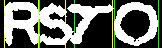

Running tally::: correct: 1 total: 1 accuracy: 1.000 avgEditDist 0.000
special window 0 8 ['F 0.69 ', 'R 0.18 ', 'V 0.13 ', 'J 0.08 ', 'T 0.04 ']
New example, correct answers:
ROCTR
[4, 46, 83, 119, 154]
[49, 85, 121, 155, 183]
model 3: ROCTR 0.545
[8, 48, 84, 120, 152]
[48, 84, 120, 156, 184]
edit distance: 0


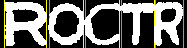

Running tally::: correct: 2 total: 2 accuracy: 1.000 avgEditDist 0.000
New example, correct answers:
TEOLT
[4, 43, 72, 115, 145]
[45, 74, 116, 154, 186]
model 3: TEOLT 0.482
[0, 44, 76, 116, 148]
[44, 76, 116, 148, 188]
edit distance: 0


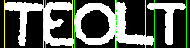

Running tally::: correct: 3 total: 3 accuracy: 1.000 avgEditDist 0.000
New example, correct answers:
LSVO
[4, 38, 78, 118]
[41, 79, 120, 162]
model 3: LSVO 0.629
[0, 40, 80, 120]
[40, 80, 120, 164]
edit distance: 0


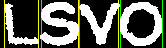

Running tally::: correct: 4 total: 4 accuracy: 1.000 avgEditDist 0.000
New example, correct answers:
LS
[4, 30]
[38, 62]
model 3: LS 0.770
[0, 32]
[32, 64]
edit distance: 0


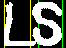

Running tally::: correct: 5 total: 5 accuracy: 1.000 avgEditDist 0.000
New example, correct answers:
CPOOEN
[4, 36, 74, 111, 154, 194]
[38, 75, 113, 156, 195, 234]
model 3: CPOOEN 0.459
[0, 40, 76, 116, 156, 196]
[40, 76, 116, 156, 196, 236]
edit distance: 0


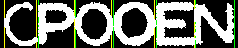

Running tally::: correct: 6 total: 6 accuracy: 1.000 avgEditDist 0.000
special window 0 8 ['E 0.98 ', 'V 0.13 ', 'T 0.11 ', 'L 0.05 ', 'Y 0.04 ']
New example, correct answers:
EVE
[4, 39, 87]
[48, 89, 126]
model 3: EVE 0.688
[4, 44, 88]
[44, 88, 128]
edit distance: 0


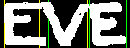

Running tally::: correct: 7 total: 7 accuracy: 1.000 avgEditDist 0.000
special window 0 16 ['I 0.99 ', 'N 0.87 ', 'V 0.17 ', 'M 0.05 ', 'T 0.05 ']
New example, correct answers:
INA
[4, 12, 54]
[14, 56, 93]
model 3: INA 0.751
[0, 16, 56]
[16, 56, 96]
edit distance: 0


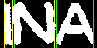

Running tally::: correct: 8 total: 8 accuracy: 1.000 avgEditDist 0.000
special window 88 96 ['E 1.00 ', 'N 0.86 ', 'V 0.02 ', 'I 0.01 ', 'W 0.01 ']
New example, correct answers:
ONEVO
[4, 46, 93, 128, 161]
[49, 94, 129, 168, 208]
model 3: ONEVO 0.562
[0, 48, 96, 128, 164]
[48, 92, 128, 164, 208]
edit distance: 0


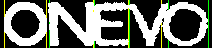

Running tally::: correct: 9 total: 9 accuracy: 1.000 avgEditDist 0.000
New example, correct answers:
LWGO
[4, 37, 88, 130]
[38, 90, 132, 175]
model 3: LWGO 0.641
[0, 36, 88, 136]
[36, 88, 136, 176]
edit distance: 0


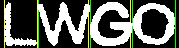

Running tally::: correct: 10 total: 10 accuracy: 1.000 avgEditDist 0.000
special window 116 124 ['E 1.00 ', 'D 0.64 ', 'O 0.09 ', 'Y 0.04 ', 'V 0.04 ']
New example, correct answers:
NAOEO
[4, 40, 76, 116, 156]
[43, 78, 118, 157, 203]
model 3: NAOEO 0.469
[0, 44, 80, 120, 156]
[44, 80, 116, 156, 204]
edit distance: 0


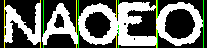

Running tally::: correct: 11 total: 11 accuracy: 1.000 avgEditDist 0.000
special window 164 180 ['E 1.00 ', 'I 0.96 ', 'C 0.88 ', 'L 0.03 ', 'D 0.02 ']
New example, correct answers:
ROWCEP
[4, 38, 82, 131, 169, 198]
[40, 83, 133, 171, 199, 232]
model 3: ROWCIEP 0.444
[0, 40, 80, 132, 164, 176, 200]
[40, 80, 132, 168, 180, 204, 232]
edit distance: 1
-----------------------------------------------------------------------------


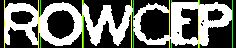

Running tally::: correct: 11 total: 12 accuracy: 0.917 avgEditDist 0.083
New example, correct answers:
RUST
[4, 37, 87, 123]
[39, 90, 125, 168]
model 3: RUST 0.616
[0, 40, 88, 124]
[40, 88, 124, 168]
edit distance: 0


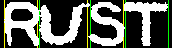

Running tally::: correct: 12 total: 13 accuracy: 0.923 avgEditDist 0.077
New example, correct answers:
LVAO
[4, 26, 63, 99]
[33, 65, 104, 148]
model 3: LVAO 0.412
[0, 32, 68, 104]
[36, 68, 104, 148]
edit distance: 0


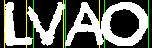

Running tally::: correct: 13 total: 14 accuracy: 0.929 avgEditDist 0.071
New example, correct answers:
EVR
[4, 33, 76]
[37, 77, 113]
model 3: EVR 0.734
[0, 36, 76]
[36, 76, 116]
edit distance: 0


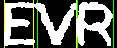

Running tally::: correct: 14 total: 15 accuracy: 0.933 avgEditDist 0.067
New example, correct answers:
ARSLA
[4, 43, 78, 108, 144]
[45, 79, 110, 145, 184]
model 3: ARSLA 0.583
[0, 44, 76, 108, 144]
[44, 80, 108, 144, 184]
edit distance: 0


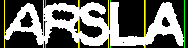

Running tally::: correct: 15 total: 16 accuracy: 0.938 avgEditDist 0.062
special window 0 8 ['L 0.97 ', 'V 0.13 ', 'T 0.11 ', 'Y 0.03 ', 'A 0.03 ']
New example, correct answers:
LABR
[4, 37, 76, 111]
[38, 78, 113, 151]
model 3: LABR 0.682
[4, 36, 76, 112]
[36, 76, 112, 152]
edit distance: 0


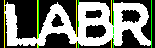

Running tally::: correct: 16 total: 17 accuracy: 0.941 avgEditDist 0.059
New example, correct answers:
EO
[4, 29]
[37, 66]
model 3: EO 0.770
[0, 32]
[32, 68]
edit distance: 0


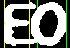

Running tally::: correct: 17 total: 18 accuracy: 0.944 avgEditDist 0.056
special window 0 8 ['R 0.99 ', 'V 0.16 ', 'T 0.09 ', 'L 0.06 ', 'J 0.03 ']
special window 112 120 ['I 0.99 ', 'C 0.58 ', 'T 0.16 ', 'V 0.13 ', 'L 0.09 ']
New example, correct answers:
RVCI
[4, 35, 73, 110]
[38, 81, 111, 120]
model 3: RVCI 0.657
[4, 36, 76, 112]
[36, 76, 112, 120]
edit distance: 0


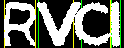

Running tally::: correct: 18 total: 19 accuracy: 0.947 avgEditDist 0.053
New example, correct answers:
COV
[4, 46, 85]
[48, 88, 125]
model 3: COV 0.660
[0, 44, 88]
[44, 88, 128]
edit distance: 0


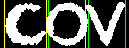

Running tally::: correct: 19 total: 20 accuracy: 0.950 avgEditDist 0.050
New example, correct answers:
CKLNR
[4, 44, 81, 113, 154]
[46, 83, 114, 155, 189]
model 3: CKLNR 0.527
[0, 44, 80, 116, 156]
[44, 80, 116, 156, 192]
edit distance: 0


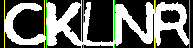

Running tally::: correct: 20 total: 21 accuracy: 0.952 avgEditDist 0.048
special window 116 124 ['I 1.00 ', 'K 0.90 ', 'V 0.08 ', 'A 0.07 ', 'T 0.06 ']
New example, correct answers:
TEKI
[4, 46, 81, 114]
[48, 82, 116, 124]
model 3: TEKI 0.706
[0, 48, 80, 116]
[48, 80, 116, 124]
edit distance: 0


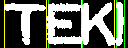

Running tally::: correct: 21 total: 22 accuracy: 0.955 avgEditDist 0.045
special window 80 88 ['D 1.00 ', 'E 0.97 ', 'T 0.04 ', 'V 0.03 ', 'L 0.01 ']
special window 188 204 ['D 0.99 ', 'I 0.99 ', 'V 0.16 ', 'T 0.09 ', 'L 0.04 ']
New example, correct answers:
OEDCDI
[4, 48, 80, 123, 160, 191]
[50, 82, 128, 162, 193, 202]
model 3: OEDCDI 0.494
[0, 48, 84, 124, 160, 188]
[48, 80, 124, 160, 192, 204]
edit distance: 0


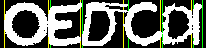

Running tally::: correct: 22 total: 23 accuracy: 0.957 avgEditDist 0.043
New example, correct answers:
KGKLLV
[4, 34, 69, 107, 135, 169]
[42, 71, 108, 137, 173, 203]
model 3: KGKLLV 0.380
[0, 36, 68, 104, 136, 168]
[36, 68, 104, 136, 172, 204]
edit distance: 0


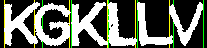

Running tally::: correct: 23 total: 24 accuracy: 0.958 avgEditDist 0.042
New example, correct answers:
ECBD
[4, 35, 72, 108]
[36, 73, 110, 151]
model 3: ECBD 0.587
[0, 36, 72, 108]
[36, 72, 108, 152]
edit distance: 0


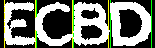

Running tally::: correct: 24 total: 25 accuracy: 0.960 avgEditDist 0.040
New example, correct answers:
LNST
[4, 33, 75, 106]
[36, 78, 111, 152]
model 3: LNST 0.594
[0, 36, 76, 112]
[36, 76, 112, 152]
edit distance: 0


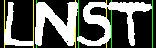

Running tally::: correct: 25 total: 26 accuracy: 0.962 avgEditDist 0.038
New example, correct answers:
EO
[4, 34]
[37, 73]
model 3: EO 0.769
[0, 36]
[36, 76]
edit distance: 0


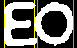

Running tally::: correct: 26 total: 27 accuracy: 0.963 avgEditDist 0.037
special window 76 84 ['N 0.89 ', 'A 0.79 ', 'F 0.02 ', 'H 0.02 ', 'J 0.02 ']
New example, correct answers:
DNARVC
[4, 38, 81, 123, 163, 200]
[40, 83, 124, 165, 203, 240]
model 3: DNARVC 0.400
[0, 40, 84, 128, 164, 204]
[40, 80, 128, 164, 204, 240]
edit distance: 0


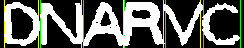

Running tally::: correct: 27 total: 28 accuracy: 0.964 avgEditDist 0.036
New example, correct answers:
HDTCA
[4, 39, 73, 112, 150]
[43, 75, 116, 152, 192]
model 3: HDTCA 0.538
[0, 40, 76, 116, 152]
[40, 76, 116, 152, 192]
edit distance: 0


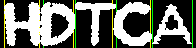

Running tally::: correct: 28 total: 29 accuracy: 0.966 avgEditDist 0.034
special window 148 156 ['E 0.99 ', 'F 0.99 ', 'V 0.01 ', 'S 0.01 ', 'L 0.01 ']
New example, correct answers:
NNEEFU
[4, 41, 77, 117, 149, 183]
[43, 79, 119, 150, 185, 224]
model 3: NNEEFU 0.540
[0, 40, 76, 112, 152, 184]
[40, 76, 112, 148, 184, 224]
edit distance: 0


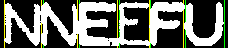

Running tally::: correct: 29 total: 30 accuracy: 0.967 avgEditDist 0.033
New example, correct answers:
ERAOGU
[4, 33, 75, 116, 166, 204]
[35, 77, 117, 167, 206, 240]
model 3: ERAOGU 0.422
[0, 36, 76, 116, 164, 204]
[36, 76, 116, 164, 204, 240]
edit distance: 0


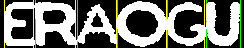

Running tally::: correct: 30 total: 31 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
EUDO
[4, 32, 70, 106]
[35, 71, 108, 147]
model 3: EUDO 0.607
[0, 32, 72, 108]
[32, 72, 108, 148]
edit distance: 0


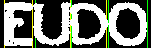

Running tally::: correct: 31 total: 32 accuracy: 0.969 avgEditDist 0.031
special window 0 8 ['F 0.63 ', 'R 0.41 ', 'V 0.16 ', 'J 0.07 ', 'T 0.05 ']
New example, correct answers:
RBRETF
[4, 60, 99, 133, 170, 196]
[62, 100, 135, 172, 197, 226]
model 3: RLBRETF 0.286
[4, 36, 64, 100, 136, 172, 196]
[40, 64, 100, 136, 172, 200, 228]
edit distance: 1
-----------------------------------------------------------------------------


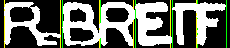

Running tally::: correct: 31 total: 33 accuracy: 0.939 avgEditDist 0.061
New example, correct answers:
AO
[4, 42]
[49, 86]
model 3: AO 0.777
[0, 44]
[44, 88]
edit distance: 0


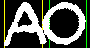

Running tally::: correct: 32 total: 34 accuracy: 0.941 avgEditDist 0.059
New example, correct answers:
ON
[4, 43]
[45, 87]
model 3: ON 0.809
[0, 44]
[44, 88]
edit distance: 0


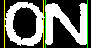

Running tally::: correct: 33 total: 35 accuracy: 0.943 avgEditDist 0.057
special window 148 156 ['E 1.00 ', 'N 0.90 ', 'V 0.04 ', 'Y 0.01 ', 'W 0.01 ']
special window 192 200 ['E 1.00 ', 'T 0.04 ', 'F 0.02 ', 'A 0.02 ', 'S 0.01 ']
New example, correct answers:
EOHNEE
[4, 30, 70, 110, 154, 190]
[35, 72, 112, 156, 192, 234]
model 3: EOHNEE 0.492
[0, 36, 72, 112, 156, 196]
[36, 72, 112, 152, 192, 236]
edit distance: 0


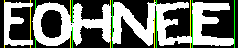

Running tally::: correct: 34 total: 36 accuracy: 0.944 avgEditDist 0.056
special window 148 156 ['I 1.00 ', 'N 0.82 ', 'C 0.12 ', 'U 0.07 ', 'V 0.07 ']
New example, correct answers:
LONNIO
[4, 30, 70, 111, 151, 162]
[34, 71, 112, 153, 164, 204]
model 3: LONNIO 0.554
[0, 36, 72, 112, 148, 168]
[36, 72, 112, 152, 156, 204]
edit distance: 0


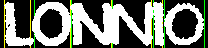

Running tally::: correct: 35 total: 37 accuracy: 0.946 avgEditDist 0.054
New example, correct answers:
RLDH
[4, 44, 82, 114]
[45, 83, 115, 148]
model 3: RLDH 0.661
[0, 44, 80, 112]
[44, 80, 112, 148]
edit distance: 0


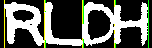

Running tally::: correct: 36 total: 38 accuracy: 0.947 avgEditDist 0.053
New example, correct answers:
AA
[4, 42]
[45, 87]
model 3: AA 0.854
[0, 44]
[48, 88]
edit distance: 0


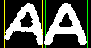

Running tally::: correct: 37 total: 39 accuracy: 0.949 avgEditDist 0.051
New example, correct answers:
ODV
[4, 44, 79]
[48, 82, 125]
model 3: ODV 0.686
[0, 44, 80]
[44, 80, 128]
edit distance: 0


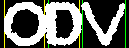

Running tally::: correct: 38 total: 40 accuracy: 0.950 avgEditDist 0.050
New example, correct answers:
REUNE
[4, 48, 85, 119, 159]
[51, 87, 120, 160, 193]
model 3: REUNE 0.621
[0, 48, 84, 120, 160]
[48, 84, 120, 160, 196]
edit distance: 0


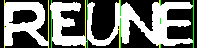

Running tally::: correct: 39 total: 41 accuracy: 0.951 avgEditDist 0.049
New example, correct answers:
THE
[4, 41, 79]
[42, 80, 113]
model 3: THE 0.713
[0, 40, 80]
[44, 80, 116]
edit distance: 0


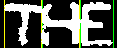

Running tally::: correct: 40 total: 42 accuracy: 0.952 avgEditDist 0.048
special window 116 132 ['I 1.00 ', 'P 0.89 ', 'A 0.87 ', 'F 0.02 ', 'V 0.02 ']
New example, correct answers:
TOAIPT
[4, 42, 77, 123, 131, 162]
[52, 82, 124, 132, 163, 198]
model 3: TOAIPT 0.497
[0, 44, 80, 116, 132, 164]
[44, 80, 120, 132, 164, 200]
edit distance: 0


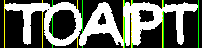

Running tally::: correct: 41 total: 43 accuracy: 0.953 avgEditDist 0.047
New example, correct answers:
TETAT
[4, 49, 82, 120, 151]
[51, 84, 128, 161, 195]
model 3: TETAT 0.466
[0, 48, 80, 120, 156]
[48, 80, 120, 156, 196]
edit distance: 0


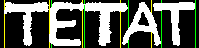

Running tally::: correct: 42 total: 44 accuracy: 0.955 avgEditDist 0.045
New example, correct answers:
PMDDE
[4, 43, 88, 121, 156]
[45, 89, 122, 157, 188]
model 3: PMDDE 0.570
[0, 40, 88, 120, 156]
[40, 88, 120, 156, 188]
edit distance: 0


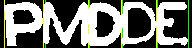

Running tally::: correct: 43 total: 45 accuracy: 0.956 avgEditDist 0.044
special window 40 56 ['I 1.00 ', 'T 0.64 ', 'O 0.50 ', 'D 0.24 ', 'V 0.02 ']
special window 136 144 ['N 0.79 ', 'V 0.76 ', 'W 0.06 ', 'I 0.05 ', 'A 0.02 ']
New example, correct answers:
OITVN
[4, 43, 53, 99, 136]
[45, 55, 102, 138, 180]
model 3: OITVN 0.577
[0, 40, 56, 100, 144]
[40, 56, 104, 136, 180]
edit distance: 0


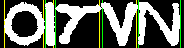

Running tally::: correct: 44 total: 46 accuracy: 0.957 avgEditDist 0.043
special window 0 8 ['N 0.89 ', 'V 0.17 ', 'J 0.05 ', 'T 0.05 ', 'Y 0.03 ']
special window 40 48 ['S 0.95 ', 'N 0.89 ', 'V 0.04 ', 'J 0.02 ', 'Y 0.01 ']
New example, correct answers:
NS
[4, 47]
[49, 84]
model 3: NS 0.824
[4, 48]
[44, 84]
edit distance: 0


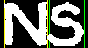

Running tally::: correct: 45 total: 47 accuracy: 0.957 avgEditDist 0.043
special window 0 16 ['I 1.00 ', 'H 0.83 ', 'V 0.29 ', 'F 0.08 ', 'J 0.04 ']
special window 44 52 ['H 0.99 ', 'V 0.16 ', 'T 0.09 ', 'Y 0.03 ', 'L 0.02 ']
New example, correct answers:
IH
[4, 13]
[15, 51]
model 3: IH 0.899
[0, 16]
[16, 48]
edit distance: 0


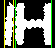

Running tally::: correct: 46 total: 48 accuracy: 0.958 avgEditDist 0.042
special window 0 16 ['I 0.99 ', 'A 0.83 ', 'V 0.18 ', 'H 0.05 ', 'L 0.04 ']
New example, correct answers:
IAD
[4, 16, 57]
[18, 58, 96]
model 3: IAD 0.813
[0, 16, 56]
[16, 56, 96]
edit distance: 0


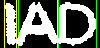

Running tally::: correct: 47 total: 49 accuracy: 0.959 avgEditDist 0.041
special window 36 44 ['B 1.00 ', 'D 0.25 ', 'L 0.14 ', 'C 0.11 ', 'T 0.03 ']
New example, correct answers:
BDORE
[4, 37, 81, 120, 152]
[39, 82, 122, 156, 185]
model 3: BDORE 0.554
[0, 44, 76, 120, 152]
[36, 80, 120, 152, 188]
edit distance: 0


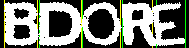

Running tally::: correct: 48 total: 50 accuracy: 0.960 avgEditDist 0.040
special window 72 88 ['I 1.00 ', 'O 0.92 ', 'V 0.78 ', 'J 0.03 ', 'W 0.02 ']
New example, correct answers:
VOIV
[4, 39, 79, 85]
[42, 80, 87, 125]
model 3: VOIV 0.718
[0, 40, 72, 88]
[40, 76, 88, 128]
edit distance: 0


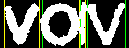

Running tally::: correct: 49 total: 51 accuracy: 0.961 avgEditDist 0.039
special window 0 8 ['L 0.99 ', 'V 0.14 ', 'T 0.13 ', 'Y 0.03 ', 'J 0.02 ']
New example, correct answers:
LSEE
[4, 35, 67, 106]
[38, 70, 108, 139]
model 3: LSEE 0.634
[4, 36, 72, 108]
[36, 72, 108, 140]
edit distance: 0


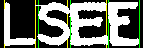

Running tally::: correct: 50 total: 52 accuracy: 0.962 avgEditDist 0.038
New example, correct answers:
AVEAED
[4, 38, 71, 114, 161, 193]
[43, 75, 119, 164, 195, 231]
model 3: AVEAED 0.357
[0, 40, 80, 120, 164, 196]
[40, 80, 120, 164, 200, 232]
edit distance: 0


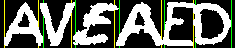

Running tally::: correct: 51 total: 53 accuracy: 0.962 avgEditDist 0.038
New example, correct answers:
KL
[4, 39]
[41, 75]
model 3: KL 0.822
[0, 40]
[40, 76]
edit distance: 0


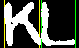

Running tally::: correct: 52 total: 54 accuracy: 0.963 avgEditDist 0.037
special window 0 16 ['I 0.99 ', 'V 0.94 ', 'J 0.05 ', 'T 0.04 ', 'W 0.02 ']
New example, correct answers:
IV
[4, 14]
[16, 52]
model 3: IV 0.895
[0, 16]
[16, 52]
edit distance: 0


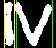

Running tally::: correct: 53 total: 55 accuracy: 0.964 avgEditDist 0.036
New example, correct answers:
RRFKEV
[4, 42, 76, 108, 143, 174]
[44, 78, 109, 145, 176, 224]
model 3: RRFKEV 0.536
[0, 44, 76, 108, 144, 176]
[44, 76, 108, 144, 176, 224]
edit distance: 0


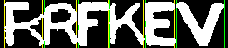

Running tally::: correct: 54 total: 56 accuracy: 0.964 avgEditDist 0.036
New example, correct answers:
AP
[4, 43]
[44, 75]
model 3: AP 0.788
[0, 44]
[44, 76]
edit distance: 0


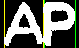

Running tally::: correct: 55 total: 57 accuracy: 0.965 avgEditDist 0.035
special window 68 76 ['H 0.99 ', 'A 0.94 ', 'V 0.02 ', 'F 0.01 ', 'M 0.01 ']
New example, correct answers:
LHAOA
[4, 37, 73, 112, 150]
[39, 74, 114, 154, 188]
model 3: LHAOA 0.520
[0, 36, 76, 116, 152]
[36, 72, 116, 152, 188]
edit distance: 0


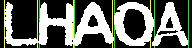

Running tally::: correct: 56 total: 58 accuracy: 0.966 avgEditDist 0.034
special window 144 156 ['A 0.89 ', 'N 0.83 ', 'I 0.02 ', 'V 0.01 ', 'H 0.01 ']
New example, correct answers:
LGENA
[4, 34, 75, 107, 151]
[39, 76, 109, 153, 195]
model 3: LGENA 0.576
[0, 36, 76, 108, 156]
[36, 76, 108, 148, 196]
edit distance: 0


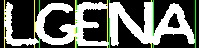

Running tally::: correct: 57 total: 59 accuracy: 0.966 avgEditDist 0.034
special window 40 52 ['I 0.99 ', 'R 0.96 ', 'G 0.81 ', 'F 0.03 ', 'L 0.02 ']
special window 160 168 ['A 0.95 ', 'M 0.79 ', 'V 0.02 ', 'F 0.01 ', 'W 0.01 ']
New example, correct answers:
GIRTMA
[4, 39, 49, 81, 118, 164]
[42, 50, 82, 120, 166, 206]
model 3: GIRTMA 0.583
[0, 40, 52, 84, 120, 168]
[40, 52, 84, 120, 164, 208]
edit distance: 0


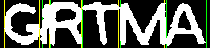

Running tally::: correct: 58 total: 60 accuracy: 0.967 avgEditDist 0.033
special window 44 52 ['E 1.00 ', 'N 0.85 ', 'V 0.03 ', 'W 0.01 ', 'A 0.01 ']
special window 128 144 ['I 0.99 ', 'A 0.95 ', 'T 0.08 ', 'V 0.06 ', 'Y 0.03 ']
New example, correct answers:
NEAI
[4, 47, 83, 130]
[50, 85, 133, 141]
model 3: NEAI 0.746
[0, 48, 84, 128]
[44, 84, 128, 144]
edit distance: 0


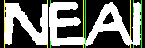

Running tally::: correct: 59 total: 61 accuracy: 0.967 avgEditDist 0.033
New example, correct answers:
OFANO
[4, 46, 80, 122, 158]
[49, 84, 124, 160, 197]
model 3: OFANO 0.520
[0, 48, 84, 124, 160]
[48, 84, 124, 160, 200]
edit distance: 0


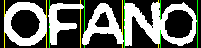

Running tally::: correct: 60 total: 62 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
ESEGE
[4, 39, 69, 109, 147]
[41, 74, 110, 148, 182]
model 3: ESEGE 0.611
[0, 36, 72, 108, 148]
[36, 72, 108, 148, 184]
edit distance: 0


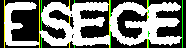

Running tally::: correct: 61 total: 63 accuracy: 0.968 avgEditDist 0.032
special window 36 48 ['E 0.99 ', 'N 0.86 ', 'V 0.14 ', 'Y 0.02 ', 'L 0.01 ']
New example, correct answers:
NBR
[4, 44, 84]
[47, 85, 118]
model 3: NBR 0.759
[0, 48, 84]
[40, 84, 120]
edit distance: 0


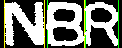

Running tally::: correct: 62 total: 64 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
CB
[4, 51]
[54, 88]
model 3: CB 0.685
[0, 48]
[48, 88]
edit distance: 0


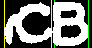

Running tally::: correct: 63 total: 65 accuracy: 0.969 avgEditDist 0.031
special window 0 8 ['E 0.99 ', 'V 0.16 ', 'T 0.12 ', 'L 0.05 ', 'A 0.04 ']
special window 36 44 ['R 0.98 ', 'E 0.96 ', 'V 0.05 ', 'W 0.01 ', 'T 0.01 ']
New example, correct answers:
ER
[4, 35]
[38, 76]
model 3: ER 0.788
[4, 40]
[36, 76]
edit distance: 0


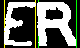

Running tally::: correct: 64 total: 66 accuracy: 0.970 avgEditDist 0.030
New example, correct answers:
FNH
[4, 39, 78]
[40, 80, 117]
model 3: FNH 0.707
[0, 40, 80]
[40, 80, 120]
edit distance: 0


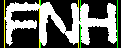

Running tally::: correct: 65 total: 67 accuracy: 0.970 avgEditDist 0.030
special window 0 8 ['E 0.99 ', 'V 0.14 ', 'T 0.10 ', 'L 0.05 ', 'A 0.04 ']
New example, correct answers:
EWO
[4, 43, 96]
[45, 101, 137]
model 3: EWO 0.723
[8, 44, 100]
[44, 100, 140]
edit distance: 0


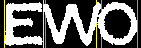

Running tally::: correct: 66 total: 68 accuracy: 0.971 avgEditDist 0.029
special window 36 44 ['S 0.99 ', 'H 0.69 ', 'F 0.14 ', 'V 0.04 ', 'J 0.03 ']
special window 76 84 ['H 0.86 ', 'N 0.80 ', 'I 0.05 ', 'V 0.02 ', 'M 0.01 ']
New example, correct answers:
SHNNG
[4, 37, 80, 121, 162]
[39, 82, 123, 164, 211]
model 3: SHNNG 0.582
[0, 40, 84, 124, 164]
[36, 80, 124, 164, 212]
edit distance: 0


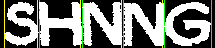

Running tally::: correct: 67 total: 69 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
LLVLE
[4, 41, 70, 107, 146]
[43, 73, 109, 147, 177]
model 3: LLVLE 0.585
[0, 36, 72, 108, 144]
[40, 76, 108, 144, 180]
edit distance: 0


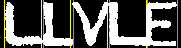

Running tally::: correct: 68 total: 70 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
APEORA
[4, 44, 78, 105, 147, 181]
[46, 80, 112, 150, 183, 222]
model 3: APEORA 0.491
[0, 44, 80, 112, 148, 184]
[44, 80, 112, 148, 184, 224]
edit distance: 0


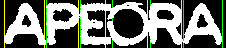

Running tally::: correct: 69 total: 71 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
AWABOR
[4, 46, 97, 142, 172, 212]
[54, 103, 144, 174, 214, 255]
model 3: AWABOR 0.458
[0, 48, 100, 144, 176, 212]
[48, 100, 144, 176, 212, 256]
edit distance: 0


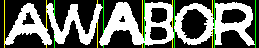

Running tally::: correct: 70 total: 72 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
EML
[4, 34, 78]
[36, 80, 114]
model 3: EML 0.765
[0, 36, 80]
[36, 80, 116]
edit distance: 0


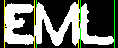

Running tally::: correct: 71 total: 73 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
CAOWEA
[4, 38, 78, 121, 171, 203]
[40, 84, 123, 172, 205, 244]
model 3: CAOWEA 0.482
[0, 40, 80, 120, 172, 204]
[40, 80, 120, 172, 204, 244]
edit distance: 0


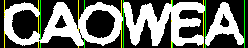

Running tally::: correct: 72 total: 74 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
NHR
[4, 45, 79]
[46, 80, 114]
model 3: NHR 0.734
[0, 44, 80]
[44, 80, 116]
edit distance: 0


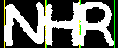

Running tally::: correct: 73 total: 75 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
LTHSO
[4, 31, 68, 103, 135]
[40, 70, 104, 137, 174]
model 3: LTHSO 0.522
[0, 32, 68, 104, 136]
[32, 68, 104, 136, 176]
edit distance: 0


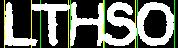

Running tally::: correct: 74 total: 76 accuracy: 0.974 avgEditDist 0.026
special window 0 8 ['N 0.76 ', 'V 0.20 ', 'J 0.08 ', 'T 0.05 ', 'Y 0.04 ']
New example, correct answers:
NRAL
[4, 45, 82, 127]
[48, 84, 129, 163]
model 3: NRAL 0.668
[8, 48, 84, 128]
[48, 84, 128, 164]
edit distance: 0


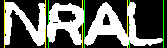

Running tally::: correct: 75 total: 77 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
GE
[4, 41]
[42, 76]
model 3: GE 0.776
[0, 40]
[40, 76]
edit distance: 0


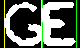

Running tally::: correct: 76 total: 78 accuracy: 0.974 avgEditDist 0.026
special window 0 16 ['I 1.00 ', 'F 0.73 ', 'V 0.38 ', 'J 0.05 ', 'E 0.03 ']
New example, correct answers:
IPETK
[4, 13, 51, 80, 118]
[16, 52, 85, 120, 158]
model 3: IPETK 0.593
[0, 20, 52, 84, 120]
[16, 52, 84, 120, 160]
edit distance: 0


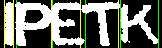

Running tally::: correct: 77 total: 79 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
OHA
[4, 42, 80]
[45, 81, 119]
model 3: OHA 0.701
[0, 40, 80]
[40, 80, 120]
edit distance: 0


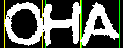

Running tally::: correct: 78 total: 80 accuracy: 0.975 avgEditDist 0.025
special window 36 44 ['N 0.99 ', 'A 0.80 ', 'F 0.04 ', 'J 0.01 ', 'T 0.01 ']
special window 188 196 ['R 0.99 ', 'A 0.90 ', 'V 0.03 ', 'N 0.02 ', 'T 0.01 ']
New example, correct answers:
NABTAR
[4, 41, 81, 112, 146, 188]
[44, 84, 117, 151, 190, 227]
model 3: NABTAR 0.419
[0, 44, 84, 116, 148, 192]
[40, 84, 116, 152, 188, 228]
edit distance: 0


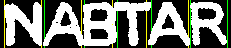

Running tally::: correct: 79 total: 81 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
AO
[4, 51]
[55, 93]
model 3: AO 0.704
[0, 48]
[48, 96]
edit distance: 0


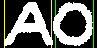

Running tally::: correct: 80 total: 82 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SC
[4, 38]
[40, 78]
model 3: SC 0.813
[0, 40]
[40, 80]
edit distance: 0


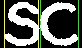

Running tally::: correct: 81 total: 83 accuracy: 0.976 avgEditDist 0.024
special window 44 52 ['M 0.64 ', 'J 0.52 ', 'V 0.24 ', 'A 0.09 ', 'F 0.08 ']
New example, correct answers:
MRELAL
[4, 51, 94, 127, 162, 206]
[54, 95, 129, 164, 208, 243]
model 3: MRELAL 0.583
[0, 52, 92, 128, 164, 208]
[48, 92, 128, 164, 208, 244]
edit distance: 0


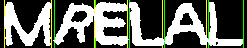

Running tally::: correct: 82 total: 84 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
ATSC
[4, 41, 77, 108]
[46, 78, 111, 148]
model 3: ATSC 0.585
[0, 44, 80, 112]
[44, 80, 112, 148]
edit distance: 0


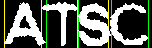

Running tally::: correct: 83 total: 85 accuracy: 0.976 avgEditDist 0.024
special window 180 188 ['N 0.96 ', 'V 0.09 ', 'T 0.07 ', 'J 0.05 ', 'H 0.03 ']
New example, correct answers:
ELDAN
[4, 37, 69, 100, 142]
[39, 71, 102, 144, 186]
model 3: ELDAN 0.541
[0, 36, 68, 104, 144]
[36, 68, 104, 144, 184]
edit distance: 0


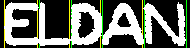

Running tally::: correct: 84 total: 86 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['I 1.00 ', 'E 0.99 ', 'V 0.16 ', 'T 0.10 ', 'L 0.06 ']
New example, correct answers:
IERT
[4, 12, 41, 77]
[14, 43, 79, 109]
model 3: IERT 0.600
[0, 16, 44, 76]
[16, 44, 80, 112]
edit distance: 0


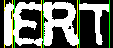

Running tally::: correct: 85 total: 87 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LB
[4, 36]
[37, 74]
model 3: LB 0.815
[0, 36]
[36, 76]
edit distance: 0


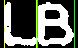

Running tally::: correct: 86 total: 88 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LA
[4, 38]
[40, 83]
model 3: LA 0.812
[0, 40]
[40, 84]
edit distance: 0


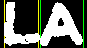

Running tally::: correct: 87 total: 89 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
DF
[4, 41]
[43, 71]
model 3: DF 0.807
[0, 40]
[40, 72]
edit distance: 0


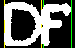

Running tally::: correct: 88 total: 90 accuracy: 0.978 avgEditDist 0.022
special window 80 88 ['L 0.99 ', 'V 0.72 ', 'W 0.01 ', 'T 0.01 ', 'Y 0.01 ']
New example, correct answers:
AVLAV
[4, 44, 83, 114, 148]
[48, 86, 116, 150, 187]
model 3: AVLAV 0.545
[0, 44, 84, 116, 148]
[44, 80, 116, 148, 188]
edit distance: 0


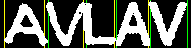

Running tally::: correct: 89 total: 91 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
DH
[4, 39]
[42, 76]
model 3: DH 0.828
[0, 40]
[40, 76]
edit distance: 0


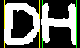

Running tally::: correct: 90 total: 92 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LOBOO
[4, 38, 78, 115, 153]
[41, 79, 116, 156, 195]
model 3: LOBOO 0.562
[0, 40, 80, 116, 152]
[40, 80, 116, 152, 196]
edit distance: 0


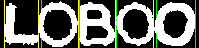

Running tally::: correct: 91 total: 93 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
OTNRL
[4, 46, 85, 129, 162]
[51, 88, 130, 165, 200]
model 3: OTNRL 0.567
[0, 48, 88, 128, 164]
[48, 88, 128, 164, 200]
edit distance: 0


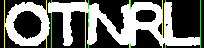

Running tally::: correct: 92 total: 94 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VS
[4, 44]
[46, 76]
model 3: VS 0.829
[0, 44]
[44, 76]
edit distance: 0


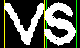

Running tally::: correct: 93 total: 95 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ETR
[4, 33, 78]
[37, 79, 114]
model 3: ETR 0.754
[0, 36, 80]
[36, 80, 116]
edit distance: 0


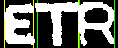

Running tally::: correct: 94 total: 96 accuracy: 0.979 avgEditDist 0.021
special window 40 48 ['F 0.97 ', 'O 0.54 ', 'D 0.16 ', 'V 0.03 ', 'J 0.03 ']
special window 80 96 ['I 0.99 ', 'A 0.88 ', 'F 0.66 ', 'G 0.06 ', 'T 0.01 ']
New example, correct answers:
OFIAOR
[4, 41, 84, 90, 125, 164]
[43, 85, 92, 128, 165, 199]
model 3: OFIAOR 0.586
[0, 44, 80, 92, 128, 164]
[40, 80, 96, 128, 164, 200]
edit distance: 0


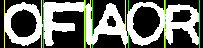

Running tally::: correct: 95 total: 97 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
NTBA
[4, 45, 82, 116]
[48, 83, 118, 160]
model 3: NTBA 0.651
[0, 48, 84, 116]
[48, 84, 116, 160]
edit distance: 0


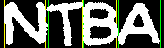

Running tally::: correct: 96 total: 98 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
EWR
[4, 31, 83]
[42, 85, 124]
model 3: EWR 0.717
[0, 36, 88]
[36, 88, 124]
edit distance: 0


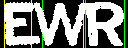

Running tally::: correct: 97 total: 99 accuracy: 0.980 avgEditDist 0.020
special window 36 44 ['E 1.00 ', 'N 0.77 ', 'V 0.20 ', 'Y 0.03 ', 'W 0.01 ']
New example, correct answers:
NELKNT
[4, 42, 74, 106, 143, 180]
[44, 76, 110, 144, 181, 213]
model 3: NELKNT 0.498
[0, 44, 72, 108, 140, 180]
[40, 76, 108, 140, 180, 216]
edit distance: 0


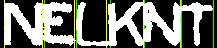

Running tally::: correct: 98 total: 100 accuracy: 0.980 avgEditDist 0.020
special window 220 228 ['N 0.93 ', 'T 0.75 ', 'I 0.37 ', 'V 0.11 ', 'Y 0.01 ']
New example, correct answers:
EWVWNT
[4, 36, 92, 137, 190, 227]
[37, 94, 138, 191, 228, 271]
model 3: EWVWNT 0.544
[0, 40, 96, 136, 184, 228]
[40, 96, 136, 188, 224, 272]
edit distance: 0


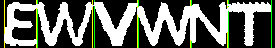

Running tally::: correct: 99 total: 101 accuracy: 0.980 avgEditDist 0.020
special window 80 88 ['H 0.96 ', 'D 0.48 ', 'V 0.07 ', 'L 0.06 ', 'E 0.04 ']
New example, correct answers:
THD
[4, 47, 85]
[49, 87, 119]
model 3: THD 0.757
[0, 48, 88]
[48, 84, 120]
edit distance: 0


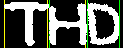

Running tally::: correct: 100 total: 102 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
PAOMNA
[4, 31, 67, 104, 156, 190]
[40, 68, 106, 157, 192, 240]
model 3: PAOMNA 0.459
[0, 36, 68, 104, 156, 192]
[36, 68, 104, 156, 192, 240]
edit distance: 0


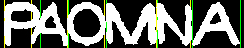

Running tally::: correct: 101 total: 103 accuracy: 0.981 avgEditDist 0.019
special window 124 132 ['I 0.99 ', 'V 0.77 ', 'J 0.07 ', 'T 0.06 ', 'L 0.05 ']
New example, correct answers:
ALVI
[4, 49, 82, 120]
[51, 90, 123, 131]
model 3: ALVI 0.686
[0, 48, 84, 124]
[48, 84, 124, 132]
edit distance: 0


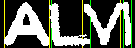

Running tally::: correct: 102 total: 104 accuracy: 0.981 avgEditDist 0.019
New example, correct answers:
RTEA
[4, 40, 75, 112]
[44, 77, 113, 152]
model 3: RTEA 0.640
[0, 40, 76, 112]
[40, 76, 112, 152]
edit distance: 0


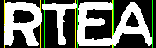

Running tally::: correct: 103 total: 105 accuracy: 0.981 avgEditDist 0.019
New example, correct answers:
BEENON
[4, 39, 72, 101, 145, 188]
[42, 73, 103, 147, 190, 229]
model 3: BEENON 0.526
[0, 40, 72, 104, 144, 188]
[40, 72, 104, 144, 188, 232]
edit distance: 0


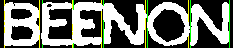

Running tally::: correct: 104 total: 106 accuracy: 0.981 avgEditDist 0.019
New example, correct answers:
CTRE
[4, 38, 74, 107]
[42, 75, 109, 141]
model 3: CTRE 0.634
[0, 40, 76, 108]
[40, 76, 108, 144]
edit distance: 0


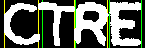

Running tally::: correct: 105 total: 107 accuracy: 0.981 avgEditDist 0.019
New example, correct answers:
ONSNR
[4, 45, 86, 117, 159]
[46, 87, 120, 161, 192]
model 3: ONSNR 0.573
[0, 44, 84, 120, 160]
[44, 84, 120, 160, 192]
edit distance: 0


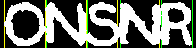

Running tally::: correct: 106 total: 108 accuracy: 0.981 avgEditDist 0.019
New example, correct answers:
NW
[4, 43]
[45, 101]
model 3: NW 0.836
[0, 44]
[44, 104]
edit distance: 0


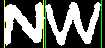

Running tally::: correct: 107 total: 109 accuracy: 0.982 avgEditDist 0.018
special window 80 88 ['E 1.00 ', 'K 0.83 ', 'A 0.03 ', 'Y 0.02 ', 'N 0.02 ']
New example, correct answers:
VKEDH
[4, 42, 80, 115, 152]
[44, 81, 116, 154, 192]
model 3: VKEDH 0.608
[0, 44, 84, 116, 152]
[44, 80, 116, 152, 192]
edit distance: 0


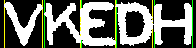

Running tally::: correct: 108 total: 110 accuracy: 0.982 avgEditDist 0.018
special window 48 64 ['L 0.98 ', 'A 0.85 ', 'Y 0.01 ', 'P 0.00 ', 'V 0.00 ']
New example, correct answers:
AL
[4, 57]
[59, 99]
model 3: AL 0.568
[0, 60]
[48, 100]
edit distance: 0


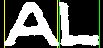

Running tally::: correct: 109 total: 111 accuracy: 0.982 avgEditDist 0.018
New example, correct answers:
DO
[4, 41]
[43, 85]
model 3: DO 0.771
[0, 40]
[40, 88]
edit distance: 0


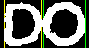

Running tally::: correct: 110 total: 112 accuracy: 0.982 avgEditDist 0.018
special window 180 188 ['H 0.85 ', 'J 0.07 ', 'V 0.07 ', 'T 0.06 ', 'Y 0.03 ']
New example, correct answers:
PTDRH
[4, 40, 76, 114, 147]
[43, 78, 115, 149, 187]
model 3: PTDRH 0.595
[0, 40, 76, 116, 148]
[40, 76, 116, 148, 184]
edit distance: 0


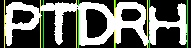

Running tally::: correct: 111 total: 113 accuracy: 0.982 avgEditDist 0.018
special window 0 8 ['P 0.95 ', 'V 0.14 ', 'T 0.07 ', 'J 0.06 ', 'Y 0.04 ']
special window 40 56 ['I 1.00 ', 'P 0.75 ', 'A 0.74 ', 'F 0.01 ', 'H 0.01 ']
New example, correct answers:
PIA
[4, 39, 48]
[42, 51, 103]
model 3: PIA 0.795
[8, 40, 56]
[40, 56, 104]
edit distance: 0


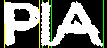

Running tally::: correct: 112 total: 114 accuracy: 0.982 avgEditDist 0.018
special window 36 48 ['N 0.98 ', 'F 0.96 ', 'S 0.01 ', 'L 0.01 ', 'C 0.01 ']
New example, correct answers:
NP
[4, 44]
[46, 84]
model 3: NP 0.787
[0, 48]
[40, 84]
edit distance: 0


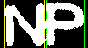

Running tally::: correct: 113 total: 115 accuracy: 0.983 avgEditDist 0.017
New example, correct answers:
CAE
[4, 36, 75]
[38, 78, 109]
model 3: CAE 0.709
[0, 36, 76]
[40, 76, 112]
edit distance: 0


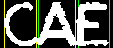

Running tally::: correct: 114 total: 116 accuracy: 0.983 avgEditDist 0.017
New example, correct answers:
RA
[4, 31]
[37, 73]
model 3: RA 0.774
[0, 36]
[36, 76]
edit distance: 0


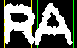

Running tally::: correct: 115 total: 117 accuracy: 0.983 avgEditDist 0.017
New example, correct answers:
WNB
[4, 54, 91]
[56, 93, 129]
model 3: WNB 0.735
[0, 52, 92]
[56, 92, 132]
edit distance: 0


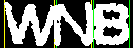

Running tally::: correct: 116 total: 118 accuracy: 0.983 avgEditDist 0.017
special window 0 8 ['N 0.98 ', 'V 0.15 ', 'J 0.07 ', 'T 0.05 ', 'L 0.03 ']
special window 40 48 ['I 1.00 ', 'V 0.77 ', 'N 0.74 ', 'J 0.01 ', 'W 0.01 ']
New example, correct answers:
NIVV
[4, 38, 47, 87]
[41, 48, 88, 126]
model 3: NIVV 0.720
[4, 40, 48, 80]
[40, 48, 84, 128]
edit distance: 0


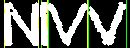

Running tally::: correct: 117 total: 119 accuracy: 0.983 avgEditDist 0.017
New example, correct answers:
LAGVA
[4, 34, 74, 105, 143]
[38, 76, 112, 151, 188]
model 3: LAGVA 0.485
[0, 36, 72, 108, 144]
[36, 72, 108, 144, 188]
edit distance: 0


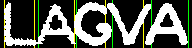

Running tally::: correct: 118 total: 120 accuracy: 0.983 avgEditDist 0.017
New example, correct answers:
OTSADL
[4, 43, 84, 119, 154, 190]
[50, 85, 121, 156, 192, 224]
model 3: OTSADL 0.480
[0, 44, 84, 120, 156, 192]
[44, 84, 120, 156, 192, 224]
edit distance: 0


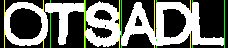

Running tally::: correct: 119 total: 121 accuracy: 0.983 avgEditDist 0.017
special window 0 16 ['I 1.00 ', 'L 0.37 ', 'V 0.20 ', 'U 0.18 ', 'T 0.06 ']
special window 128 136 ['N 0.99 ', 'D 0.87 ', 'V 0.05 ', 'J 0.03 ', 'T 0.02 ']
New example, correct answers:
IUTDNV
[4, 13, 48, 90, 127, 166]
[16, 50, 92, 129, 167, 207]
model 3: IUTDNV 0.551
[0, 16, 48, 92, 132, 168]
[16, 48, 92, 128, 168, 208]
edit distance: 0


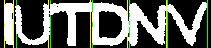

Running tally::: correct: 120 total: 122 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
AAS
[4, 38, 78]
[41, 80, 114]
model 3: AAS 0.770
[0, 36, 80]
[40, 80, 116]
edit distance: 0


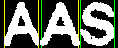

Running tally::: correct: 121 total: 123 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
PSUEV
[4, 44, 79, 115, 146]
[46, 80, 116, 149, 185]
model 3: PSUEV 0.586
[0, 44, 80, 116, 148]
[44, 80, 116, 148, 188]
edit distance: 0


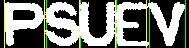

Running tally::: correct: 122 total: 124 accuracy: 0.984 avgEditDist 0.016
special window 0 8 ['R 0.98 ', 'V 0.15 ', 'T 0.09 ', 'J 0.05 ', 'L 0.05 ']
New example, correct answers:
ROCCUR
[4, 35, 73, 109, 149, 190]
[38, 75, 116, 151, 191, 230]
model 3: ROCCUR 0.493
[4, 36, 76, 108, 148, 192]
[36, 76, 112, 148, 192, 232]
edit distance: 0


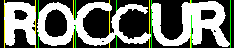

Running tally::: correct: 123 total: 125 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
RO
[4, 37]
[41, 82]
model 3: RO 0.786
[0, 40]
[40, 84]
edit distance: 0


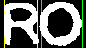

Running tally::: correct: 124 total: 126 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
OA
[4, 47]
[49, 93]
model 3: OA 0.734
[0, 48]
[48, 96]
edit distance: 0


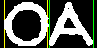

Running tally::: correct: 125 total: 127 accuracy: 0.984 avgEditDist 0.016
special window 0 16 ['E 0.99 ', 'I 0.99 ', 'V 0.17 ', 'T 0.09 ', 'L 0.08 ']
New example, correct answers:
IED
[4, 16, 47]
[17, 49, 83]
model 3: IED 0.814
[0, 16, 48]
[16, 48, 84]
edit distance: 0


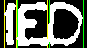

Running tally::: correct: 126 total: 128 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
ADBAEO
[4, 42, 80, 113, 155, 192]
[43, 81, 116, 157, 193, 231]
model 3: ADBAEO 0.536
[0, 44, 80, 116, 156, 192]
[44, 80, 116, 156, 192, 232]
edit distance: 0


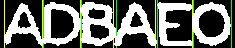

Running tally::: correct: 127 total: 129 accuracy: 0.984 avgEditDist 0.016
New example, correct answers:
EVRCI
[4, 37, 76, 118, 152]
[41, 78, 119, 154, 164]
model 3: EVRC 0.456
[0, 40, 76, 116]
[40, 80, 116, 164]
edit distance: 1
-----------------------------------------------------------------------------


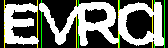

Running tally::: correct: 127 total: 130 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NLL
[4, 43, 78]
[45, 79, 113]
model 3: NLL 0.729
[0, 44, 76]
[44, 76, 116]
edit distance: 0


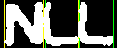

Running tally::: correct: 128 total: 131 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MD
[4, 50]
[52, 86]
model 3: MD 0.833
[0, 52]
[52, 88]
edit distance: 0


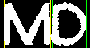

Running tally::: correct: 129 total: 132 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
PC
[4, 41]
[42, 80]
model 3: PC 0.793
[0, 40]
[40, 80]
edit distance: 0


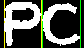

Running tally::: correct: 130 total: 133 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SA
[4, 38]
[40, 81]
model 3: SA 0.828
[0, 40]
[40, 84]
edit distance: 0


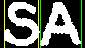

Running tally::: correct: 131 total: 134 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ELUEN
[4, 36, 61, 100, 127]
[37, 69, 102, 130, 171]
model 3: ELUEN 0.500
[0, 36, 64, 100, 128]
[36, 68, 100, 128, 172]
edit distance: 0


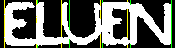

Running tally::: correct: 132 total: 135 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
MLU
[4, 45, 73]
[47, 79, 114]
model 3: MLU 0.721
[0, 44, 76]
[44, 76, 116]
edit distance: 0


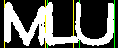

Running tally::: correct: 133 total: 136 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
OAR
[4, 40, 80]
[46, 81, 115]
model 3: OAR 0.712
[0, 44, 80]
[44, 80, 116]
edit distance: 0


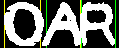

Running tally::: correct: 134 total: 137 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RHST
[4, 37, 72, 105]
[38, 74, 107, 141]
model 3: RHST 0.642
[0, 36, 72, 104]
[36, 72, 104, 144]
edit distance: 0


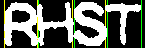

Running tally::: correct: 135 total: 138 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ENHA
[4, 39, 79, 114]
[42, 80, 115, 153]
model 3: ENHA 0.708
[0, 40, 80, 116]
[40, 80, 116, 156]
edit distance: 0


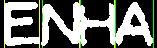

Running tally::: correct: 136 total: 139 accuracy: 0.978 avgEditDist 0.022
special window 40 48 ['E 1.00 ', 'A 0.92 ', 'V 0.02 ', 'F 0.01 ', 'W 0.01 ']
New example, correct answers:
AE
[4, 42]
[43, 81]
model 3: AE 0.804
[0, 44]
[40, 84]
edit distance: 0


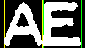

Running tally::: correct: 137 total: 140 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['L 0.98 ', 'V 0.12 ', 'T 0.11 ', 'J 0.03 ', 'Y 0.03 ']
New example, correct answers:
LMKARL
[4, 43, 92, 130, 166, 200]
[45, 94, 131, 170, 202, 239]
model 3: LMKARL 0.498
[8, 44, 92, 128, 168, 200]
[44, 92, 128, 168, 200, 240]
edit distance: 0


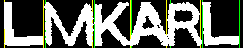

Running tally::: correct: 138 total: 141 accuracy: 0.979 avgEditDist 0.021
special window 0 12 ['I 1.00 ', 'C 0.93 ', 'V 0.27 ', 'T 0.09 ', 'Y 0.03 ']
special window 52 60 ['D 1.00 ', 'T 0.04 ', 'V 0.04 ', 'P 0.01 ', 'L 0.01 ']
New example, correct answers:
IODOE
[4, 10, 52, 84, 128]
[13, 54, 86, 130, 158]
model 3: IODOE 0.633
[0, 12, 56, 88, 128]
[12, 52, 88, 128, 160]
edit distance: 0


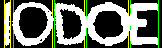

Running tally::: correct: 139 total: 142 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ROOETS
[4, 42, 83, 123, 148, 185]
[44, 84, 125, 149, 188, 222]
model 3: ROOETS 0.459
[0, 40, 88, 124, 152, 188]
[40, 88, 124, 152, 188, 224]
edit distance: 0


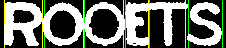

Running tally::: correct: 140 total: 143 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
NAD
[4, 42, 87]
[44, 88, 127]
model 3: NAD 0.654
[0, 44, 88]
[44, 88, 128]
edit distance: 0


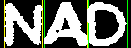

Running tally::: correct: 141 total: 144 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['E 0.99 ', 'V 0.11 ', 'T 0.10 ', 'L 0.05 ', 'A 0.04 ']
New example, correct answers:
EMLN
[4, 43, 89, 120]
[46, 90, 123, 156]
model 3: EMLN 0.648
[4, 44, 88, 120]
[44, 88, 120, 156]
edit distance: 0


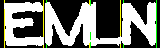

Running tally::: correct: 142 total: 145 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VBCBD
[4, 41, 77, 117, 155]
[42, 79, 120, 157, 189]
model 3: VBCBD 0.561
[0, 40, 80, 116, 156]
[40, 80, 116, 156, 192]
edit distance: 0


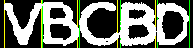

Running tally::: correct: 143 total: 146 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['D 0.42 ', 'V 0.15 ', 'T 0.14 ', 'C 0.12 ', 'L 0.11 ']
special window 80 88 ['N 0.86 ', 'V 0.41 ', 'T 0.09 ', 'L 0.03 ', 'J 0.02 ']
New example, correct answers:
DN
[4, 46]
[49, 86]
model 3: DN 0.800
[8, 44]
[44, 80]
edit distance: 0


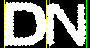

Running tally::: correct: 144 total: 147 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
LEMEDA
[4, 42, 74, 121, 154, 183]
[44, 76, 123, 155, 191, 237]
model 3: LEMEDA 0.452
[0, 40, 76, 124, 156, 192]
[40, 76, 124, 156, 192, 240]
edit distance: 0


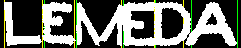

Running tally::: correct: 145 total: 148 accuracy: 0.980 avgEditDist 0.020
special window 108 116 ['I 0.99 ', 'R 0.75 ', 'F 0.56 ', 'S 0.52 ', 'P 0.03 ']
New example, correct answers:
ELSIR
[4, 39, 71, 106, 116]
[43, 73, 107, 117, 154]
model 3: ELSIR 0.653
[0, 40, 72, 108, 116]
[40, 72, 108, 116, 156]
edit distance: 0


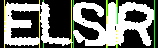

Running tally::: correct: 146 total: 149 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
OLV
[4, 40, 67]
[42, 73, 106]
model 3: OLV 0.582
[0, 40, 68]
[40, 72, 108]
edit distance: 0


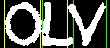

Running tally::: correct: 147 total: 150 accuracy: 0.980 avgEditDist 0.020
special window 0 8 ['N 0.88 ', 'V 0.15 ', 'J 0.08 ', 'M 0.04 ', 'T 0.04 ']
New example, correct answers:
NATE
[4, 43, 78, 117]
[46, 84, 120, 154]
model 3: NATE 0.588
[4, 44, 80, 120]
[44, 80, 120, 156]
edit distance: 0


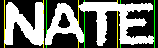

Running tally::: correct: 148 total: 151 accuracy: 0.980 avgEditDist 0.020
special window 40 48 ['L 0.98 ', 'N 0.93 ', 'V 0.02 ', 'Y 0.01 ', 'T 0.01 ']
New example, correct answers:
NLU
[4, 47, 80]
[48, 84, 115]
model 3: NLU 0.727
[0, 48, 80]
[44, 80, 116]
edit distance: 0


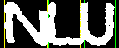

Running tally::: correct: 149 total: 152 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
VRESL
[4, 47, 92, 163, 196]
[50, 93, 164, 198, 231]
model 3: VRRESL 0.193
[0, 44, 76, 124, 164, 196]
[48, 80, 124, 164, 196, 232]
edit distance: 1
-----------------------------------------------------------------------------


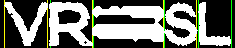

Running tally::: correct: 149 total: 153 accuracy: 0.974 avgEditDist 0.026
special window 36 44 ['I 1.00 ', 'T 0.85 ', 'S 0.79 ', 'V 0.11 ', 'L 0.03 ']
special window 80 88 ['S 0.81 ', 'L 0.41 ', 'D 0.35 ', 'B 0.19 ', 'C 0.09 ']
New example, correct answers:
TISDVN
[4, 36, 44, 80, 123, 163]
[37, 45, 82, 125, 165, 207]
model 3: TISDVN 0.508
[0, 36, 44, 88, 124, 164]
[40, 44, 80, 124, 164, 208]
edit distance: 0


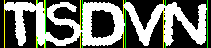

Running tally::: correct: 150 total: 154 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
KV
[4, 41]
[44, 82]
model 3: KV 0.791
[0, 40]
[40, 84]
edit distance: 0


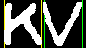

Running tally::: correct: 151 total: 155 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
LCKVWO
[4, 36, 72, 110, 142, 196]
[41, 74, 111, 144, 201, 237]
model 3: LCKVWO 0.455
[0, 36, 72, 108, 144, 200]
[36, 72, 108, 144, 200, 240]
edit distance: 0


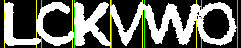

Running tally::: correct: 152 total: 156 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
NRNLM
[4, 40, 76, 117, 151]
[44, 78, 118, 152, 198]
model 3: NRNLM 0.595
[0, 44, 80, 116, 152]
[44, 80, 116, 152, 200]
edit distance: 0


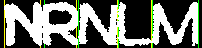

Running tally::: correct: 153 total: 157 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
UVL
[4, 40, 84]
[42, 86, 124]
model 3: UVL 0.695
[0, 40, 84]
[40, 84, 124]
edit distance: 0


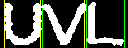

Running tally::: correct: 154 total: 158 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
VEVH
[4, 45, 79, 123]
[51, 81, 125, 165]
model 3: VEVH 0.634
[0, 44, 80, 124]
[44, 80, 124, 168]
edit distance: 0


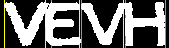

Running tally::: correct: 155 total: 159 accuracy: 0.975 avgEditDist 0.025
special window 156 164 ['F 0.99 ', 'M 0.69 ', 'I 0.01 ', 'L 0.01 ', 'J 0.01 ']
New example, correct answers:
TRDMF
[4, 36, 70, 107, 158]
[38, 72, 110, 160, 195]
model 3: TRDMF 0.578
[0, 36, 72, 108, 164]
[40, 72, 108, 156, 196]
edit distance: 0


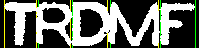

Running tally::: correct: 156 total: 160 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
LDEL
[4, 40, 72, 109]
[42, 74, 111, 146]
model 3: LDEL 0.627
[0, 40, 76, 112]
[40, 76, 112, 148]
edit distance: 0


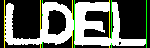

Running tally::: correct: 157 total: 161 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
SD
[4, 41]
[43, 77]
model 3: SD 0.828
[0, 40]
[40, 80]
edit distance: 0


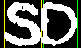

Running tally::: correct: 158 total: 162 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
RRO
[4, 47, 91]
[50, 92, 132]
model 3: RRO 0.723
[0, 44, 92]
[44, 92, 132]
edit distance: 0


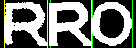

Running tally::: correct: 159 total: 163 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
AE
[4, 42]
[46, 77]
model 3: AE 0.793
[0, 40]
[40, 80]
edit distance: 0


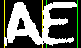

Running tally::: correct: 160 total: 164 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TC
[4, 48]
[50, 89]
model 3: TC 0.789
[0, 48]
[48, 92]
edit distance: 0


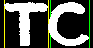

Running tally::: correct: 161 total: 165 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SRCN
[4, 36, 76, 113]
[39, 78, 115, 160]
model 3: SRCN 0.624
[0, 36, 76, 116]
[36, 76, 116, 160]
edit distance: 0


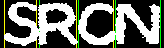

Running tally::: correct: 162 total: 166 accuracy: 0.976 avgEditDist 0.024
special window 184 192 ['N 0.92 ', 'V 0.16 ', 'T 0.07 ', 'J 0.03 ', 'L 0.03 ']
New example, correct answers:
VWAN
[4, 51, 106, 148]
[54, 112, 150, 190]
model 3: VWAN 0.621
[0, 44, 108, 148]
[48, 108, 148, 188]
edit distance: 0


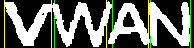

Running tally::: correct: 163 total: 167 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
ACOH
[4, 46, 77, 116]
[51, 80, 117, 155]
model 3: ACOH 0.640
[0, 44, 80, 116]
[44, 80, 116, 156]
edit distance: 0


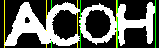

Running tally::: correct: 164 total: 168 accuracy: 0.976 avgEditDist 0.024
special window 40 56 ['I 1.00 ', 'A 0.81 ', 'D 0.79 ', 'O 0.03 ', 'C 0.01 ']
New example, correct answers:
DIAVVP
[4, 47, 54, 92, 135, 171]
[49, 56, 96, 137, 173, 209]
model 3: DIAVVP 0.536
[0, 40, 56, 96, 128, 172]
[44, 56, 96, 132, 172, 212]
edit distance: 0


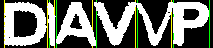

Running tally::: correct: 165 total: 169 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AV
[4, 32]
[40, 72]
model 3: AV 0.773
[0, 36]
[36, 72]
edit distance: 0


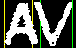

Running tally::: correct: 166 total: 170 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VVEAO
[4, 45, 84, 115, 156]
[47, 85, 117, 162, 195]
model 3: VVEAO 0.559
[0, 40, 84, 116, 160]
[44, 84, 116, 160, 196]
edit distance: 0


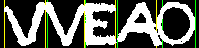

Running tally::: correct: 167 total: 171 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['E 1.00 ', 'V 0.87 ', 'A 0.01 ', 'L 0.01 ', 'W 0.01 ']
New example, correct answers:
VE
[4, 40]
[42, 79]
model 3: VE 0.771
[0, 44]
[40, 80]
edit distance: 0


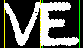

Running tally::: correct: 168 total: 172 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.98 ', 'V 0.14 ', 'T 0.12 ', 'Y 0.03 ', 'A 0.02 ']
New example, correct answers:
LDERWR
[4, 37, 75, 99, 135, 175]
[39, 76, 101, 138, 177, 214]
model 3: LDERWR 0.499
[4, 36, 72, 100, 136, 176]
[36, 72, 100, 136, 176, 216]
edit distance: 0


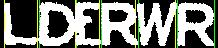

Running tally::: correct: 169 total: 173 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CECULR
[4, 38, 75, 112, 148, 182]
[40, 77, 113, 149, 184, 220]
model 3: CECULR 0.545
[0, 40, 76, 112, 148, 184]
[40, 76, 112, 148, 184, 220]
edit distance: 0


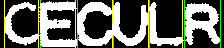

Running tally::: correct: 170 total: 174 accuracy: 0.977 avgEditDist 0.023
special window 120 136 ['I 1.00 ', 'E 0.96 ', 'T 0.81 ', 'M 0.01 ', 'A 0.01 ']
New example, correct answers:
OETIE
[4, 40, 85, 123, 131]
[43, 86, 124, 133, 173]
model 3: OETIE 0.626
[0, 44, 84, 120, 136]
[44, 84, 124, 136, 176]
edit distance: 0


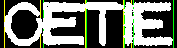

Running tally::: correct: 171 total: 175 accuracy: 0.977 avgEditDist 0.023
special window 64 72 ['K 0.94 ', 'B 0.84 ', 'N 0.05 ', 'L 0.04 ', 'G 0.02 ']
New example, correct answers:
DBKW
[4, 30, 64, 110]
[33, 66, 111, 174]
model 3: OBKW 0.558
[0, 32, 72, 112]
[36, 64, 112, 176]
edit distance: 1
-----------------------------------------------------------------------------


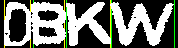

Running tally::: correct: 171 total: 176 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
DR
[4, 43]
[44, 76]
model 3: DR 0.782
[0, 44]
[44, 76]
edit distance: 0


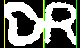

Running tally::: correct: 172 total: 177 accuracy: 0.972 avgEditDist 0.028
special window 40 48 ['E 1.00 ', 'N 0.89 ', 'V 0.04 ', 'Y 0.01 ', 'I 0.01 ']
New example, correct answers:
NEUA
[4, 46, 80, 112]
[48, 81, 113, 152]
model 3: NEUA 0.580
[0, 48, 76, 112]
[44, 80, 112, 152]
edit distance: 0


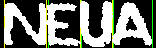

Running tally::: correct: 173 total: 178 accuracy: 0.972 avgEditDist 0.028
special window 36 44 ['R 0.99 ', 'H 0.97 ', 'V 0.02 ', 'A 0.01 ', 'D 0.01 ']
special window 108 116 ['N 0.97 ', 'T 0.96 ', 'L 0.01 ', 'C 0.01 ', 'H 0.01 ']
New example, correct answers:
HRNTO
[4, 40, 75, 113, 151]
[42, 77, 115, 156, 189]
model 3: HRNTO 0.583
[0, 44, 76, 116, 152]
[40, 76, 112, 156, 192]
edit distance: 0


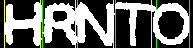

Running tally::: correct: 174 total: 179 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
EEMDO
[4, 38, 76, 128, 163]
[41, 78, 129, 164, 210]
model 3: EEMDO 0.554
[0, 40, 76, 128, 164]
[40, 76, 128, 164, 212]
edit distance: 0


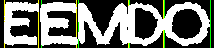

Running tally::: correct: 175 total: 180 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
RW
[4, 42]
[43, 99]
model 3: RW 0.822
[0, 40]
[40, 100]
edit distance: 0


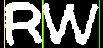

Running tally::: correct: 176 total: 181 accuracy: 0.972 avgEditDist 0.028
special window 44 56 ['E 0.98 ', 'M 0.76 ', 'I 0.15 ', 'N 0.01 ', 'F 0.01 ']
New example, correct answers:
MELWA
[4, 53, 82, 116, 166]
[56, 86, 122, 174, 207]
model 3: MELWA 0.489
[0, 56, 84, 116, 168]
[48, 88, 116, 168, 208]
edit distance: 0


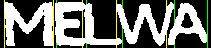

Running tally::: correct: 177 total: 182 accuracy: 0.973 avgEditDist 0.027
special window 156 164 ['D 0.96 ', 'N 0.85 ', 'T 0.04 ', 'C 0.03 ', 'L 0.01 ']
New example, correct answers:
RUAND
[4, 41, 78, 116, 160]
[48, 81, 120, 161, 196]
model 3: RZAND 0.281
[0, 36, 76, 116, 160]
[40, 80, 116, 156, 196]
edit distance: 1
-----------------------------------------------------------------------------


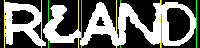

Running tally::: correct: 177 total: 183 accuracy: 0.967 avgEditDist 0.033
special window 40 52 ['I 0.99 ', 'T 0.96 ', 'E 0.90 ', 'B 0.16 ', 'L 0.04 ']
New example, correct answers:
TIBRV
[4, 41, 48, 81, 112]
[45, 50, 82, 115, 152]
model 3: TIBRV 0.598
[0, 40, 52, 80, 116]
[44, 52, 80, 116, 152]
edit distance: 0


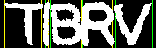

Running tally::: correct: 178 total: 184 accuracy: 0.967 avgEditDist 0.033
New example, correct answers:
VAR
[4, 41, 81]
[46, 83, 119]
model 3: VAR 0.723
[0, 44, 80]
[44, 80, 120]
edit distance: 0


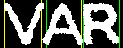

Running tally::: correct: 179 total: 185 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
AENE
[4, 44, 80, 119]
[48, 82, 121, 157]
model 3: AENE 0.643
[0, 44, 80, 120]
[44, 80, 120, 160]
edit distance: 0


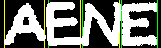

Running tally::: correct: 180 total: 186 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
VR
[4, 44]
[48, 84]
model 3: VR 0.802
[0, 44]
[44, 84]
edit distance: 0


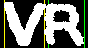

Running tally::: correct: 181 total: 187 accuracy: 0.968 avgEditDist 0.032
special window 44 56 ['T 0.97 ', 'M 0.80 ', 'I 0.01 ', 'A 0.01 ', 'V 0.01 ']
New example, correct answers:
MTFAR
[4, 51, 87, 118, 160]
[54, 89, 124, 161, 197]
model 3: MTFAR 0.526
[0, 52, 88, 120, 160]
[48, 88, 120, 160, 200]
edit distance: 0


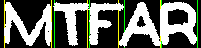

Running tally::: correct: 182 total: 188 accuracy: 0.968 avgEditDist 0.032
special window 0 16 ['I 1.00 ', 'L 0.99 ', 'V 0.16 ', 'T 0.10 ', 'Y 0.03 ']
New example, correct answers:
ILU
[4, 12, 44]
[14, 48, 80]
model 3: ILU 0.765
[0, 12, 44]
[16, 44, 80]
edit distance: 0


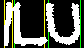

Running tally::: correct: 183 total: 189 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
ARD
[4, 44, 82]
[47, 84, 126]
model 3: ARD 0.666
[0, 44, 84]
[44, 84, 128]
edit distance: 0


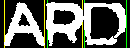

Running tally::: correct: 184 total: 190 accuracy: 0.968 avgEditDist 0.032
New example, correct answers:
SRVNE
[4, 38, 76, 116, 154]
[40, 78, 118, 155, 188]
model 3: SRVNE 0.606
[0, 40, 80, 116, 156]
[40, 80, 116, 156, 188]
edit distance: 0


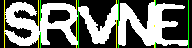

Running tally::: correct: 185 total: 191 accuracy: 0.969 avgEditDist 0.031
special window 76 92 ['I 0.99 ', 'O 0.92 ', 'J 0.13 ', 'V 0.12 ', 'T 0.10 ']
New example, correct answers:
POI
[4, 39, 79]
[41, 81, 90]
model 3: POI 0.799
[0, 40, 76]
[40, 76, 92]
edit distance: 0


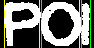

Running tally::: correct: 186 total: 192 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
HSECHR
[4, 43, 78, 105, 143, 184]
[45, 79, 108, 145, 185, 220]
model 3: HSECHR 0.483
[0, 44, 80, 108, 144, 184]
[44, 80, 108, 144, 184, 220]
edit distance: 0


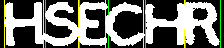

Running tally::: correct: 187 total: 193 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
WAHW
[4, 53, 96, 130]
[60, 97, 132, 184]
model 3: WAHW 0.644
[0, 56, 96, 132]
[56, 96, 132, 184]
edit distance: 0


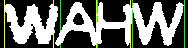

Running tally::: correct: 188 total: 194 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
MORVT
[4, 48, 95, 125, 166]
[51, 97, 131, 167, 203]
model 3: MORVT 0.534
[0, 48, 96, 128, 164]
[48, 96, 128, 168, 204]
edit distance: 0


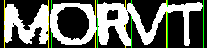

Running tally::: correct: 189 total: 195 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
ATTR
[4, 43, 90, 134]
[50, 91, 135, 172]
model 3: ATTR 0.637
[0, 48, 88, 132]
[48, 92, 132, 172]
edit distance: 0


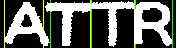

Running tally::: correct: 190 total: 196 accuracy: 0.969 avgEditDist 0.031
New example, correct answers:
RR
[4, 38]
[40, 71]
model 3: RR 0.860
[0, 40]
[40, 72]
edit distance: 0


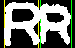

Running tally::: correct: 191 total: 197 accuracy: 0.970 avgEditDist 0.030
special window 0 8 ['E 0.99 ', 'V 0.15 ', 'T 0.11 ', 'L 0.06 ', 'A 0.04 ']
special window 72 84 ['H 0.98 ', 'N 0.86 ', 'V 0.04 ', 'I 0.02 ', 'Y 0.02 ']
New example, correct answers:
ENH
[4, 35, 77]
[37, 79, 116]
model 3: ENH 0.647
[4, 36, 84]
[36, 76, 116]
edit distance: 0


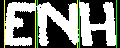

Running tally::: correct: 192 total: 198 accuracy: 0.970 avgEditDist 0.030
special window 96 104 ['T 0.99 ', 'I 0.92 ', 'V 0.16 ', 'Y 0.05 ', 'M 0.02 ']
New example, correct answers:
WTIT
[4, 50, 95, 107]
[55, 96, 109, 155]
model 3: WTIT 0.724
[0, 52, 96, 108]
[52, 96, 104, 156]
edit distance: 0


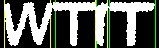

Running tally::: correct: 193 total: 199 accuracy: 0.970 avgEditDist 0.030
special window 84 92 ['E 1.00 ', 'R 0.89 ', 'T 0.02 ', 'V 0.02 ', 'G 0.01 ']
New example, correct answers:
ARE
[4, 47, 84]
[50, 85, 128]
model 3: ARE 0.766
[0, 48, 88]
[48, 84, 128]
edit distance: 0


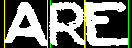

Running tally::: correct: 194 total: 200 accuracy: 0.970 avgEditDist 0.030
New example, correct answers:
DVO
[4, 34, 78]
[43, 79, 120]
model 3: DVO 0.604
[0, 40, 80]
[40, 80, 120]
edit distance: 0


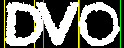

Running tally::: correct: 195 total: 201 accuracy: 0.970 avgEditDist 0.030
New example, correct answers:
OEF
[4, 47, 75]
[49, 76, 105]
model 3: OEF 0.661
[0, 48, 76]
[48, 76, 108]
edit distance: 0


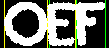

Running tally::: correct: 196 total: 202 accuracy: 0.970 avgEditDist 0.030
New example, correct answers:
LOCPAD
[4, 29, 71, 110, 148, 191]
[40, 72, 113, 150, 192, 228]
model 3: LOCPAD 0.415
[0, 32, 72, 112, 152, 192]
[32, 76, 112, 152, 192, 228]
edit distance: 0


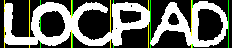

Running tally::: correct: 197 total: 203 accuracy: 0.970 avgEditDist 0.030
special window 116 124 ['E 0.99 ', 'H 0.72 ', 'A 0.05 ', 'M 0.01 ', 'I 0.01 ']
New example, correct answers:
ABHEUN
[4, 43, 73, 117, 152, 189]
[44, 76, 118, 153, 192, 229]
model 3: ABHEUN 0.490
[0, 40, 76, 120, 152, 192]
[44, 76, 116, 152, 192, 232]
edit distance: 0


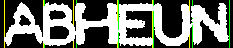

Running tally::: correct: 198 total: 204 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
ORO
[4, 46, 80]
[48, 82, 121]
model 3: ORO 0.726
[0, 44, 84]
[44, 84, 124]
edit distance: 0


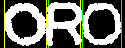

Running tally::: correct: 199 total: 205 accuracy: 0.971 avgEditDist 0.029
special window 36 48 ['N 0.97 ', 'A 0.87 ', 'T 0.01 ', 'L 0.01 ', 'J 0.01 ']
New example, correct answers:
NA
[4, 45]
[47, 87]
model 3: NA 0.778
[0, 48]
[40, 88]
edit distance: 0


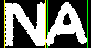

Running tally::: correct: 200 total: 206 accuracy: 0.971 avgEditDist 0.029
special window 76 84 ['F 0.95 ', 'D 0.76 ', 'O 0.09 ', 'J 0.07 ', 'P 0.03 ']
New example, correct answers:
ADP
[4, 46, 77]
[48, 80, 120]
model 3: ADP 0.711
[0, 44, 80]
[44, 76, 120]
edit distance: 0


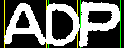

Running tally::: correct: 201 total: 207 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
EE
[4, 42]
[44, 80]
model 3: EE 0.774
[0, 40]
[40, 80]
edit distance: 0


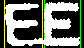

Running tally::: correct: 202 total: 208 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
EA
[4, 34]
[37, 79]
model 3: EA 0.847
[0, 36]
[36, 80]
edit distance: 0


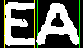

Running tally::: correct: 203 total: 209 accuracy: 0.971 avgEditDist 0.029
New example, correct answers:
SS
[4, 40]
[43, 75]
model 3: SS 0.856
[0, 40]
[44, 76]
edit distance: 0


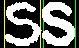

Running tally::: correct: 204 total: 210 accuracy: 0.971 avgEditDist 0.029
special window 40 48 ['E 1.00 ', 'N 0.83 ', 'V 0.01 ', 'A 0.01 ', 'W 0.01 ']
New example, correct answers:
NEO
[4, 44, 75]
[46, 83, 119]
model 3: NEO 0.666
[0, 48, 80]
[44, 80, 120]
edit distance: 0


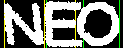

Running tally::: correct: 205 total: 211 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
OEOG
[4, 46, 82, 119]
[48, 84, 121, 160]
model 3: OEOG 0.562
[0, 44, 84, 120]
[44, 84, 120, 160]
edit distance: 0


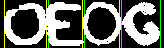

Running tally::: correct: 206 total: 212 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
MCVLC
[4, 51, 85, 131, 162]
[53, 93, 133, 166, 207]
model 3: MCVLC 0.521
[0, 52, 88, 132, 164]
[52, 88, 132, 164, 208]
edit distance: 0


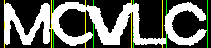

Running tally::: correct: 207 total: 213 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
BED
[4, 35, 66]
[37, 68, 100]
model 3: BED 0.762
[0, 36, 68]
[36, 68, 100]
edit distance: 0


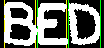

Running tally::: correct: 208 total: 214 accuracy: 0.972 avgEditDist 0.028
special window 44 60 ['I 1.00 ', 'R 0.83 ', 'N 0.76 ', 'P 0.03 ', 'M 0.01 ']
New example, correct answers:
RINVE
[4, 45, 55, 99, 137]
[48, 57, 101, 139, 170]
model 3: RINVE 0.631
[0, 44, 60, 100, 140]
[44, 60, 100, 140, 172]
edit distance: 0


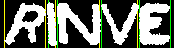

Running tally::: correct: 209 total: 215 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
MARM
[4, 48, 91, 127]
[50, 93, 130, 173]
model 3: MARM 0.669
[0, 52, 92, 128]
[52, 92, 128, 176]
edit distance: 0


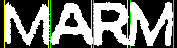

Running tally::: correct: 210 total: 216 accuracy: 0.972 avgEditDist 0.028
special window 76 84 ['I 1.00 ', 'N 0.91 ', 'V 0.17 ', 'T 0.05 ', 'L 0.04 ']
New example, correct answers:
RNI
[4, 41, 78]
[42, 80, 90]
model 3: RNI 0.816
[0, 40, 76]
[40, 76, 84]
edit distance: 0


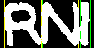

Running tally::: correct: 211 total: 217 accuracy: 0.972 avgEditDist 0.028
special window 104 116 ['D 0.99 ', 'P 0.09 ', 'H 0.05 ', 'N 0.04 ', 'I 0.03 ']
New example, correct answers:
CODH
[4, 35, 74, 105]
[38, 75, 107, 157]
model 3: CODH 0.481
[0, 36, 72, 112]
[40, 72, 104, 160]
edit distance: 0


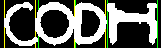

Running tally::: correct: 212 total: 218 accuracy: 0.972 avgEditDist 0.028
New example, correct answers:
ONP
[4, 40, 82]
[43, 84, 122]
model 3: ONP 0.720
[0, 40, 84]
[40, 84, 124]
edit distance: 0


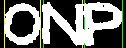

Running tally::: correct: 213 total: 219 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
EOVANO
[4, 31, 73, 115, 153, 192]
[37, 75, 119, 154, 193, 236]
model 3: EOVANO 0.491
[0, 36, 76, 116, 152, 192]
[36, 76, 116, 152, 192, 236]
edit distance: 0


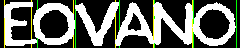

Running tally::: correct: 214 total: 220 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
SRHANV
[4, 38, 74, 111, 145, 189]
[40, 79, 112, 151, 191, 230]
model 3: SRHANV 0.547
[0, 40, 76, 112, 148, 188]
[40, 76, 112, 152, 192, 232]
edit distance: 0


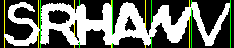

Running tally::: correct: 215 total: 221 accuracy: 0.973 avgEditDist 0.027
special window 148 156 ['R 0.99 ', 'N 0.84 ', 'I 0.02 ', 'T 0.01 ', 'A 0.01 ']
New example, correct answers:
TLVNR
[4, 35, 70, 107, 151]
[37, 77, 109, 153, 189]
model 3: TLVNR 0.513
[0, 36, 68, 108, 152]
[40, 68, 108, 148, 192]
edit distance: 0


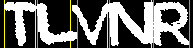

Running tally::: correct: 216 total: 222 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
VPA
[4, 41, 67]
[43, 76, 105]
model 3: VPA 0.646
[0, 44, 72]
[44, 72, 108]
edit distance: 0


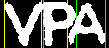

Running tally::: correct: 217 total: 223 accuracy: 0.973 avgEditDist 0.027
special window 148 156 ['N 0.97 ', 'I 0.12 ', 'D 0.03 ', 'V 0.03 ', 'Y 0.02 ']
New example, correct answers:
OSANN
[4, 44, 77, 117, 153]
[46, 79, 118, 155, 198]
model 3: OSANN 0.573
[0, 44, 80, 116, 156]
[44, 80, 116, 152, 200]
edit distance: 0


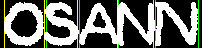

Running tally::: correct: 218 total: 224 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
OODK
[4, 45, 90, 124]
[48, 91, 126, 162]
model 3: OODK 0.652
[0, 44, 92, 124]
[48, 92, 124, 164]
edit distance: 0


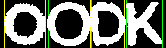

Running tally::: correct: 219 total: 225 accuracy: 0.973 avgEditDist 0.027
special window 84 92 ['C 0.93 ', 'N 0.92 ', 'O 0.01 ', 'Y 0.01 ', 'J 0.01 ']
special window 176 184 ['N 0.93 ', 'D 0.43 ', 'O 0.16 ', 'V 0.05 ', 'J 0.02 ']
New example, correct answers:
TNOON
[4, 47, 89, 133, 175]
[50, 91, 134, 177, 220]
model 3: TNOON 0.586
[0, 48, 92, 136, 180]
[48, 88, 136, 176, 220]
edit distance: 0


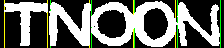

Running tally::: correct: 220 total: 226 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
PO
[4, 41]
[47, 87]
model 3: PO 0.766
[0, 44]
[44, 88]
edit distance: 0


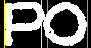

Running tally::: correct: 221 total: 227 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
PPAV
[4, 40, 68, 102]
[41, 72, 108, 147]
model 3: PPAV 0.619
[0, 36, 72, 108]
[40, 72, 108, 148]
edit distance: 0


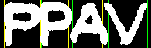

Running tally::: correct: 222 total: 228 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
HL
[4, 41]
[43, 76]
model 3: HL 0.844
[0, 40]
[40, 76]
edit distance: 0


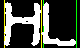

Running tally::: correct: 223 total: 229 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
FLEL
[4, 34, 69, 99]
[36, 71, 101, 138]
model 3: FLEL 0.631
[0, 36, 72, 100]
[36, 72, 100, 140]
edit distance: 0


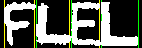

Running tally::: correct: 224 total: 230 accuracy: 0.974 avgEditDist 0.026
special window 36 44 ['R 0.99 ', 'F 0.30 ', 'V 0.03 ', 'J 0.02 ', 'P 0.02 ']
special window 144 156 ['I 0.98 ', 'R 0.98 ', 'T 0.09 ', 'V 0.08 ', 'L 0.06 ']
New example, correct answers:
RRERI
[4, 37, 76, 110, 143]
[39, 77, 111, 146, 156]
model 3: RRERI 0.672
[0, 40, 76, 108, 144]
[36, 80, 108, 144, 156]
edit distance: 0


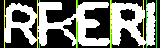

Running tally::: correct: 225 total: 231 accuracy: 0.974 avgEditDist 0.026
special window 188 200 ['A 0.99 ', 'I 0.91 ', 'T 0.09 ', 'V 0.04 ', 'W 0.03 ']
New example, correct answers:
LVPMAI
[4, 37, 77, 114, 154, 188]
[41, 78, 115, 157, 190, 198]
model 3: LVPMAI 0.498
[0, 40, 76, 112, 156, 188]
[40, 76, 112, 156, 188, 200]
edit distance: 0


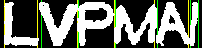

Running tally::: correct: 226 total: 232 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
TDW
[4, 35, 77]
[37, 79, 129]
model 3: TDW 0.596
[0, 36, 76]
[40, 76, 132]
edit distance: 0


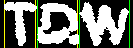

Running tally::: correct: 227 total: 233 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
VPRR
[4, 46, 87, 121]
[49, 88, 123, 154]
model 3: VPRR 0.646
[0, 48, 84, 116]
[48, 84, 120, 156]
edit distance: 0


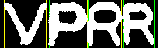

Running tally::: correct: 228 total: 234 accuracy: 0.974 avgEditDist 0.026
special window 0 12 ['I 1.00 ', 'H 0.65 ', 'K 0.52 ', 'V 0.21 ', 'J 0.05 ']
New example, correct answers:
IKTE
[4, 10, 46, 91]
[13, 48, 93, 127]
model 3: IKTE 0.747
[0, 12, 44, 92]
[12, 44, 92, 128]
edit distance: 0


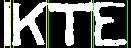

Running tally::: correct: 229 total: 235 accuracy: 0.974 avgEditDist 0.026
special window 36 52 ['I 1.00 ', 'N 0.82 ', 'C 0.78 ', 'O 0.08 ', 'G 0.01 ']
New example, correct answers:
NICL
[4, 40, 50, 86]
[43, 52, 88, 121]
model 3: NICL 0.713
[0, 36, 52, 88]
[40, 52, 88, 124]
edit distance: 0


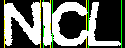

Running tally::: correct: 230 total: 236 accuracy: 0.975 avgEditDist 0.025
special window 76 84 ['D 0.92 ', 'R 0.90 ', 'L 0.08 ', 'T 0.07 ', 'C 0.03 ']
New example, correct answers:
SRDVVA
[4, 42, 74, 117, 155, 183]
[44, 76, 119, 157, 191, 227]
model 3: SRDVVA 0.483
[0, 40, 80, 120, 152, 188]
[40, 76, 120, 156, 188, 228]
edit distance: 0


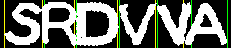

Running tally::: correct: 231 total: 237 accuracy: 0.975 avgEditDist 0.025
special window 84 92 ['E 0.99 ', 'N 0.87 ', 'V 0.01 ', 'A 0.01 ', 'I 0.01 ']
New example, correct answers:
ANEE
[4, 44, 89, 121]
[46, 91, 123, 154]
model 3: ANEE 0.677
[0, 44, 92, 120]
[44, 84, 124, 156]
edit distance: 0


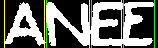

Running tally::: correct: 232 total: 238 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
EUWRU
[4, 35, 69, 125, 161]
[36, 72, 127, 164, 206]
model 3: EUWRU 0.532
[0, 36, 72, 128, 164]
[36, 72, 128, 164, 208]
edit distance: 0


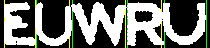

Running tally::: correct: 233 total: 239 accuracy: 0.975 avgEditDist 0.025
special window 0 8 ['K 0.98 ', 'V 0.12 ', 'T 0.09 ', 'L 0.06 ', 'A 0.05 ']
special window 36 52 ['I 1.00 ', 'K 0.82 ', 'N 0.66 ', 'M 0.02 ', 'F 0.02 ']
special window 156 164 ['N 0.92 ', 'R 0.82 ', 'F 0.12 ', 'J 0.03 ', 'V 0.02 ']
New example, correct answers:
KINTNR
[4, 40, 49, 88, 123, 159]
[45, 51, 89, 124, 163, 209]
model 3: KINTNR 0.513
[4, 36, 52, 88, 120, 164]
[40, 52, 88, 120, 160, 212]
edit distance: 0


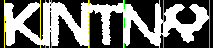

Running tally::: correct: 234 total: 240 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
TB
[4, 40]
[42, 79]
model 3: TB 0.797
[0, 40]
[40, 80]
edit distance: 0


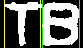

Running tally::: correct: 235 total: 241 accuracy: 0.975 avgEditDist 0.025
special window 76 92 ['I 1.00 ', 'F 0.93 ', 'V 0.85 ', 'W 0.04 ', 'A 0.01 ']
New example, correct answers:
TVIFRH
[4, 45, 79, 89, 117, 155]
[48, 81, 91, 119, 157, 196]
model 3: TVIFRH 0.570
[0, 44, 76, 92, 120, 156]
[48, 80, 92, 120, 156, 196]
edit distance: 0


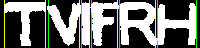

Running tally::: correct: 236 total: 242 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
ORRUA
[4, 45, 78, 113, 151]
[47, 79, 114, 153, 191]
model 3: ORRUA 0.576
[0, 44, 72, 112, 152]
[44, 76, 112, 152, 192]
edit distance: 0


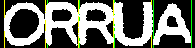

Running tally::: correct: 237 total: 243 accuracy: 0.975 avgEditDist 0.025
special window 0 16 ['I 0.99 ', 'S 0.98 ', 'V 0.19 ', 'T 0.06 ', 'Y 0.06 ']
New example, correct answers:
ISENTO
[4, 11, 45, 77, 111, 148]
[12, 46, 79, 113, 156, 192]
model 3: ISENTO 0.467
[0, 12, 44, 76, 112, 148]
[16, 44, 76, 112, 148, 192]
edit distance: 0


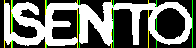

Running tally::: correct: 238 total: 244 accuracy: 0.975 avgEditDist 0.025
special window 108 124 ['I 1.00 ', 'L 0.94 ', 'A 0.32 ', 'P 0.06 ', 'V 0.06 ']
New example, correct answers:
DELIA
[4, 42, 76, 113, 120]
[43, 77, 114, 122, 171]
model 3: DELIA 0.674
[0, 40, 76, 108, 124]
[40, 76, 112, 124, 172]
edit distance: 0


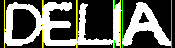

Running tally::: correct: 239 total: 245 accuracy: 0.976 avgEditDist 0.024
special window 120 128 ['O 0.69 ', 'K 0.35 ', 'N 0.14 ', 'V 0.10 ', 'H 0.08 ']
New example, correct answers:
SAOKRL
[4, 39, 82, 122, 168, 201]
[41, 88, 124, 169, 202, 239]
model 3: SAOKRL 0.495
[0, 40, 84, 124, 168, 204]
[40, 84, 120, 168, 204, 240]
edit distance: 0


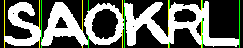

Running tally::: correct: 240 total: 246 accuracy: 0.976 avgEditDist 0.024
special window 76 84 ['J 0.99 ', 'A 0.95 ', 'U 0.03 ', 'F 0.02 ', 'I 0.02 ']
New example, correct answers:
NUA
[4, 42, 73]
[45, 81, 116]
model 3: NUA 0.673
[0, 44, 80]
[44, 76, 116]
edit distance: 0


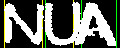

Running tally::: correct: 241 total: 247 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VMLNTE
[4, 47, 95, 128, 180, 220]
[50, 97, 131, 182, 222, 253]
model 3: VMLNTE 0.531
[0, 48, 96, 132, 180, 220]
[48, 96, 132, 180, 220, 256]
edit distance: 0


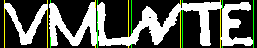

Running tally::: correct: 242 total: 248 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SRRER
[4, 35, 70, 109, 139]
[37, 72, 110, 142, 179]
model 3: SRRER 0.673
[0, 36, 72, 108, 140]
[36, 72, 108, 140, 180]
edit distance: 0


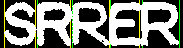

Running tally::: correct: 243 total: 249 accuracy: 0.976 avgEditDist 0.024
special window 72 88 ['I 1.00 ', 'P 0.95 ', 'C 0.87 ', 'O 0.05 ', 'V 0.02 ']
New example, correct answers:
APICDA
[4, 42, 78, 84, 121, 158]
[49, 79, 86, 123, 159, 198]
model 3: APICDA 0.555
[0, 44, 72, 88, 124, 160]
[44, 76, 88, 124, 160, 200]
edit distance: 0


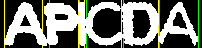

Running tally::: correct: 244 total: 250 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
EE
[4, 31]
[32, 62]
model 3: EE 0.782
[0, 32]
[36, 64]
edit distance: 0


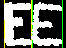

Running tally::: correct: 245 total: 251 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
MDT
[4, 49, 84]
[51, 88, 124]
model 3: MDT 0.688
[0, 48, 84]
[48, 84, 124]
edit distance: 0


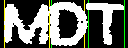

Running tally::: correct: 246 total: 252 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AO
[4, 52]
[55, 97]
model 3: AAO 0.296
[0, 20, 56]
[24, 56, 100]
edit distance: 1
-----------------------------------------------------------------------------


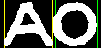

Running tally::: correct: 246 total: 253 accuracy: 0.972 avgEditDist 0.028
special window 0 8 ['L 0.98 ', 'V 0.11 ', 'T 0.10 ', 'A 0.03 ', 'Y 0.03 ']
New example, correct answers:
LT
[4, 42]
[45, 90]
model 3: LT 0.839
[8, 44]
[44, 92]
edit distance: 0


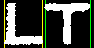

Running tally::: correct: 247 total: 254 accuracy: 0.972 avgEditDist 0.028
special window 144 156 ['T 0.87 ', 'H 0.73 ', 'A 0.03 ', 'I 0.02 ', 'V 0.01 ']
New example, correct answers:
RLCHTG
[4, 35, 70, 106, 150, 191]
[37, 77, 108, 152, 196, 232]
model 3: RLCHTG 0.484
[0, 36, 72, 108, 156, 196]
[36, 72, 108, 148, 196, 232]
edit distance: 0


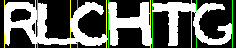

Running tally::: correct: 248 total: 255 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
GGED
[4, 41, 82, 120]
[43, 83, 122, 156]
model 3: GGED 0.668
[0, 44, 84, 120]
[44, 84, 120, 156]
edit distance: 0


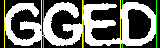

Running tally::: correct: 249 total: 256 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
BRTSA
[4, 38, 70, 104, 136]
[40, 73, 108, 138, 181]
model 3: BRTSA 0.542
[0, 36, 72, 104, 136]
[36, 72, 108, 136, 184]
edit distance: 0


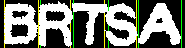

Running tally::: correct: 250 total: 257 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
EDR
[4, 36, 70]
[38, 71, 108]
model 3: EDR 0.745
[0, 36, 68]
[40, 68, 108]
edit distance: 0


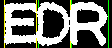

Running tally::: correct: 251 total: 258 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
KLL
[4, 41, 75]
[44, 76, 108]
model 3: KLL 0.658
[0, 40, 72]
[40, 72, 108]
edit distance: 0


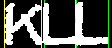

Running tally::: correct: 252 total: 259 accuracy: 0.973 avgEditDist 0.027
special window 0 8 ['E 0.99 ', 'V 0.13 ', 'T 0.08 ', 'L 0.07 ', 'Y 0.04 ']
New example, correct answers:
EHL
[4, 44, 81]
[48, 82, 117]
model 3: EHL 0.671
[8, 48, 84]
[48, 84, 120]
edit distance: 0


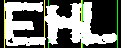

Running tally::: correct: 253 total: 260 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
LFMPC
[4, 39, 72, 116, 156]
[41, 75, 118, 157, 190]
model 3: LFMPC 0.527
[0, 40, 72, 120, 156]
[40, 72, 120, 156, 192]
edit distance: 0


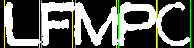

Running tally::: correct: 254 total: 261 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
VND
[4, 46, 82]
[50, 84, 119]
model 3: VND 0.726
[0, 48, 84]
[48, 84, 120]
edit distance: 0


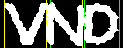

Running tally::: correct: 255 total: 262 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
VLTD
[4, 42, 73, 120]
[44, 79, 122, 162]
model 3: VLTD 0.602
[0, 44, 76, 120]
[44, 76, 120, 164]
edit distance: 0


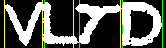

Running tally::: correct: 256 total: 263 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
SLROTS
[4, 40, 76, 118, 152, 197]
[42, 78, 120, 159, 198, 233]
model 3: SLROTS 0.447
[0, 40, 76, 120, 156, 196]
[40, 76, 120, 156, 196, 236]
edit distance: 0


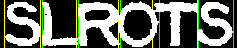

Running tally::: correct: 257 total: 264 accuracy: 0.973 avgEditDist 0.027
New example, correct answers:
LRHL
[4, 40, 72, 105]
[41, 74, 107, 146]
model 3: LRHL 0.668
[0, 40, 72, 108]
[40, 72, 108, 148]
edit distance: 0


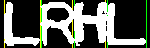

Running tally::: correct: 258 total: 265 accuracy: 0.974 avgEditDist 0.026
special window 0 8 ['F 0.95 ', 'V 0.15 ', 'T 0.07 ', 'J 0.05 ', 'L 0.03 ']
New example, correct answers:
RO
[4, 40]
[45, 83]
model 3: RO 0.774
[4, 40]
[40, 84]
edit distance: 0


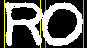

Running tally::: correct: 259 total: 266 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
OH
[4, 41]
[42, 81]
model 3: OH 0.830
[0, 40]
[40, 84]
edit distance: 0


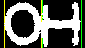

Running tally::: correct: 260 total: 267 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
SOOR
[4, 36, 78, 127]
[38, 80, 128, 161]
model 3: SOOR 0.640
[0, 36, 76, 124]
[36, 76, 124, 164]
edit distance: 0


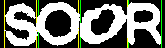

Running tally::: correct: 261 total: 268 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
RETA
[4, 39, 75, 107]
[41, 77, 110, 156]
model 3: RETA 0.593
[0, 40, 76, 112]
[40, 76, 112, 156]
edit distance: 0


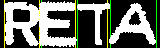

Running tally::: correct: 262 total: 269 accuracy: 0.974 avgEditDist 0.026
special window 68 84 ['I 1.00 ', 'S 0.92 ', 'F 0.75 ', 'R 0.19 ', 'P 0.02 ']
New example, correct answers:
ESIRVR
[4, 39, 72, 79, 121, 163]
[40, 73, 81, 123, 165, 208]
model 3: ESIRVR 0.560
[0, 40, 68, 84, 124, 164]
[40, 72, 84, 124, 164, 208]
edit distance: 0


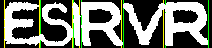

Running tally::: correct: 263 total: 270 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
GRDRLC
[4, 39, 71, 102, 138, 176]
[42, 73, 104, 140, 181, 216]
model 3: GRDRLC 0.541
[0, 40, 72, 104, 140, 176]
[40, 72, 104, 140, 176, 216]
edit distance: 0


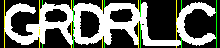

Running tally::: correct: 264 total: 271 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
VB
[4, 47]
[50, 87]
model 3: VB 0.801
[0, 48]
[48, 88]
edit distance: 0


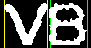

Running tally::: correct: 265 total: 272 accuracy: 0.974 avgEditDist 0.026
special window 40 48 ['T 0.94 ', 'N 0.85 ', 'V 0.05 ', 'H 0.01 ', 'I 0.01 ']
New example, correct answers:
NTD
[4, 44, 87]
[46, 88, 124]
model 3: NTD 0.744
[0, 48, 88]
[44, 88, 124]
edit distance: 0


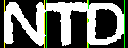

Running tally::: correct: 266 total: 273 accuracy: 0.974 avgEditDist 0.026
special window 0 8 ['E 0.99 ', 'V 0.12 ', 'T 0.10 ', 'L 0.04 ', 'A 0.04 ']
New example, correct answers:
EESS
[4, 42, 79, 116]
[45, 80, 118, 158]
model 3: EESS 0.676
[8, 44, 80, 120]
[44, 80, 120, 160]
edit distance: 0


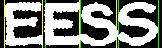

Running tally::: correct: 267 total: 274 accuracy: 0.974 avgEditDist 0.026
special window 36 48 ['I 1.00 ', 'T 0.99 ', 'A 0.02 ', 'L 0.01 ', 'H 0.01 ']
New example, correct answers:
TITAV
[4, 37, 45, 83, 122]
[39, 47, 91, 127, 161]
model 3: TITAV 0.572
[0, 36, 48, 88, 124]
[40, 48, 88, 124, 164]
edit distance: 0


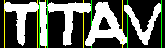

Running tally::: correct: 268 total: 275 accuracy: 0.975 avgEditDist 0.025
special window 72 88 ['I 1.00 ', 'P 0.77 ', 'C 0.25 ', 'L 0.13 ', 'D 0.11 ']
New example, correct answers:
BPID
[4, 36, 72, 83]
[41, 74, 86, 127]
model 3: BPID 0.677
[0, 40, 72, 88]
[40, 72, 88, 128]
edit distance: 0


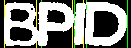

Running tally::: correct: 269 total: 276 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
DE
[4, 36]
[38, 79]
model 3: DE 0.754
[0, 40]
[40, 80]
edit distance: 0


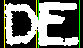

Running tally::: correct: 270 total: 277 accuracy: 0.975 avgEditDist 0.025
special window 0 12 ['I 1.00 ', 'F 0.93 ', 'V 0.17 ', 'H 0.09 ', 'J 0.06 ']
New example, correct answers:
IRET
[4, 12, 45, 84]
[13, 48, 85, 121]
model 3: IRET 0.600
[0, 12, 48, 84]
[12, 48, 84, 124]
edit distance: 0


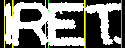

Running tally::: correct: 271 total: 278 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
SEVRA
[4, 37, 65, 104, 139]
[39, 67, 106, 141, 189]
model 3: SEVRA 0.531
[0, 36, 68, 104, 144]
[36, 68, 104, 144, 192]
edit distance: 0


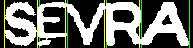

Running tally::: correct: 272 total: 279 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
EOWSVD
[4, 35, 70, 123, 157, 196]
[36, 73, 124, 159, 198, 231]
model 3: EOWSVD 0.544
[0, 36, 72, 124, 160, 196]
[36, 72, 124, 160, 196, 232]
edit distance: 0


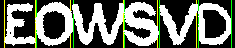

Running tally::: correct: 273 total: 280 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
LAWE
[4, 38, 75, 127]
[41, 78, 128, 158]
model 3: LAWE 0.625
[0, 40, 76, 124]
[40, 76, 124, 160]
edit distance: 0


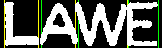

Running tally::: correct: 274 total: 281 accuracy: 0.975 avgEditDist 0.025
special window 80 96 ['I 1.00 ', 'C 0.90 ', 'P 0.73 ', 'O 0.03 ', 'M 0.02 ']
New example, correct answers:
APIC
[4, 42, 84, 93]
[45, 85, 94, 129]
model 3: APIC 0.673
[0, 44, 80, 96]
[44, 80, 96, 132]
edit distance: 0


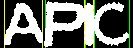

Running tally::: correct: 275 total: 282 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
GH
[4, 42]
[43, 83]
model 3: GH 0.765
[0, 44]
[44, 84]
edit distance: 0


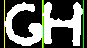

Running tally::: correct: 276 total: 283 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
DWAWT
[4, 33, 87, 130, 181]
[40, 94, 134, 183, 225]
model 3: DWAWT 0.522
[0, 36, 92, 132, 180]
[36, 92, 132, 180, 228]
edit distance: 0


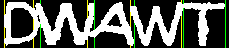

Running tally::: correct: 277 total: 284 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
DO
[4, 42]
[44, 88]
model 3: DO 0.808
[0, 40]
[40, 88]
edit distance: 0


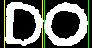

Running tally::: correct: 278 total: 285 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
ADTE
[4, 45, 81, 112]
[47, 83, 114, 144]
model 3: ADTE 0.600
[0, 44, 80, 112]
[44, 80, 116, 144]
edit distance: 0


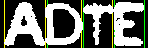

Running tally::: correct: 279 total: 286 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['I 0.99 ', 'E 0.97 ', 'V 0.21 ', 'L 0.09 ', 'T 0.07 ']
special window 116 132 ['I 1.00 ', 'N 0.86 ', 'V 0.11 ', 'L 0.06 ', 'T 0.05 ']
New example, correct answers:
IELNI
[4, 16, 42, 76, 118]
[18, 44, 78, 120, 129]
model 3: IELNI 0.706
[0, 16, 44, 76, 116]
[8, 44, 76, 116, 132]
edit distance: 0


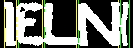

Running tally::: correct: 280 total: 287 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TERDO
[4, 37, 74, 109, 146]
[39, 76, 112, 147, 187]
model 3: TERDO 0.589
[0, 40, 76, 112, 140]
[40, 76, 112, 144, 188]
edit distance: 0


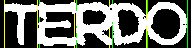

Running tally::: correct: 281 total: 288 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['A 0.93 ', 'N 0.89 ', 'J 0.01 ', 'T 0.01 ', 'F 0.00 ']
New example, correct answers:
NAEL
[4, 46, 86, 119]
[48, 87, 121, 156]
model 3: NAEL 0.649
[0, 48, 84, 120]
[44, 84, 120, 156]
edit distance: 0


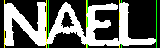

Running tally::: correct: 282 total: 289 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SGT
[4, 41, 79]
[43, 83, 123]
model 3: SGT 0.711
[0, 40, 84]
[40, 84, 124]
edit distance: 0


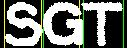

Running tally::: correct: 283 total: 290 accuracy: 0.976 avgEditDist 0.024
special window 72 80 ['E 0.99 ', 'H 0.89 ', 'A 0.03 ', 'V 0.03 ', 'I 0.01 ']
New example, correct answers:
UHB
[4, 39, 78]
[43, 79, 114]
model 3: UHB 0.727
[0, 40, 80]
[40, 76, 116]
edit distance: 0


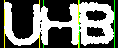

Running tally::: correct: 284 total: 291 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NA
[4, 37]
[39, 81]
model 3: NA 0.822
[0, 40]
[40, 84]
edit distance: 0


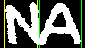

Running tally::: correct: 285 total: 292 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
DMAVEL
[4, 40, 87, 124, 159, 189]
[42, 89, 131, 161, 191, 225]
model 3: DMAVEL 0.459
[0, 40, 88, 124, 160, 192]
[40, 88, 128, 160, 192, 228]
edit distance: 0


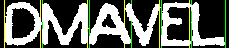

Running tally::: correct: 286 total: 293 accuracy: 0.976 avgEditDist 0.024
special window 116 124 ['E 0.99 ', 'H 0.93 ', 'V 0.01 ', 'A 0.01 ', 'N 0.01 ']
New example, correct answers:
RDHEFO
[4, 42, 79, 118, 157, 194]
[45, 80, 120, 159, 196, 237]
model 3: RDHEFO 0.478
[0, 44, 84, 124, 160, 196]
[44, 84, 120, 160, 196, 240]
edit distance: 0


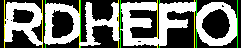

Running tally::: correct: 287 total: 294 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['N 0.90 ', 'P 0.43 ', 'F 0.41 ', 'I 0.04 ', 'V 0.02 ']
special window 152 160 ['N 0.85 ', 'V 0.60 ', 'Y 0.05 ', 'L 0.01 ', 'W 0.01 ']
New example, correct answers:
NPCNVT
[4, 43, 76, 116, 156, 200]
[45, 77, 118, 158, 202, 246]
model 3: NPCNVT 0.513
[0, 44, 76, 116, 160, 200]
[40, 76, 116, 156, 200, 248]
edit distance: 0


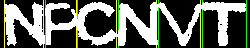

Running tally::: correct: 288 total: 295 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
CDCKV
[4, 45, 76, 117, 152]
[48, 78, 118, 156, 205]
model 3: CDCKV 0.401
[0, 48, 80, 112, 160]
[48, 80, 116, 160, 208]
edit distance: 0


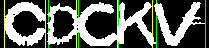

Running tally::: correct: 289 total: 296 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['N 0.84 ', 'G 0.74 ', 'V 0.06 ', 'C 0.01 ', 'I 0.01 ']
New example, correct answers:
NGALES
[4, 46, 82, 115, 149, 182]
[48, 86, 117, 153, 187, 218]
model 3: NGALES 0.513
[0, 48, 84, 116, 152, 184]
[40, 84, 116, 152, 184, 220]
edit distance: 0


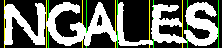

Running tally::: correct: 290 total: 297 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TACEVB
[4, 32, 76, 114, 152, 193]
[40, 77, 115, 154, 194, 228]
model 3: TACEVB 0.441
[0, 40, 76, 116, 152, 192]
[40, 76, 116, 152, 192, 228]
edit distance: 0


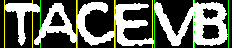

Running tally::: correct: 291 total: 298 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ELV
[4, 33, 64]
[35, 70, 104]
model 3: ELV 0.662
[0, 32, 68]
[36, 68, 104]
edit distance: 0


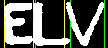

Running tally::: correct: 292 total: 299 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
VOOP
[4, 48, 85, 126]
[50, 87, 127, 165]
model 3: VOOP 0.640
[0, 48, 88, 124]
[48, 92, 124, 168]
edit distance: 0


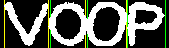

Running tally::: correct: 293 total: 300 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RLRW
[4, 48, 85, 118]
[50, 86, 121, 171]
model 3: RLRW 0.664
[0, 48, 84, 120]
[48, 84, 120, 172]
edit distance: 0


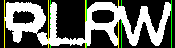

Running tally::: correct: 294 total: 301 accuracy: 0.977 avgEditDist 0.023
special window 36 48 ['I 1.00 ', 'H 0.86 ', 'W 0.54 ', 'V 0.09 ', 'U 0.05 ']
New example, correct answers:
HIWED
[4, 34, 45, 101, 137]
[38, 47, 103, 140, 178]
model 3: HIWED 0.621
[0, 36, 48, 100, 136]
[40, 48, 100, 136, 180]
edit distance: 0


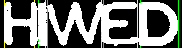

Running tally::: correct: 295 total: 302 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EOLR
[4, 30, 76, 107]
[38, 77, 109, 148]
model 3: EOLR 0.609
[0, 36, 76, 108]
[36, 76, 108, 148]
edit distance: 0


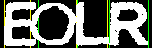

Running tally::: correct: 296 total: 303 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['E 0.99 ', 'I 0.94 ', 'V 0.20 ', 'T 0.06 ', 'L 0.05 ']
New example, correct answers:
IESO
[4, 9, 46, 77]
[12, 48, 79, 118]
model 3: IESO 0.706
[0, 12, 48, 80]
[12, 48, 80, 120]
edit distance: 0


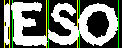

Running tally::: correct: 297 total: 304 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['F 0.92 ', 'V 0.18 ', 'J 0.09 ', 'T 0.05 ', 'Y 0.03 ']
New example, correct answers:
POAEOW
[4, 44, 82, 131, 165, 208]
[46, 86, 132, 167, 210, 263]
model 3: POAEOW 0.455
[8, 44, 84, 128, 168, 208]
[44, 84, 128, 168, 208, 264]
edit distance: 0


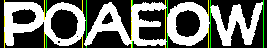

Running tally::: correct: 298 total: 305 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RSRR
[4, 41, 80, 114]
[44, 82, 116, 154]
model 3: RRRR 0.495
[0, 40, 80, 112]
[40, 84, 116, 156]
edit distance: 1
-----------------------------------------------------------------------------


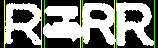

Running tally::: correct: 298 total: 306 accuracy: 0.974 avgEditDist 0.026
special window 40 52 ['P 0.99 ', 'E 0.98 ', 'L 0.03 ', 'V 0.02 ', 'I 0.02 ']
New example, correct answers:
EPO
[4, 41, 81]
[43, 83, 127]
model 3: EPO 0.718
[0, 48, 84]
[40, 84, 128]
edit distance: 0


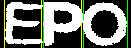

Running tally::: correct: 299 total: 307 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
CK
[4, 44]
[45, 81]
model 3: CK 0.779
[0, 44]
[44, 84]
edit distance: 0


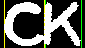

Running tally::: correct: 300 total: 308 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
SET
[4, 38, 68]
[40, 71, 114]
model 3: SET 0.702
[0, 40, 72]
[40, 72, 116]
edit distance: 0


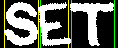

Running tally::: correct: 301 total: 309 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
TA
[4, 37]
[46, 84]
model 3: TA 0.741
[0, 40]
[40, 84]
edit distance: 0


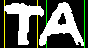

Running tally::: correct: 302 total: 310 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
LO
[4, 34]
[45, 80]
model 3: LO 0.763
[0, 36]
[36, 80]
edit distance: 0


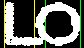

Running tally::: correct: 303 total: 311 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
GEA
[4, 42, 73]
[44, 77, 113]
model 3: GEA 0.665
[0, 44, 76]
[44, 76, 116]
edit distance: 0


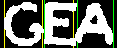

Running tally::: correct: 304 total: 312 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
KS
[4, 38]
[41, 80]
model 3: KS 0.801
[0, 40]
[40, 80]
edit distance: 0


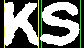

Running tally::: correct: 305 total: 313 accuracy: 0.974 avgEditDist 0.026
special window 64 80 ['I 1.00 ', 'B 0.98 ', 'F 0.87 ', 'P 0.05 ', 'M 0.01 ']
New example, correct answers:
LBIPVA
[4, 35, 70, 76, 109, 146]
[40, 71, 79, 114, 155, 185]
model 3: LBIPVA 0.515
[0, 36, 64, 80, 112, 148]
[36, 68, 80, 112, 148, 188]
edit distance: 0


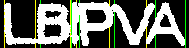

Running tally::: correct: 306 total: 314 accuracy: 0.975 avgEditDist 0.025
special window 72 80 ['P 1.00 ', 'E 0.95 ', 'V 0.01 ', 'L 0.01 ', 'Y 0.01 ']
New example, correct answers:
TEPO
[4, 39, 72, 107]
[40, 73, 108, 152]
model 3: TEPO 0.615
[0, 40, 76, 108]
[40, 72, 108, 152]
edit distance: 0


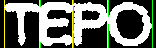

Running tally::: correct: 307 total: 315 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
BHE
[4, 38, 71]
[40, 72, 107]
model 3: BHE 0.725
[0, 36, 72]
[36, 72, 108]
edit distance: 0


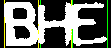

Running tally::: correct: 308 total: 316 accuracy: 0.975 avgEditDist 0.025
special window 40 56 ['I 0.99 ', 'E 0.92 ', 'C 0.44 ', 'D 0.18 ', 'L 0.04 ']
special window 88 100 ['D 0.99 ', 'I 0.99 ', 'T 0.10 ', 'V 0.10 ', 'L 0.06 ']
New example, correct answers:
EIDI
[4, 43, 56, 90]
[45, 57, 92, 100]
model 3: EIDI 0.820
[0, 40, 56, 88]
[40, 56, 92, 100]
edit distance: 0


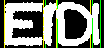

Running tally::: correct: 309 total: 317 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
ANUE
[4, 41, 81, 116]
[44, 83, 117, 153]
model 3: ANUE 0.625
[0, 44, 84, 116]
[44, 84, 116, 156]
edit distance: 0


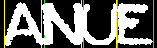

Running tally::: correct: 310 total: 318 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
CEVTN
[4, 37, 71, 115, 153]
[38, 73, 117, 154, 191]
model 3: CEVTN 0.539
[0, 40, 76, 116, 152]
[40, 76, 116, 152, 192]
edit distance: 0


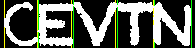

Running tally::: correct: 311 total: 319 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
ANR
[4, 38, 80]
[41, 81, 112]
model 3: ANR 0.770
[0, 40, 80]
[40, 80, 112]
edit distance: 0


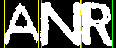

Running tally::: correct: 312 total: 320 accuracy: 0.975 avgEditDist 0.025
special window 84 92 ['L 0.97 ', 'M 0.83 ', 'T 0.02 ', 'V 0.02 ', 'Y 0.01 ']
New example, correct answers:
TMLGCE
[4, 43, 89, 121, 158, 194]
[48, 91, 129, 160, 195, 227]
model 3: TMLGCE 0.521
[0, 44, 92, 124, 160, 196]
[44, 88, 124, 160, 196, 228]
edit distance: 0


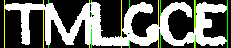

Running tally::: correct: 313 total: 321 accuracy: 0.975 avgEditDist 0.025
special window 76 92 ['I 1.00 ', 'L 0.95 ', 'C 0.78 ', 'T 0.02 ', 'A 0.01 ']
New example, correct answers:
TCILAR
[4, 40, 78, 87, 131, 168]
[46, 80, 89, 132, 170, 204]
model 3: TCILAR 0.536
[0, 40, 76, 88, 128, 168]
[44, 76, 92, 128, 168, 204]
edit distance: 0


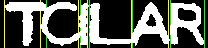

Running tally::: correct: 314 total: 322 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
EREGN
[4, 37, 74, 106, 143]
[39, 75, 109, 144, 187]
model 3: EREGN 0.584
[0, 36, 72, 104, 144]
[36, 72, 104, 144, 188]
edit distance: 0


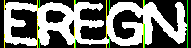

Running tally::: correct: 315 total: 323 accuracy: 0.975 avgEditDist 0.025
special window 32 44 ['I 1.00 ', 'P 0.97 ', 'V 0.72 ', 'Y 0.02 ', 'L 0.01 ']
New example, correct answers:
PIVM
[4, 36, 42, 82]
[37, 44, 85, 135]
model 3: PIVM 0.714
[0, 32, 44, 84]
[36, 44, 84, 136]
edit distance: 0


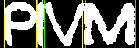

Running tally::: correct: 316 total: 324 accuracy: 0.975 avgEditDist 0.025
special window 112 120 ['N 0.95 ', 'H 0.82 ', 'F 0.05 ', 'V 0.02 ', 'J 0.01 ']
New example, correct answers:
RDNH
[4, 36, 79, 119]
[38, 80, 120, 158]
model 3: RDNH 0.629
[0, 36, 76, 120]
[36, 76, 116, 160]
edit distance: 0


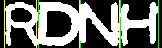

Running tally::: correct: 317 total: 325 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
VTCT
[4, 50, 91, 126]
[52, 97, 128, 168]
model 3: VTCT 0.572
[0, 48, 92, 128]
[48, 92, 128, 168]
edit distance: 0


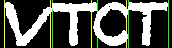

Running tally::: correct: 318 total: 326 accuracy: 0.975 avgEditDist 0.025
special window 40 48 ['E 1.00 ', 'D 0.90 ', 'T 0.02 ', 'O 0.01 ', 'V 0.01 ']
special window 120 128 ['E 0.92 ', 'M 0.80 ', 'T 0.02 ', 'C 0.01 ', 'J 0.01 ']
New example, correct answers:
DEEM
[4, 39, 83, 119]
[41, 85, 121, 171]
model 3: DEEM 0.647
[0, 44, 84, 128]
[40, 84, 120, 172]
edit distance: 0


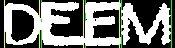

Running tally::: correct: 319 total: 327 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LTN
[4, 31, 73]
[40, 75, 115]
model 3: LTN 0.627
[0, 36, 76]
[36, 76, 116]
edit distance: 0


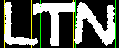

Running tally::: correct: 320 total: 328 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HEO
[4, 44, 68]
[46, 77, 115]
model 3: HEO 0.623
[0, 44, 76]
[44, 76, 116]
edit distance: 0


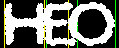

Running tally::: correct: 321 total: 329 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['N 0.95 ', 'V 0.16 ', 'J 0.06 ', 'T 0.05 ', 'L 0.02 ']
special window 36 44 ['N 0.98 ', 'S 0.94 ', 'V 0.05 ', 'Y 0.02 ', 'I 0.01 ']
New example, correct answers:
NS
[4, 41]
[42, 78]
model 3: NS 0.819
[4, 44]
[40, 80]
edit distance: 0


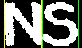

Running tally::: correct: 322 total: 330 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
CDCEE
[4, 41, 75, 112, 145]
[43, 77, 114, 146, 175]
model 3: CDCEE 0.608
[0, 40, 76, 112, 144]
[40, 76, 112, 144, 176]
edit distance: 0


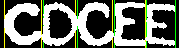

Running tally::: correct: 323 total: 331 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
OVVDSO
[4, 46, 92, 132, 168, 207]
[50, 94, 134, 170, 208, 245]
model 3: OVVDSO 0.498
[0, 48, 92, 132, 172, 208]
[48, 92, 132, 172, 208, 248]
edit distance: 0


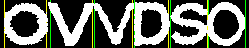

Running tally::: correct: 324 total: 332 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LD
[4, 40]
[43, 79]
model 3: LD 0.843
[0, 40]
[40, 80]
edit distance: 0


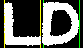

Running tally::: correct: 325 total: 333 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HKH
[4, 43, 81]
[46, 82, 118]
model 3: HKH 0.749
[0, 44, 80]
[44, 80, 120]
edit distance: 0


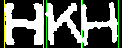

Running tally::: correct: 326 total: 334 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AAT
[4, 47, 83]
[49, 89, 129]
model 3: AAT 0.700
[0, 48, 88]
[48, 88, 132]
edit distance: 0


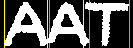

Running tally::: correct: 327 total: 335 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['R 0.98 ', 'V 0.16 ', 'T 0.10 ', 'J 0.07 ', 'L 0.05 ']
New example, correct answers:
RNTDN
[4, 36, 79, 122, 155]
[39, 81, 123, 156, 197]
model 3: RNTDN 0.629
[4, 36, 80, 120, 156]
[36, 80, 120, 156, 200]
edit distance: 0


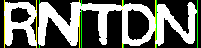

Running tally::: correct: 328 total: 336 accuracy: 0.976 avgEditDist 0.024
special window 0 12 ['I 0.99 ', 'E 0.99 ', 'V 0.17 ', 'L 0.08 ', 'T 0.06 ']
New example, correct answers:
IEEGP
[4, 13, 42, 68, 110]
[15, 45, 72, 111, 147]
model 3: IEEGP 0.573
[0, 12, 44, 72, 112]
[12, 44, 72, 112, 148]
edit distance: 0


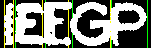

Running tally::: correct: 329 total: 337 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RELK
[4, 38, 69, 97]
[42, 70, 103, 139]
model 3: RELK 0.519
[0, 40, 68, 104]
[40, 72, 104, 140]
edit distance: 0


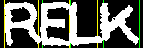

Running tally::: correct: 330 total: 338 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
KKCB
[4, 39, 76, 113]
[41, 79, 115, 146]
model 3: KKCB 0.637
[0, 40, 76, 112]
[40, 76, 112, 148]
edit distance: 0


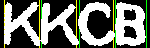

Running tally::: correct: 331 total: 339 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SAAT
[4, 43, 94, 123]
[48, 96, 129, 170]
model 3: SAAT 0.614
[0, 44, 88, 128]
[44, 92, 128, 172]
edit distance: 0


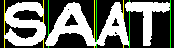

Running tally::: correct: 332 total: 340 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TEV
[4, 38, 76]
[40, 77, 113]
model 3: TEV 0.691
[0, 40, 76]
[40, 76, 116]
edit distance: 0


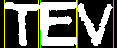

Running tally::: correct: 333 total: 341 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['C 0.97 ', 'N 0.92 ', 'T 0.01 ', 'O 0.01 ', 'V 0.01 ']
special window 152 164 ['I 0.99 ', 'O 0.86 ', 'V 0.13 ', 'T 0.13 ', 'J 0.07 ']
New example, correct answers:
ENCOI
[4, 38, 77, 116, 153]
[39, 78, 117, 155, 162]
model 3: ENCOI 0.614
[0, 36, 80, 116, 152]
[40, 76, 116, 152, 164]
edit distance: 0


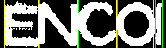

Running tally::: correct: 334 total: 342 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EFFR
[4, 36, 71, 105]
[38, 75, 107, 147]
model 3: EFFR 0.637
[0, 36, 72, 108]
[36, 72, 108, 148]
edit distance: 0


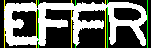

Running tally::: correct: 335 total: 343 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OROAUV
[4, 48, 82, 124, 167, 202]
[49, 84, 126, 170, 205, 243]
model 3: OROAUV 0.458
[0, 48, 84, 124, 168, 204]
[48, 84, 124, 168, 204, 244]
edit distance: 0


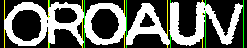

Running tally::: correct: 336 total: 344 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MADOTL
[4, 47, 86, 116, 150, 195]
[48, 88, 118, 156, 196, 231]
model 3: MADOTL 0.464
[0, 48, 84, 116, 156, 196]
[48, 88, 116, 156, 196, 232]
edit distance: 0


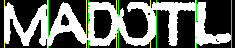

Running tally::: correct: 337 total: 345 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.99 ', 'V 0.14 ', 'T 0.10 ', 'L 0.05 ', 'Y 0.04 ']
New example, correct answers:
ELKAWE
[4, 34, 72, 111, 152, 208]
[37, 77, 112, 153, 209, 247]
model 3: ELKAWE 0.455
[4, 36, 76, 112, 152, 208]
[36, 76, 112, 152, 208, 248]
edit distance: 0


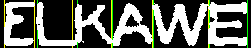

Running tally::: correct: 338 total: 346 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MVASRV
[4, 49, 88, 128, 158, 197]
[52, 90, 129, 161, 199, 244]
model 3: MVASRV 0.513
[0, 52, 92, 128, 160, 200]
[52, 92, 128, 160, 200, 244]
edit distance: 0


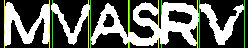

Running tally::: correct: 339 total: 347 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['N 0.99 ', 'M 0.22 ', 'I 0.03 ', 'T 0.01 ', 'V 0.01 ']
special window 108 120 ['N 0.99 ', 'L 0.94 ', 'V 0.01 ', 'T 0.01 ', 'I 0.01 ']
special window 148 156 ['L 0.81 ', 'I 0.80 ', 'J 0.24 ', 'T 0.07 ', 'V 0.07 ']
New example, correct answers:
LNNLI
[4, 40, 79, 117, 149]
[43, 80, 118, 151, 161]
model 3: LNNLI 0.647
[0, 40, 80, 120, 148]
[40, 76, 112, 152, 156]
edit distance: 0


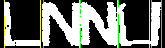

Running tally::: correct: 340 total: 348 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.98 ', 'V 0.13 ', 'T 0.13 ', 'Y 0.03 ', 'A 0.02 ']
special window 116 128 ['C 0.97 ', 'N 0.96 ', 'I 0.32 ', 'T 0.08 ', 'V 0.06 ']
New example, correct answers:
LANOS
[4, 41, 86, 121, 168]
[44, 87, 123, 170, 208]
model 3: LANOS 0.518
[4, 40, 84, 128, 168]
[40, 84, 120, 168, 208]
edit distance: 0


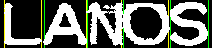

Running tally::: correct: 341 total: 349 accuracy: 0.977 avgEditDist 0.023
special window 80 92 ['I 0.99 ', 'P 0.97 ', 'L 0.89 ', 'V 0.03 ', 'J 0.01 ']
New example, correct answers:
CLIPOV
[4, 44, 77, 88, 120, 156]
[46, 79, 89, 122, 163, 204]
model 3: CLIPOV 0.507
[0, 44, 80, 92, 124, 160]
[44, 80, 92, 124, 160, 204]
edit distance: 0


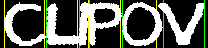

Running tally::: correct: 342 total: 350 accuracy: 0.977 avgEditDist 0.023
special window 80 88 ['N 0.89 ', 'V 0.81 ', 'W 0.01 ', 'T 0.01 ', 'J 0.00 ']
New example, correct answers:
ONVNEA
[4, 48, 87, 122, 163, 194]
[50, 88, 127, 164, 196, 236]
model 3: ONVNEA 0.513
[0, 48, 88, 124, 164, 196]
[48, 84, 124, 164, 196, 236]
edit distance: 0


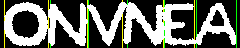

Running tally::: correct: 343 total: 351 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
AMT
[4, 44, 95]
[46, 97, 129]
model 3: AMT 0.657
[0, 44, 96]
[44, 96, 132]
edit distance: 0


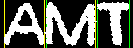

Running tally::: correct: 344 total: 352 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
BNWH
[4, 36, 75, 126]
[37, 78, 128, 165]
model 3: BNWH 0.710
[0, 36, 76, 128]
[36, 76, 128, 168]
edit distance: 0


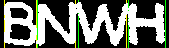

Running tally::: correct: 345 total: 353 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LUN
[4, 41, 85]
[43, 86, 125]
model 3: LUN 0.717
[0, 40, 84]
[40, 84, 128]
edit distance: 0


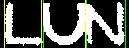

Running tally::: correct: 346 total: 354 accuracy: 0.977 avgEditDist 0.023
special window 76 84 ['N 0.92 ', 'G 0.62 ', 'V 0.06 ', 'T 0.02 ', 'F 0.01 ']
New example, correct answers:
LNGOO
[4, 39, 80, 126, 168]
[41, 82, 127, 170, 213]
model 3: LNGOO 0.598
[0, 40, 84, 124, 172]
[40, 80, 124, 172, 216]
edit distance: 0


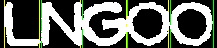

Running tally::: correct: 347 total: 355 accuracy: 0.977 avgEditDist 0.023
special window 156 164 ['R 1.00 ', 'P 0.80 ', 'V 0.03 ', 'N 0.01 ', 'T 0.01 ']
New example, correct answers:
AVTPRE
[4, 40, 85, 123, 155, 193]
[45, 86, 126, 157, 195, 228]
model 3: AVTPRE 0.506
[0, 44, 84, 124, 160, 196]
[44, 84, 124, 156, 196, 228]
edit distance: 0


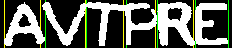

Running tally::: correct: 348 total: 356 accuracy: 0.978 avgEditDist 0.022
special window 144 152 ['H 0.62 ', 'T 0.07 ', 'J 0.07 ', 'V 0.04 ', 'L 0.02 ']
New example, correct answers:
EPVH
[4, 33, 65, 109]
[34, 67, 111, 151]
model 3: EPVH 0.578
[0, 36, 68, 108]
[36, 68, 108, 148]
edit distance: 0


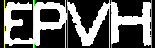

Running tally::: correct: 349 total: 357 accuracy: 0.978 avgEditDist 0.022
special window 76 88 ['I 0.99 ', 'V 0.89 ', 'T 0.04 ', 'L 0.04 ', 'W 0.03 ']
New example, correct answers:
SVI
[4, 39, 79]
[42, 81, 91]
model 3: SVI 0.811
[0, 40, 76]
[40, 76, 88]
edit distance: 0


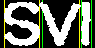

Running tally::: correct: 350 total: 358 accuracy: 0.978 avgEditDist 0.022
special window 36 52 ['I 1.00 ', 'R 0.97 ', 'F 0.04 ', 'H 0.01 ', 'P 0.01 ']
New example, correct answers:
RIREOV
[4, 38, 49, 83, 115, 149]
[43, 51, 84, 122, 154, 189]
model 3: RIREOV 0.587
[0, 36, 52, 84, 116, 152]
[40, 52, 84, 116, 152, 192]
edit distance: 0


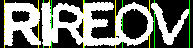

Running tally::: correct: 351 total: 359 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
EREVOH
[4, 32, 64, 96, 131, 175]
[34, 65, 100, 138, 176, 208]
model 3: EREVOH 0.461
[0, 32, 64, 100, 136, 176]
[36, 64, 100, 136, 176, 208]
edit distance: 0


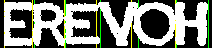

Running tally::: correct: 352 total: 360 accuracy: 0.978 avgEditDist 0.022
special window 44 52 ['L 0.97 ', 'M 0.75 ', 'T 0.03 ', 'I 0.02 ', 'V 0.01 ']
New example, correct answers:
MLRF
[4, 50, 81, 120]
[52, 86, 121, 156]
model 3: MLRF 0.645
[0, 52, 84, 120]
[48, 84, 120, 156]
edit distance: 0


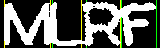

Running tally::: correct: 353 total: 361 accuracy: 0.978 avgEditDist 0.022
special window 180 188 ['N 0.93 ', 'D 0.76 ', 'L 0.23 ', 'C 0.06 ', 'T 0.03 ']
New example, correct answers:
EOGEND
[4, 39, 76, 114, 143, 188]
[40, 78, 115, 145, 189, 223]
model 3: EOGEND 0.510
[0, 40, 80, 116, 144, 188]
[40, 80, 116, 144, 184, 224]
edit distance: 0


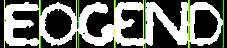

Running tally::: correct: 354 total: 362 accuracy: 0.978 avgEditDist 0.022
special window 72 80 ['E 0.99 ', 'N 0.90 ', 'V 0.04 ', 'L 0.01 ', 'Y 0.01 ']
New example, correct answers:
SNE
[4, 36, 77]
[39, 79, 113]
model 3: SNE 0.747
[0, 36, 80]
[36, 76, 116]
edit distance: 0


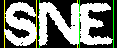

Running tally::: correct: 355 total: 363 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
UAUBRL
[4, 38, 74, 114, 150, 182]
[43, 77, 115, 152, 186, 222]
model 3: UAUBRL 0.456
[0, 40, 72, 116, 152, 184]
[40, 72, 116, 152, 184, 224]
edit distance: 0


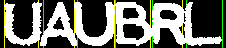

Running tally::: correct: 356 total: 364 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SHD
[4, 44, 85]
[48, 86, 120]
model 3: SHD 0.722
[0, 44, 84]
[44, 84, 120]
edit distance: 0


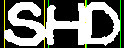

Running tally::: correct: 357 total: 365 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ERFCRD
[4, 35, 72, 110, 147, 178]
[37, 75, 111, 149, 180, 214]
model 3: ERFCRD 0.529
[0, 36, 72, 108, 148, 180]
[36, 72, 108, 148, 180, 216]
edit distance: 0


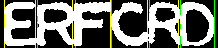

Running tally::: correct: 358 total: 366 accuracy: 0.978 avgEditDist 0.022
special window 72 80 ['E 1.00 ', 'P 0.84 ', 'T 0.01 ', 'A 0.01 ', 'G 0.01 ']
New example, correct answers:
FPEF
[4, 37, 74, 107]
[42, 76, 108, 143]
model 3: FPEF 0.582
[0, 40, 76, 108]
[40, 72, 108, 144]
edit distance: 0


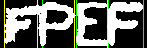

Running tally::: correct: 359 total: 367 accuracy: 0.978 avgEditDist 0.022
special window 136 144 ['I 0.99 ', 'M 0.78 ', 'V 0.12 ', 'T 0.09 ', 'L 0.04 ']
New example, correct answers:
TMMI
[4, 42, 87, 138]
[44, 88, 139, 148]
model 3: TMMI 0.723
[0, 44, 88, 136]
[44, 88, 136, 144]
edit distance: 0


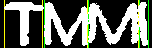

Running tally::: correct: 360 total: 368 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['E 0.98 ', 'V 0.12 ', 'T 0.07 ', 'L 0.05 ', 'Y 0.04 ']
special window 76 88 ['H 0.77 ', 'J 0.08 ', 'T 0.07 ', 'A 0.03 ', 'V 0.03 ']
New example, correct answers:
EH
[4, 40]
[43, 85]
model 3: EH 0.810
[4, 40]
[40, 80]
edit distance: 0


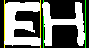

Running tally::: correct: 361 total: 369 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['R 0.96 ', 'V 0.15 ', 'J 0.08 ', 'T 0.05 ', 'F 0.05 ']
New example, correct answers:
RGCO
[4, 40, 79, 115]
[41, 80, 117, 154]
model 3: RGCO 0.663
[4, 40, 80, 116]
[40, 80, 116, 156]
edit distance: 0


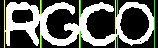

Running tally::: correct: 362 total: 370 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
EDTNL
[4, 32, 59, 104, 143]
[34, 67, 105, 144, 180]
model 3: EDTNL 0.573
[0, 32, 68, 104, 144]
[36, 68, 104, 144, 180]
edit distance: 0


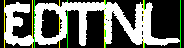

Running tally::: correct: 363 total: 371 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
VABR
[4, 36, 77, 113]
[44, 79, 116, 151]
model 3: VABR 0.576
[0, 40, 80, 112]
[40, 80, 112, 152]
edit distance: 0


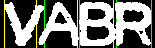

Running tally::: correct: 364 total: 372 accuracy: 0.978 avgEditDist 0.022
special window 76 84 ['R 0.99 ', 'V 0.81 ', 'W 0.01 ', 'L 0.01 ', 'A 0.01 ']
New example, correct answers:
KVR
[4, 36, 79]
[38, 80, 112]
model 3: KVR 0.716
[0, 36, 80]
[40, 76, 112]
edit distance: 0


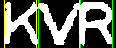

Running tally::: correct: 365 total: 373 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ARDV
[4, 42, 79, 116]
[43, 81, 118, 160]
model 3: ARDV 0.664
[0, 44, 80, 116]
[44, 80, 116, 160]
edit distance: 0


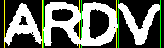

Running tally::: correct: 366 total: 374 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['H 0.98 ', 'V 0.15 ', 'T 0.07 ', 'J 0.06 ', 'Y 0.04 ']
special window 32 40 ['H 0.99 ', 'A 0.80 ', 'V 0.03 ', 'F 0.02 ', 'J 0.01 ']
special window 124 140 ['I 1.00 ', 'C 0.77 ', 'G 0.74 ', 'O 0.03 ', 'L 0.03 ']
New example, correct answers:
HAGICN
[4, 36, 85, 127, 136, 175]
[37, 91, 129, 138, 176, 216]
model 3: HAGICN 0.548
[4, 40, 88, 124, 140, 176]
[36, 88, 124, 140, 176, 216]
edit distance: 0


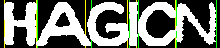

Running tally::: correct: 367 total: 375 accuracy: 0.979 avgEditDist 0.021
special window 48 64 ['I 1.00 ', 'C 0.81 ', 'A 0.72 ', 'V 0.04 ', 'O 0.03 ']
New example, correct answers:
AIOF
[4, 52, 63, 99]
[55, 64, 101, 137]
model 3: AIOF 0.652
[0, 48, 64, 100]
[48, 64, 100, 140]
edit distance: 0


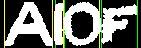

Running tally::: correct: 368 total: 376 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
TRKCEV
[4, 36, 72, 107, 142, 179]
[38, 74, 110, 144, 180, 223]
model 3: TRKCEV 0.460
[0, 36, 72, 108, 144, 180]
[40, 72, 108, 144, 180, 224]
edit distance: 0


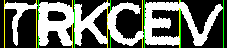

Running tally::: correct: 369 total: 377 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
GRN
[4, 42, 86]
[44, 88, 130]
model 3: GRN 0.747
[0, 44, 88]
[44, 88, 132]
edit distance: 0


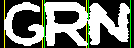

Running tally::: correct: 370 total: 378 accuracy: 0.979 avgEditDist 0.021
special window 92 100 ['H 0.92 ', 'V 0.52 ', 'J 0.07 ', 'Y 0.03 ', 'F 0.01 ']
New example, correct answers:
TVHW
[4, 49, 91, 136]
[51, 93, 137, 190]
model 3: TVHW 0.668
[0, 48, 96, 136]
[48, 92, 136, 192]
edit distance: 0


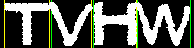

Running tally::: correct: 371 total: 379 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VRO
[4, 42, 81]
[45, 83, 124]
model 3: VRO 0.698
[0, 44, 84]
[44, 84, 124]
edit distance: 0


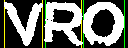

Running tally::: correct: 372 total: 380 accuracy: 0.979 avgEditDist 0.021
special window 120 128 ['C 0.95 ', 'N 0.93 ', 'Y 0.02 ', 'V 0.01 ', 'O 0.01 ']
New example, correct answers:
ORNOTA
[4, 47, 86, 127, 165, 192]
[50, 87, 128, 169, 199, 232]
model 3: ORNOTA 0.393
[0, 48, 84, 128, 164, 196]
[48, 84, 124, 164, 196, 232]
edit distance: 0


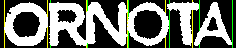

Running tally::: correct: 373 total: 381 accuracy: 0.979 avgEditDist 0.021
special window 44 52 ['D 1.00 ', 'L 0.03 ', 'T 0.03 ', 'V 0.02 ', 'P 0.02 ']
New example, correct answers:
DDAA
[4, 45, 77, 127]
[48, 81, 128, 170]
model 3: DDAA 0.616
[0, 48, 80, 124]
[44, 80, 124, 172]
edit distance: 0


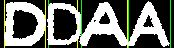

Running tally::: correct: 374 total: 382 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
SAVSTE
[4, 34, 76, 117, 148, 185]
[40, 77, 118, 155, 186, 219]
model 3: SAVSTE 0.460
[0, 36, 76, 120, 152, 188]
[36, 76, 120, 152, 188, 220]
edit distance: 0


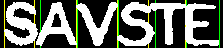

Running tally::: correct: 375 total: 383 accuracy: 0.979 avgEditDist 0.021
special window 44 56 ['L 0.99 ', 'V 0.74 ', 'W 0.01 ', 'T 0.01 ', 'Y 0.01 ']
New example, correct answers:
VLFL
[4, 48, 86, 124]
[51, 88, 125, 158]
model 3: VLFL 0.655
[0, 52, 88, 124]
[44, 88, 124, 160]
edit distance: 0


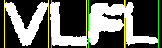

Running tally::: correct: 376 total: 384 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ON
[4, 48]
[50, 84]
model 3: ON 0.830
[0, 48]
[48, 84]
edit distance: 0


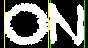

Running tally::: correct: 377 total: 385 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RTEAGR
[4, 41, 84, 120, 171, 205]
[46, 86, 122, 172, 207, 240]
model 3: RTEAGR 0.496
[0, 40, 84, 124, 168, 208]
[40, 84, 124, 168, 208, 240]
edit distance: 0


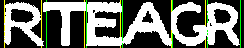

Running tally::: correct: 378 total: 386 accuracy: 0.979 avgEditDist 0.021
special window 76 84 ['H 0.83 ', 'M 0.73 ', 'I 0.03 ', 'A 0.01 ', 'T 0.01 ']
special window 124 136 ['C 0.86 ', 'M 0.79 ', 'G 0.05 ', 'J 0.04 ', 'V 0.04 ']
New example, correct answers:
GHMGLA
[4, 41, 81, 133, 171, 209]
[43, 83, 134, 173, 211, 253]
model 3: GHMGLA 0.514
[0, 40, 84, 136, 172, 212]
[40, 76, 128, 172, 212, 256]
edit distance: 0


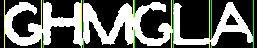

Running tally::: correct: 379 total: 387 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
CK
[4, 40]
[43, 81]
model 3: CK 0.791
[0, 40]
[40, 84]
edit distance: 0


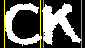

Running tally::: correct: 380 total: 388 accuracy: 0.979 avgEditDist 0.021
special window 112 128 ['I 1.00 ', 'N 0.82 ', 'V 0.17 ', 'T 0.05 ', 'L 0.05 ']
New example, correct answers:
NRNI
[4, 44, 75, 114]
[45, 77, 116, 125]
model 3: NRNI 0.768
[0, 44, 76, 112]
[44, 76, 116, 128]
edit distance: 0


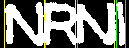

Running tally::: correct: 381 total: 389 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VNDOV
[4, 41, 77, 108, 152]
[43, 79, 110, 154, 193]
model 3: VNDOV 0.554
[0, 44, 80, 112, 152]
[44, 80, 112, 152, 196]
edit distance: 0


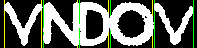

Running tally::: correct: 382 total: 390 accuracy: 0.979 avgEditDist 0.021
special window 96 108 ['H 0.89 ', 'V 0.84 ', 'J 0.01 ', 'W 0.01 ', 'A 0.01 ']
New example, correct answers:
EEHV
[4, 34, 62, 105]
[35, 64, 107, 146]
model 3: EEHV 0.615
[0, 32, 64, 104]
[36, 64, 100, 148]
edit distance: 0


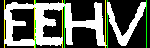

Running tally::: correct: 383 total: 391 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
DFDL
[4, 38, 71, 106]
[40, 72, 107, 142]
model 3: DFDL 0.647
[0, 40, 72, 104]
[40, 72, 104, 144]
edit distance: 0


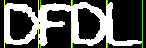

Running tally::: correct: 384 total: 392 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
OFLV
[4, 43, 77, 109]
[44, 79, 111, 155]
model 3: OFLV 0.577
[0, 44, 76, 108]
[44, 76, 108, 156]
edit distance: 0


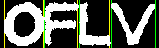

Running tally::: correct: 385 total: 393 accuracy: 0.980 avgEditDist 0.020
special window 40 48 ['E 1.00 ', 'V 0.74 ', 'J 0.03 ', 'A 0.01 ', 'T 0.01 ']
special window 188 196 ['I 0.85 ', 'L 0.71 ', 'J 0.12 ', 'T 0.07 ', 'V 0.04 ']
New example, correct answers:
VERELI
[4, 43, 73, 112, 149, 183]
[45, 74, 113, 151, 185, 194]
model 3: VERELI 0.469
[0, 44, 76, 112, 148, 188]
[40, 76, 112, 148, 188, 196]
edit distance: 0


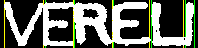

Running tally::: correct: 386 total: 394 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
ETT
[4, 38, 73]
[40, 74, 114]
model 3: ETT 0.690
[0, 36, 72]
[40, 72, 116]
edit distance: 0


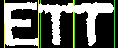

Running tally::: correct: 387 total: 395 accuracy: 0.980 avgEditDist 0.020
special window 228 236 ['N 0.87 ', 'V 0.21 ', 'T 0.08 ', 'L 0.04 ', 'Y 0.02 ']
New example, correct answers:
OPVEAN
[4, 44, 70, 120, 153, 193]
[46, 76, 121, 154, 195, 234]
model 3: OPVEAN 0.516
[0, 44, 76, 120, 152, 192]
[44, 76, 120, 152, 192, 232]
edit distance: 0


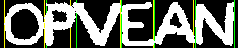

Running tally::: correct: 388 total: 396 accuracy: 0.980 avgEditDist 0.020
special window 108 116 ['E 1.00 ', 'O 0.60 ', 'J 0.06 ', 'Y 0.04 ', 'D 0.04 ']
New example, correct answers:
EAOEP
[4, 32, 71, 108, 144]
[35, 73, 110, 146, 179]
model 3: EAOEP 0.541
[0, 32, 72, 112, 144]
[32, 72, 108, 144, 180]
edit distance: 0


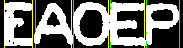

Running tally::: correct: 389 total: 397 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
TEV
[4, 42, 78]
[43, 81, 123]
model 3: TEV 0.674
[0, 44, 80]
[44, 80, 124]
edit distance: 0


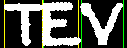

Running tally::: correct: 390 total: 398 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
FCTFAO
[4, 34, 74, 119, 147, 184]
[37, 76, 121, 156, 189, 234]
model 3: FCTFAO 0.403
[0, 36, 76, 120, 152, 188]
[36, 76, 120, 152, 188, 236]
edit distance: 0


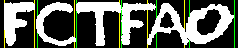

Running tally::: correct: 391 total: 399 accuracy: 0.980 avgEditDist 0.020
special window 148 160 ['I 1.00 ', 'N 0.65 ', 'V 0.49 ', 'Y 0.05 ', 'T 0.04 ']
New example, correct answers:
DCBNI
[4, 38, 80, 116, 155]
[40, 82, 117, 157, 170]
model 3: DCBNI 0.618
[0, 40, 80, 116, 148]
[40, 80, 116, 152, 160]
edit distance: 0


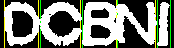

Running tally::: correct: 392 total: 400 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
SE
[4, 36]
[39, 70]
model 3: SE 0.795
[0, 36]
[36, 72]
edit distance: 0


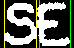

Running tally::: correct: 393 total: 401 accuracy: 0.980 avgEditDist 0.020
special window 0 8 ['N 0.90 ', 'V 0.19 ', 'J 0.04 ', 'T 0.04 ', 'Y 0.03 ']
New example, correct answers:
NTVASI
[4, 47, 82, 115, 160, 195]
[50, 83, 118, 161, 197, 203]
model 3: NTVAS 0.501
[4, 48, 80, 120, 160]
[48, 84, 120, 160, 204]
edit distance: 1
-----------------------------------------------------------------------------


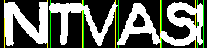

Running tally::: correct: 393 total: 402 accuracy: 0.978 avgEditDist 0.022
special window 76 92 ['I 0.99 ', 'B 0.79 ', 'V 0.67 ', 'S 0.03 ', 'J 0.03 ']
New example, correct answers:
VBIV
[4, 41, 76, 86]
[45, 78, 88, 129]
model 3: VBIV 0.676
[0, 44, 76, 88]
[44, 76, 92, 132]
edit distance: 0


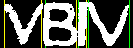

Running tally::: correct: 394 total: 403 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SUE
[4, 43, 80]
[45, 81, 112]
model 3: SUE 0.752
[0, 40, 80]
[40, 80, 112]
edit distance: 0


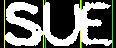

Running tally::: correct: 395 total: 404 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SDNV
[4, 39, 76, 119]
[41, 78, 120, 163]
model 3: SDNV 0.651
[0, 40, 76, 120]
[40, 76, 120, 164]
edit distance: 0


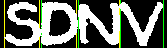

Running tally::: correct: 396 total: 405 accuracy: 0.978 avgEditDist 0.022
special window 64 80 ['I 1.00 ', 'D 0.83 ', 'T 0.59 ', 'O 0.05 ', 'V 0.05 ']
New example, correct answers:
LOIT
[4, 27, 67, 77]
[36, 69, 79, 123]
model 3: LOIT 0.641
[0, 32, 64, 80]
[32, 68, 80, 124]
edit distance: 0


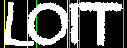

Running tally::: correct: 397 total: 406 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
DTAOL
[4, 38, 71, 114, 152]
[39, 77, 122, 154, 186]
model 3: DTAOL 0.496
[0, 36, 76, 116, 152]
[36, 76, 116, 152, 188]
edit distance: 0


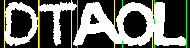

Running tally::: correct: 398 total: 407 accuracy: 0.978 avgEditDist 0.022
special window 36 44 ['L 0.99 ', 'R 0.92 ', 'T 0.04 ', 'V 0.02 ', 'Y 0.01 ']
New example, correct answers:
RLOW
[4, 37, 69, 111]
[39, 74, 113, 170]
model 3: RLOW 0.656
[0, 40, 72, 112]
[36, 72, 112, 172]
edit distance: 0


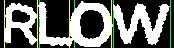

Running tally::: correct: 399 total: 408 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ER
[4, 40]
[42, 79]
model 3: ER 0.814
[0, 40]
[40, 80]
edit distance: 0


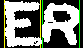

Running tally::: correct: 400 total: 409 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
CRELPN
[4, 40, 77, 111, 143, 176]
[42, 78, 113, 145, 179, 214]
model 3: CRELPN 0.500
[0, 40, 80, 112, 144, 176]
[40, 80, 112, 144, 176, 216]
edit distance: 0


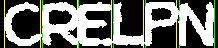

Running tally::: correct: 401 total: 410 accuracy: 0.978 avgEditDist 0.022
special window 72 80 ['F 0.99 ', 'N 0.97 ', 'I 0.09 ', 'H 0.01 ', 'L 0.01 ']
New example, correct answers:
UNPA
[4, 39, 76, 111]
[41, 78, 118, 150]
model 3: UNPA 0.605
[0, 40, 80, 116]
[40, 76, 116, 152]
edit distance: 0


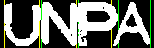

Running tally::: correct: 402 total: 411 accuracy: 0.978 avgEditDist 0.022
special window 40 48 ['S 0.88 ', 'N 0.85 ', 'V 0.13 ', 'J 0.03 ', 'Y 0.02 ']
New example, correct answers:
NSN
[4, 44, 80]
[46, 82, 125]
model 3: NSN 0.723
[0, 48, 80]
[44, 80, 128]
edit distance: 0


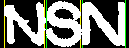

Running tally::: correct: 403 total: 412 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ORO
[4, 45, 77]
[46, 80, 122]
model 3: ORO 0.696
[0, 44, 80]
[44, 80, 124]
edit distance: 0


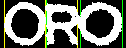

Running tally::: correct: 404 total: 413 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LTSETF
[4, 40, 81, 114, 148, 183]
[43, 84, 116, 150, 185, 215]
model 3: LTSETF 0.504
[0, 40, 80, 116, 148, 184]
[40, 80, 116, 148, 184, 216]
edit distance: 0


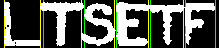

Running tally::: correct: 405 total: 414 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
BK
[4, 36]
[39, 73]
model 3: BK 0.813
[0, 36]
[36, 76]
edit distance: 0


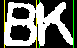

Running tally::: correct: 406 total: 415 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
TN
[4, 44]
[46, 85]
model 3: TN 0.808
[0, 44]
[44, 88]
edit distance: 0


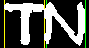

Running tally::: correct: 407 total: 416 accuracy: 0.978 avgEditDist 0.022
special window 140 156 ['I 0.99 ', 'C 0.79 ', 'N 0.76 ', 'W 0.12 ', 'D 0.12 ']
New example, correct answers:
LLRNID
[4, 40, 77, 110, 146, 155]
[45, 80, 112, 148, 156, 191]
model 3: LLRNID 0.558
[0, 40, 80, 112, 140, 156]
[40, 80, 112, 144, 156, 192]
edit distance: 0


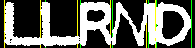

Running tally::: correct: 408 total: 417 accuracy: 0.978 avgEditDist 0.022
special window 80 96 ['I 1.00 ', 'C 0.88 ', 'P 0.86 ', 'O 0.04 ', 'M 0.01 ']
New example, correct answers:
APIOPL
[4, 44, 85, 92, 135, 166]
[49, 86, 95, 136, 168, 205]
model 3: APIOHL 0.552
[0, 44, 80, 96, 136, 168]
[44, 80, 96, 136, 168, 208]
edit distance: 1
-----------------------------------------------------------------------------


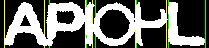

Running tally::: correct: 408 total: 418 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
EVWS
[4, 39, 72, 127]
[42, 74, 128, 165]
model 3: EVWS 0.647
[0, 40, 80, 128]
[40, 84, 128, 168]
edit distance: 0


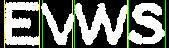

Running tally::: correct: 409 total: 419 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
KM
[4, 40]
[42, 93]
model 3: KM 0.825
[0, 40]
[40, 96]
edit distance: 0


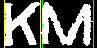

Running tally::: correct: 410 total: 420 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
ATS
[4, 42, 81]
[43, 87, 120]
model 3: ATS 0.706
[0, 44, 84]
[44, 84, 120]
edit distance: 0


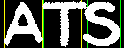

Running tally::: correct: 411 total: 421 accuracy: 0.976 avgEditDist 0.024
special window 0 12 ['I 1.00 ', 'R 0.75 ', 'F 0.27 ', 'V 0.17 ', 'H 0.05 ']
special window 80 88 ['D 0.92 ', 'N 0.82 ', 'C 0.30 ', 'L 0.09 ', 'T 0.04 ']
New example, correct answers:
IRNDOH
[4, 13, 46, 84, 123, 153]
[15, 47, 85, 124, 157, 194]
model 3: IRNDOH 0.596
[0, 12, 44, 84, 120, 156]
[12, 44, 80, 120, 156, 196]
edit distance: 0


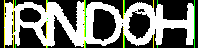

Running tally::: correct: 412 total: 422 accuracy: 0.976 avgEditDist 0.024
special window 72 80 ['I 1.00 ', 'S 0.87 ', 'N 0.68 ', 'M 0.18 ', 'V 0.04 ']
special window 112 124 ['N 0.98 ', 'V 0.62 ', 'T 0.01 ', 'Y 0.01 ', 'W 0.01 ']
special window 168 176 ['L 0.99 ', 'V 0.71 ', 'J 0.02 ', 'T 0.02 ', 'Y 0.01 ']
New example, correct answers:
SSINVL
[4, 39, 73, 80, 118, 167]
[41, 74, 82, 120, 169, 210]
model 3: SSINVL 0.607
[0, 40, 72, 80, 124, 172]
[44, 72, 80, 116, 168, 212]
edit distance: 0


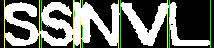

Running tally::: correct: 413 total: 423 accuracy: 0.976 avgEditDist 0.024
special window 40 56 ['I 1.00 ', 'N 0.78 ', 'M 0.52 ', 'H 0.01 ', 'A 0.01 ']
special window 104 112 ['C 0.98 ', 'M 0.56 ', 'A 0.03 ', 'N 0.03 ', 'T 0.02 ']
New example, correct answers:
NIMO
[4, 45, 54, 108]
[47, 56, 109, 152]
model 3: NIMO 0.737
[0, 40, 56, 112]
[44, 56, 104, 152]
edit distance: 0


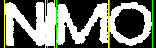

Running tally::: correct: 414 total: 424 accuracy: 0.976 avgEditDist 0.024
special window 120 128 ['N 0.97 ', 'V 0.11 ', 'T 0.10 ', 'L 0.04 ', 'Y 0.03 ']
New example, correct answers:
VAN
[4, 47, 89]
[49, 91, 128]
model 3: VAN 0.743
[0, 48, 88]
[48, 88, 124]
edit distance: 0


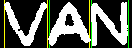

Running tally::: correct: 415 total: 425 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['I 0.98 ', 'V 0.36 ', 'J 0.12 ', 'T 0.12 ', 'W 0.08 ']
New example, correct answers:
IWBDE
[4, 10, 61, 95, 132]
[16, 65, 96, 133, 171]
model 3: IWBDE 0.603
[0, 16, 64, 96, 132]
[8, 64, 96, 132, 172]
edit distance: 0


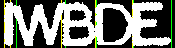

Running tally::: correct: 416 total: 426 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['I 1.00 ', 'E 0.98 ', 'V 0.17 ', 'T 0.06 ', 'L 0.06 ']
New example, correct answers:
IEALE
[4, 13, 45, 82, 119]
[15, 46, 86, 122, 157]
model 3: IEALE 0.694
[0, 12, 44, 84, 120]
[12, 44, 84, 120, 160]
edit distance: 0


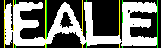

Running tally::: correct: 417 total: 427 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NPAKR
[4, 44, 78, 112, 148]
[47, 80, 113, 149, 186]
model 3: NPAKR 0.543
[0, 44, 80, 116, 148]
[44, 80, 116, 148, 188]
edit distance: 0


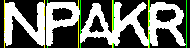

Running tally::: correct: 418 total: 428 accuracy: 0.977 avgEditDist 0.023
special window 184 196 ['A 0.90 ', 'H 0.88 ', 'I 0.01 ', 'M 0.01 ', 'P 0.01 ']
New example, correct answers:
RHTEHA
[4, 34, 72, 110, 146, 191]
[37, 73, 113, 148, 192, 232]
model 3: RHTEHA 0.527
[0, 36, 72, 112, 148, 192]
[36, 72, 112, 148, 188, 232]
edit distance: 0


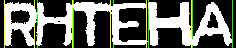

Running tally::: correct: 419 total: 429 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OTE
[4, 36, 81]
[44, 83, 119]
model 3: OTE 0.673
[0, 40, 84]
[40, 84, 120]
edit distance: 0


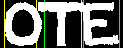

Running tally::: correct: 420 total: 430 accuracy: 0.977 avgEditDist 0.023
special window 40 48 ['R 0.99 ', 'C 0.86 ', 'T 0.02 ', 'L 0.02 ', 'V 0.02 ']
New example, correct answers:
CRESAK
[4, 43, 81, 108, 139, 174]
[46, 82, 113, 140, 176, 215]
model 3: CRESAK 0.510
[0, 44, 80, 108, 140, 176]
[40, 80, 112, 140, 176, 216]
edit distance: 0


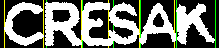

Running tally::: correct: 421 total: 431 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
AE
[4, 41]
[45, 73]
model 3: AE 0.774
[0, 44]
[44, 76]
edit distance: 0


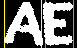

Running tally::: correct: 422 total: 432 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['T 0.96 ', 'H 0.77 ', 'A 0.04 ', 'V 0.03 ', 'M 0.01 ']
New example, correct answers:
HTES
[4, 40, 76, 109]
[43, 78, 114, 145]
model 3: HTES 0.615
[0, 44, 80, 112]
[40, 80, 112, 148]
edit distance: 0


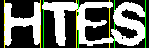

Running tally::: correct: 423 total: 433 accuracy: 0.977 avgEditDist 0.023
special window 104 112 ['E 1.00 ', 'V 0.02 ', 'T 0.02 ', 'A 0.02 ', 'L 0.02 ']
New example, correct answers:
TFEE
[4, 38, 70, 102]
[40, 72, 104, 146]
model 3: TFEE 0.630
[0, 40, 72, 108]
[40, 72, 104, 148]
edit distance: 0


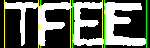

Running tally::: correct: 424 total: 434 accuracy: 0.977 avgEditDist 0.023
special window 32 48 ['E 0.99 ', 'I 0.98 ', 'W 0.62 ', 'V 0.05 ', 'U 0.02 ']
New example, correct answers:
EIWVA
[4, 34, 44, 93, 136]
[38, 46, 95, 140, 181]
model 3: EIWVA 0.610
[0, 32, 48, 96, 136]
[36, 48, 96, 136, 184]
edit distance: 0


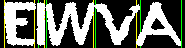

Running tally::: correct: 425 total: 435 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.98 ', 'V 0.10 ', 'T 0.09 ', 'L 0.05 ', 'Y 0.04 ']
New example, correct answers:
EA
[4, 44]
[47, 94]
model 3: EA 0.728
[8, 48]
[48, 96]
edit distance: 0


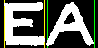

Running tally::: correct: 426 total: 436 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['I 1.00 ', 'H 0.94 ', 'V 0.16 ', 'F 0.05 ', 'J 0.05 ']
New example, correct answers:
IHR
[4, 14, 54]
[16, 56, 103]
model 3: IHR 0.788
[0, 16, 56]
[16, 56, 104]
edit distance: 0


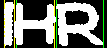

Running tally::: correct: 427 total: 437 accuracy: 0.977 avgEditDist 0.023
special window 36 52 ['I 1.00 ', 'E 0.83 ', 'V 0.63 ', 'Y 0.01 ', 'T 0.01 ']
New example, correct answers:
EIVLTT
[4, 36, 46, 91, 114, 147]
[39, 48, 92, 123, 149, 193]
model 3: EIVLTT 0.487
[0, 36, 52, 88, 116, 148]
[36, 52, 88, 116, 152, 196]
edit distance: 0


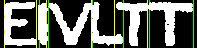

Running tally::: correct: 428 total: 438 accuracy: 0.977 avgEditDist 0.023
special window 124 132 ['R 0.99 ', 'V 0.61 ', 'Y 0.01 ', 'W 0.01 ', 'L 0.01 ']
New example, correct answers:
NRVRNW
[4, 44, 79, 124, 162, 202]
[46, 82, 126, 163, 204, 255]
model 3: NRVRNW 0.542
[0, 44, 80, 128, 164, 204]
[44, 80, 124, 164, 204, 256]
edit distance: 0


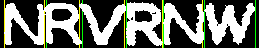

Running tally::: correct: 429 total: 439 accuracy: 0.977 avgEditDist 0.023
special window 148 156 ['B 1.00 ', 'T 0.70 ', 'V 0.05 ', 'L 0.02 ', 'A 0.01 ']
New example, correct answers:
RORTBD
[4, 36, 72, 105, 149, 184]
[42, 74, 107, 151, 185, 224]
model 3: RORTBD 0.504
[0, 40, 76, 108, 152, 184]
[40, 76, 108, 148, 184, 224]
edit distance: 0


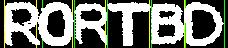

Running tally::: correct: 430 total: 440 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
AWA
[4, 36, 89]
[46, 96, 131]
model 3: AWA 0.581
[0, 40, 92]
[40, 92, 132]
edit distance: 0


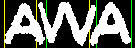

Running tally::: correct: 431 total: 441 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
VERL
[4, 37, 73, 111]
[40, 75, 113, 152]
model 3: VERL 0.630
[0, 40, 76, 112]
[40, 76, 112, 152]
edit distance: 0


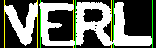

Running tally::: correct: 432 total: 442 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
KHESL
[4, 44, 79, 109, 145]
[46, 80, 113, 149, 185]
model 3: KHESL 0.611
[0, 44, 80, 112, 148]
[44, 80, 112, 148, 188]
edit distance: 0


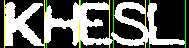

Running tally::: correct: 433 total: 443 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SG
[4, 35]
[38, 76]
model 3: SG 0.824
[0, 36]
[36, 76]
edit distance: 0


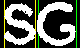

Running tally::: correct: 434 total: 444 accuracy: 0.977 avgEditDist 0.023
special window 108 116 ['M 0.96 ', 'V 0.01 ', 'T 0.01 ', 'H 0.01 ', 'W 0.01 ']
special window 156 164 ['M 0.76 ', 'V 0.44 ', 'W 0.33 ', 'U 0.04 ', 'T 0.01 ']
New example, correct answers:
HDMMW
[4, 39, 72, 113, 161]
[40, 74, 114, 163, 219]
model 3: HDMMW 0.600
[0, 40, 72, 116, 164]
[40, 72, 112, 160, 220]
edit distance: 0


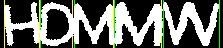

Running tally::: correct: 435 total: 445 accuracy: 0.978 avgEditDist 0.022
special window 184 200 ['I 0.99 ', 'E 0.98 ', 'V 0.22 ', 'T 0.09 ', 'L 0.05 ']
New example, correct answers:
TCTEEI
[4, 40, 76, 123, 158, 188]
[46, 79, 124, 159, 190, 198]
model 3: TCTEEI 0.534
[0, 44, 80, 124, 152, 184]
[44, 80, 124, 156, 188, 200]
edit distance: 0


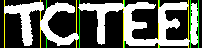

Running tally::: correct: 436 total: 446 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LATSE
[4, 30, 73, 117, 151]
[33, 75, 120, 152, 187]
model 3: LATSE 0.502
[0, 36, 76, 116, 152]
[36, 76, 116, 152, 188]
edit distance: 0


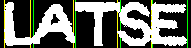

Running tally::: correct: 437 total: 447 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SEV
[4, 43, 77]
[45, 79, 118]
model 3: SEV 0.672
[0, 40, 76]
[40, 76, 120]
edit distance: 0


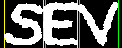

Running tally::: correct: 438 total: 448 accuracy: 0.978 avgEditDist 0.022
special window 76 88 ['E 0.99 ', 'H 0.98 ', 'G 0.01 ', 'N 0.01 ', 'V 0.01 ']
New example, correct answers:
GHEA
[4, 44, 84, 119]
[46, 85, 120, 159]
model 3: GHEA 0.692
[0, 44, 88, 120]
[44, 80, 120, 160]
edit distance: 0


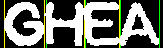

Running tally::: correct: 439 total: 449 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
GGVH
[4, 41, 79, 123]
[43, 87, 124, 159]
model 3: GGVH 0.622
[0, 36, 84, 124]
[40, 84, 124, 160]
edit distance: 0


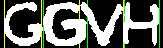

Running tally::: correct: 440 total: 450 accuracy: 0.978 avgEditDist 0.022
special window 36 52 ['I 0.99 ', 'L 0.92 ', 'T 0.87 ', 'A 0.01 ', 'E 0.01 ']
special window 88 104 ['I 1.00 ', 'L 0.94 ', 'T 0.85 ', 'A 0.01 ', 'V 0.01 ']
New example, correct answers:
LITILE
[4, 39, 46, 92, 102, 137]
[41, 51, 94, 103, 139, 169]
model 3: LITILE 0.658
[0, 36, 52, 88, 104, 136]
[40, 52, 92, 104, 136, 172]
edit distance: 0


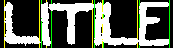

Running tally::: correct: 441 total: 451 accuracy: 0.978 avgEditDist 0.022
special window 116 132 ['I 1.00 ', 'G 0.81 ', 'A 0.78 ', 'H 0.03 ', 'L 0.01 ']
New example, correct answers:
AAGIAO
[4, 43, 79, 120, 129, 168]
[46, 81, 122, 131, 170, 209]
model 3: AAGIAO 0.556
[0, 40, 80, 116, 132, 168]
[44, 80, 120, 132, 168, 212]
edit distance: 0


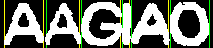

Running tally::: correct: 442 total: 452 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
EALDBR
[4, 39, 78, 109, 144, 178]
[42, 80, 111, 145, 181, 215]
model 3: EALDBR 0.524
[0, 40, 80, 112, 144, 180]
[40, 80, 112, 144, 180, 216]
edit distance: 0


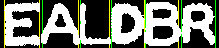

Running tally::: correct: 443 total: 453 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RL
[4, 39]
[44, 70]
model 3: RL 0.779
[0, 40]
[40, 72]
edit distance: 0


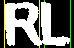

Running tally::: correct: 444 total: 454 accuracy: 0.978 avgEditDist 0.022
special window 36 52 ['I 1.00 ', 'L 0.92 ', 'P 0.74 ', 'G 0.02 ', 'V 0.02 ']
New example, correct answers:
PILEUC
[4, 41, 50, 89, 125, 161]
[43, 51, 91, 127, 162, 200]
model 3: PILEUC 0.557
[0, 36, 52, 88, 124, 160]
[40, 52, 88, 124, 160, 200]
edit distance: 0


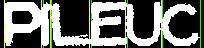

Running tally::: correct: 445 total: 455 accuracy: 0.978 avgEditDist 0.022
special window 72 88 ['I 1.00 ', 'E 0.98 ', 'C 0.78 ', 'V 0.01 ', 'J 0.01 ']
New example, correct answers:
ECIERE
[4, 35, 76, 87, 113, 147]
[39, 77, 88, 114, 149, 185]
model 3: ECIERE 0.512
[0, 36, 72, 88, 112, 148]
[36, 72, 88, 116, 148, 188]
edit distance: 0


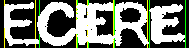

Running tally::: correct: 446 total: 456 accuracy: 0.978 avgEditDist 0.022
special window 84 92 ['A 0.88 ', 'M 0.68 ', 'N 0.02 ', 'I 0.01 ', 'T 0.01 ']
New example, correct answers:
RMAHNL
[4, 39, 86, 130, 167, 205]
[41, 87, 132, 168, 207, 247]
model 3: RMAHNL 0.539
[0, 40, 92, 132, 168, 208]
[40, 84, 132, 168, 208, 248]
edit distance: 0


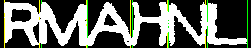

Running tally::: correct: 447 total: 457 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
UODOS
[4, 41, 82, 119, 162]
[43, 84, 121, 163, 198]
model 3: UODOS 0.572
[0, 40, 80, 116, 164]
[40, 80, 120, 164, 200]
edit distance: 0


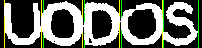

Running tally::: correct: 448 total: 458 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
OAD
[4, 39, 74]
[42, 76, 113]
model 3: OAD 0.714
[0, 40, 76]
[40, 76, 116]
edit distance: 0


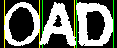

Running tally::: correct: 449 total: 459 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['L 0.98 ', 'T 0.11 ', 'V 0.11 ', 'J 0.03 ', 'Y 0.03 ']
New example, correct answers:
LAOW
[4, 41, 84, 127]
[44, 86, 130, 181]
model 3: LAOW 0.650
[8, 44, 84, 128]
[44, 84, 128, 184]
edit distance: 0


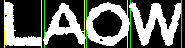

Running tally::: correct: 450 total: 460 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AKNDOT
[4, 44, 78, 122, 154, 190]
[47, 80, 123, 156, 195, 234]
model 3: AKNDOT 0.525
[0, 44, 80, 120, 156, 192]
[44, 80, 120, 156, 192, 236]
edit distance: 0


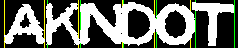

Running tally::: correct: 451 total: 461 accuracy: 0.978 avgEditDist 0.022
special window 120 136 ['I 0.99 ', 'R 0.96 ', 'T 0.10 ', 'V 0.08 ', 'L 0.04 ']
New example, correct answers:
ORRI
[4, 45, 87, 122]
[47, 88, 124, 133]
model 3: ORRI 0.699
[0, 48, 88, 120]
[48, 88, 120, 136]
edit distance: 0


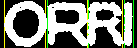

Running tally::: correct: 452 total: 462 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
DSAN
[4, 35, 68, 105]
[38, 70, 107, 151]
model 3: DSAN 0.656
[0, 36, 68, 108]
[36, 68, 108, 152]
edit distance: 0


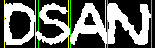

Running tally::: correct: 453 total: 463 accuracy: 0.978 avgEditDist 0.022
special window 0 12 ['L 0.98 ', 'V 0.11 ', 'T 0.10 ', 'J 0.04 ', 'Y 0.03 ']
special window 88 96 ['M 0.77 ', 'N 0.67 ', 'I 0.32 ', 'V 0.12 ', 'T 0.02 ']
special window 128 136 ['C 0.97 ', 'N 0.74 ', 'V 0.28 ', 'T 0.04 ', 'Y 0.02 ']
New example, correct answers:
LMNOC
[4, 44, 93, 131, 170]
[47, 95, 133, 172, 209]
model 3: LMNOC 0.540
[8, 44, 96, 136, 172]
[48, 88, 132, 172, 212]
edit distance: 0


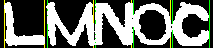

Running tally::: correct: 454 total: 464 accuracy: 0.978 avgEditDist 0.022
special window 36 52 ['I 1.00 ', 'L 0.95 ', 'C 0.95 ', 'V 0.01 ', 'A 0.01 ']
New example, correct answers:
CIL
[4, 43, 48]
[44, 52, 87]
model 3: CIL 0.776
[0, 36, 52]
[40, 52, 88]
edit distance: 0


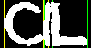

Running tally::: correct: 455 total: 465 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
TRRD
[4, 45, 77, 117]
[46, 79, 119, 153]
model 3: TRRD 0.677
[0, 44, 76, 116]
[44, 80, 116, 156]
edit distance: 0


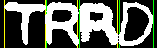

Running tally::: correct: 456 total: 466 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RTTFT
[4, 38, 71, 105, 147]
[40, 72, 107, 149, 196]
model 3: RTTFT 0.518
[0, 40, 72, 108, 148]
[40, 76, 108, 148, 196]
edit distance: 0


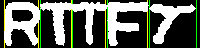

Running tally::: correct: 457 total: 467 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RVT
[4, 34, 71]
[36, 73, 115]
model 3: RVT 0.749
[0, 36, 72]
[36, 72, 116]
edit distance: 0


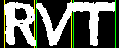

Running tally::: correct: 458 total: 468 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VT
[4, 42]
[44, 81]
model 3: VT 0.817
[0, 40]
[40, 84]
edit distance: 0


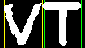

Running tally::: correct: 459 total: 469 accuracy: 0.979 avgEditDist 0.021
special window 0 16 ['N 0.99 ', 'V 0.20 ', 'T 0.07 ', 'L 0.04 ', 'J 0.02 ']
New example, correct answers:
NDL
[4, 43, 85]
[46, 87, 121]
model 3: NDL 0.689
[12, 48, 84]
[48, 84, 124]
edit distance: 0


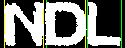

Running tally::: correct: 460 total: 470 accuracy: 0.979 avgEditDist 0.021
special window 36 48 ['I 1.00 ', 'F 0.88 ', 'P 0.78 ', 'R 0.33 ', 'V 0.03 ']
New example, correct answers:
PIRL
[4, 39, 47, 82]
[43, 48, 84, 119]
model 3: PIRL 0.762
[0, 36, 48, 84]
[40, 48, 84, 120]
edit distance: 0


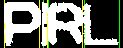

Running tally::: correct: 461 total: 471 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RV
[4, 33]
[39, 71]
model 3: RV 0.764
[0, 36]
[36, 72]
edit distance: 0


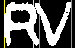

Running tally::: correct: 462 total: 472 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
GLA
[4, 43, 79]
[45, 81, 125]
model 3: GLA 0.748
[0, 44, 80]
[44, 80, 128]
edit distance: 0


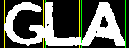

Running tally::: correct: 463 total: 473 accuracy: 0.979 avgEditDist 0.021
special window 80 88 ['N 0.92 ', 'F 0.88 ', 'R 0.18 ', 'V 0.03 ', 'P 0.01 ']
New example, correct answers:
SNRSW
[4, 43, 86, 122, 156]
[46, 87, 124, 157, 207]
model 3: SNRSW 0.626
[0, 44, 88, 124, 156]
[44, 84, 124, 156, 208]
edit distance: 0


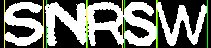

Running tally::: correct: 464 total: 474 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
PSS
[4, 33, 64]
[36, 67, 107]
model 3: PSS 0.722
[0, 36, 68]
[36, 68, 108]
edit distance: 0


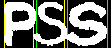

Running tally::: correct: 465 total: 475 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
TM
[4, 38]
[41, 85]
model 3: TM 0.791
[0, 40]
[40, 88]
edit distance: 0


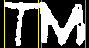

Running tally::: correct: 466 total: 476 accuracy: 0.979 avgEditDist 0.021
special window 160 168 ['F 0.99 ', 'N 0.88 ', 'V 0.04 ', 'L 0.01 ', 'U 0.01 ']
New example, correct answers:
AOLNF
[4, 42, 83, 120, 164]
[46, 85, 122, 166, 204]
model 3: AOLNF 0.563
[0, 44, 84, 120, 168]
[44, 84, 120, 160, 204]
edit distance: 0


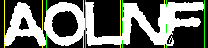

Running tally::: correct: 467 total: 477 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
MVRWGR
[4, 51, 88, 127, 178, 214]
[54, 91, 129, 179, 216, 248]
model 3: MVRWGR 0.562
[0, 52, 88, 128, 180, 216]
[52, 88, 128, 180, 216, 248]
edit distance: 0


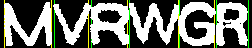

Running tally::: correct: 468 total: 478 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
TLE
[4, 43, 78]
[44, 79, 117]
model 3: TLE 0.725
[0, 44, 80]
[44, 80, 120]
edit distance: 0


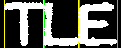

Running tally::: correct: 469 total: 479 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['N 0.89 ', 'V 0.17 ', 'J 0.05 ', 'T 0.05 ', 'Y 0.03 ']
special window 40 48 ['N 0.98 ', 'V 0.01 ', 'T 0.01 ', 'A 0.00 ', 'Y 0.00 ']
special window 80 88 ['N 0.85 ', 'V 0.35 ', 'T 0.08 ', 'Y 0.03 ', 'J 0.03 ']
New example, correct answers:
NN
[4, 47]
[49, 88]
model 3: NN 0.799
[4, 48]
[44, 84]
edit distance: 0


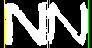

Running tally::: correct: 470 total: 480 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
SEN
[4, 38, 78]
[40, 80, 124]
model 3: SEN 0.721
[0, 40, 80]
[40, 80, 124]
edit distance: 0


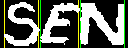

Running tally::: correct: 471 total: 481 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
EK
[4, 35]
[38, 73]
model 3: EK 0.804
[0, 36]
[36, 76]
edit distance: 0


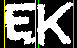

Running tally::: correct: 472 total: 482 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
WU
[4, 55]
[60, 96]
model 3: WU 0.812
[0, 56]
[56, 96]
edit distance: 0


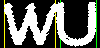

Running tally::: correct: 473 total: 483 accuracy: 0.979 avgEditDist 0.021
special window 0 16 ['I 1.00 ', 'A 0.92 ', 'V 0.12 ', 'L 0.04 ', 'T 0.03 ']
New example, correct answers:
IAHMOP
[4, 15, 51, 89, 134, 173]
[17, 54, 90, 135, 176, 213]
model 3: IAHMOP 0.570
[0, 16, 52, 88, 136, 176]
[16, 52, 88, 136, 176, 216]
edit distance: 0


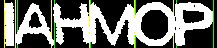

Running tally::: correct: 474 total: 484 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
SDLNSO
[4, 38, 73, 101, 144, 179]
[39, 75, 104, 146, 180, 223]
model 3: SDLNSO 0.493
[0, 36, 72, 104, 144, 180]
[36, 72, 104, 144, 180, 224]
edit distance: 0


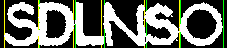

Running tally::: correct: 475 total: 485 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RAODH
[4, 41, 85, 131, 163]
[43, 87, 132, 165, 202]
model 3: RAODH 0.564
[0, 40, 84, 128, 164]
[40, 84, 128, 164, 204]
edit distance: 0


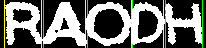

Running tally::: correct: 476 total: 486 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
NSRG
[4, 41, 76, 108]
[43, 79, 109, 148]
model 3: NSRG 0.636
[0, 44, 76, 108]
[44, 76, 108, 148]
edit distance: 0


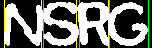

Running tally::: correct: 477 total: 487 accuracy: 0.979 avgEditDist 0.021
special window 100 116 ['I 1.00 ', 'P 0.96 ', 'F 0.94 ', 'A 0.02 ', 'H 0.01 ']
New example, correct answers:
KEPIP
[4, 39, 73, 104, 115]
[41, 74, 106, 116, 153]
model 3: KEPIP 0.628
[0, 40, 72, 100, 116]
[40, 72, 104, 116, 156]
edit distance: 0


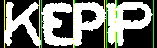

Running tally::: correct: 478 total: 488 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
FAEPOM
[4, 32, 71, 101, 140, 179]
[42, 72, 102, 141, 182, 228]
model 3: FAEPOM 0.458
[0, 36, 68, 104, 140, 180]
[36, 68, 104, 140, 180, 228]
edit distance: 0


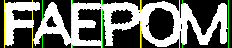

Running tally::: correct: 479 total: 489 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
SDEH
[4, 40, 76, 106]
[42, 78, 108, 150]
model 3: SDEH 0.667
[0, 40, 76, 108]
[40, 76, 108, 152]
edit distance: 0


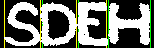

Running tally::: correct: 480 total: 490 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
SWE
[4, 33, 83]
[43, 84, 116]
model 3: SWE 0.721
[0, 40, 84]
[40, 84, 116]
edit distance: 0


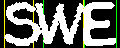

Running tally::: correct: 481 total: 491 accuracy: 0.980 avgEditDist 0.020
special window 44 52 ['I 1.00 ', 'T 0.93 ', 'E 0.26 ', 'F 0.13 ', 'V 0.02 ']
New example, correct answers:
SITE
[4, 41, 50, 77]
[45, 51, 79, 111]
model 3: RITE 0.491
[0, 44, 52, 80]
[44, 52, 84, 112]
edit distance: 1
-----------------------------------------------------------------------------


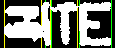

Running tally::: correct: 481 total: 492 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ADV
[4, 42, 73]
[44, 78, 118]
model 3: ADV 0.706
[0, 44, 76]
[44, 76, 120]
edit distance: 0


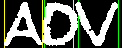

Running tally::: correct: 482 total: 493 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LAGCN
[4, 41, 83, 122, 163]
[42, 87, 124, 166, 205]
model 3: LAGCN 0.586
[0, 40, 84, 124, 164]
[40, 84, 124, 164, 208]
edit distance: 0


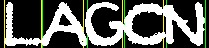

Running tally::: correct: 483 total: 494 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
UEOAW
[4, 41, 71, 112, 147]
[43, 74, 113, 156, 203]
model 3: UEOAW 0.516
[0, 40, 72, 108, 152]
[40, 72, 108, 152, 204]
edit distance: 0


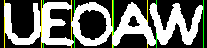

Running tally::: correct: 484 total: 495 accuracy: 0.978 avgEditDist 0.022
special window 144 156 ['I 1.00 ', 'T 0.98 ', 'L 0.92 ', 'A 0.02 ', 'V 0.01 ']
New example, correct answers:
TORTIL
[4, 41, 81, 111, 146, 154]
[45, 82, 115, 148, 156, 189]
model 3: TOHTIL 0.338
[0, 44, 80, 108, 144, 156]
[44, 80, 108, 148, 156, 192]
edit distance: 1
-----------------------------------------------------------------------------


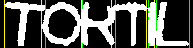

Running tally::: correct: 484 total: 496 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['R 0.98 ', 'V 0.14 ', 'J 0.10 ', 'T 0.06 ', 'L 0.05 ']
New example, correct answers:
REDDAN
[4, 40, 71, 103, 138, 178]
[44, 73, 104, 139, 183, 218]
model 3: REDDAN 0.530
[4, 40, 72, 108, 140, 180]
[40, 72, 112, 140, 180, 220]
edit distance: 0


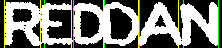

Running tally::: correct: 485 total: 497 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RS
[4, 41]
[48, 79]
model 3: RS 0.831
[0, 44]
[44, 80]
edit distance: 0


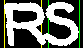

Running tally::: correct: 486 total: 498 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SU
[4, 39]
[41, 80]
model 3: SU 0.802
[0, 40]
[40, 80]
edit distance: 0


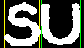

Running tally::: correct: 487 total: 499 accuracy: 0.976 avgEditDist 0.024
special window 80 88 ['F 0.83 ', 'M 0.69 ', 'I 0.63 ', 'R 0.24 ', 'P 0.02 ']
special window 156 164 ['N 0.98 ', 'F 0.56 ', 'P 0.17 ', 'V 0.04 ', 'R 0.03 ']
New example, correct answers:
LMRNP
[4, 36, 87, 124, 160]
[40, 88, 125, 162, 200]
model 3: LMIRNP 0.584
[0, 40, 80, 88, 124, 164]
[40, 84, 88, 124, 160, 200]
edit distance: 1
-----------------------------------------------------------------------------


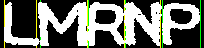

Running tally::: correct: 487 total: 500 accuracy: 0.974 avgEditDist 0.026
special window 80 88 ['E 1.00 ', 'D 0.82 ', 'V 0.04 ', 'O 0.03 ', 'T 0.01 ']
New example, correct answers:
OOE
[4, 42, 82]
[44, 84, 121]
model 3: OOE 0.733
[0, 40, 84]
[44, 80, 124]
edit distance: 0


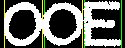

Running tally::: correct: 488 total: 501 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
LOSLD
[4, 38, 78, 113, 145]
[41, 79, 115, 146, 189]
model 3: LOSLD 0.546
[0, 40, 80, 112, 148]
[40, 80, 112, 148, 192]
edit distance: 0


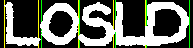

Running tally::: correct: 489 total: 502 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
NOP
[4, 44, 88]
[46, 89, 124]
model 3: NOP 0.698
[0, 44, 88]
[44, 88, 124]
edit distance: 0


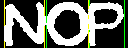

Running tally::: correct: 490 total: 503 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
EN
[4, 39]
[41, 79]
model 3: EN 0.803
[0, 40]
[40, 80]
edit distance: 0


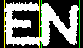

Running tally::: correct: 491 total: 504 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
SL
[4, 38]
[39, 76]
model 3: SL 0.810
[0, 40]
[40, 76]
edit distance: 0


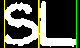

Running tally::: correct: 492 total: 505 accuracy: 0.974 avgEditDist 0.026
special window 76 84 ['S 0.97 ', 'D 0.54 ', 'L 0.12 ', 'T 0.08 ', 'C 0.07 ']
special window 120 128 ['R 0.99 ', 'D 0.78 ', 'V 0.03 ', 'T 0.02 ', 'O 0.02 ']
New example, correct answers:
ESDRS
[4, 39, 77, 121, 157]
[41, 79, 122, 161, 192]
model 3: ESDRS 0.590
[0, 40, 84, 124, 156]
[40, 76, 120, 156, 192]
edit distance: 0


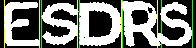

Running tally::: correct: 493 total: 506 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
DBEK
[4, 38, 74, 107]
[40, 75, 109, 143]
model 3: DBEK 0.642
[0, 36, 72, 108]
[40, 72, 108, 144]
edit distance: 0


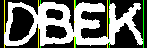

Running tally::: correct: 494 total: 507 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
CTSTE
[4, 40, 72, 106, 147]
[42, 77, 108, 150, 181]
model 3: CTSTE 0.434
[0, 40, 76, 108, 148]
[44, 76, 108, 148, 184]
edit distance: 0


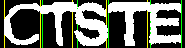

Running tally::: correct: 495 total: 508 accuracy: 0.974 avgEditDist 0.026
New example, correct answers:
HT
[4, 38]
[41, 82]
model 3: HT 0.840
[0, 40]
[40, 84]
edit distance: 0


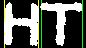

Running tally::: correct: 496 total: 509 accuracy: 0.974 avgEditDist 0.026
special window 0 8 ['E 0.98 ', 'V 0.10 ', 'T 0.09 ', 'L 0.05 ', 'A 0.04 ']
special window 72 88 ['I 1.00 ', 'E 0.96 ', 'S 0.96 ', 'A 0.01 ', 'G 0.01 ']
New example, correct answers:
ESIER
[4, 44, 75, 84, 125]
[46, 76, 86, 126, 161]
model 3: ESIER 0.611
[8, 44, 72, 88, 124]
[44, 76, 88, 124, 164]
edit distance: 0


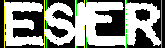

Running tally::: correct: 497 total: 510 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
CTTEES
[4, 39, 72, 117, 147, 175]
[46, 74, 118, 149, 181, 215]
model 3: CTTEES 0.495
[0, 40, 72, 116, 144, 180]
[40, 76, 116, 148, 180, 216]
edit distance: 0


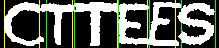

Running tally::: correct: 498 total: 511 accuracy: 0.975 avgEditDist 0.025
special window 76 92 ['I 1.00 ', 'H 0.87 ', 'S 0.76 ', 'E 0.04 ', 'Y 0.02 ']
New example, correct answers:
SHIS
[4, 37, 79, 91]
[39, 82, 92, 130]
model 3: SHIS 0.726
[0, 40, 76, 92]
[40, 76, 92, 132]
edit distance: 0


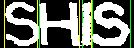

Running tally::: correct: 499 total: 512 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
EAN
[4, 36, 73]
[38, 75, 108]
model 3: EAN 0.669
[0, 36, 76]
[36, 76, 108]
edit distance: 0


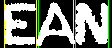

Running tally::: correct: 500 total: 513 accuracy: 0.975 avgEditDist 0.025
special window 72 88 ['E 1.00 ', 'I 0.99 ', 'V 0.01 ', 'M 0.01 ', 'B 0.01 ']
New example, correct answers:
VEIB
[4, 43, 75, 86]
[46, 77, 87, 124]
model 3: VEIB 0.743
[0, 44, 72, 88]
[44, 76, 88, 124]
edit distance: 0


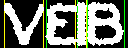

Running tally::: correct: 501 total: 514 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
OOATAT
[4, 47, 85, 124, 155, 197]
[50, 86, 126, 162, 201, 243]
model 3: OOATAT 0.418
[0, 48, 84, 124, 160, 196]
[48, 84, 124, 160, 196, 244]
edit distance: 0


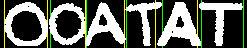

Running tally::: correct: 502 total: 515 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
PV
[4, 36]
[39, 76]
model 3: PV 0.784
[0, 36]
[36, 76]
edit distance: 0


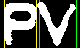

Running tally::: correct: 503 total: 516 accuracy: 0.975 avgEditDist 0.025
special window 208 224 ['I 0.99 ', 'K 0.51 ', 'A 0.13 ', 'V 0.08 ', 'T 0.04 ']
New example, correct answers:
EESWKI
[4, 39, 82, 114, 170, 208]
[42, 83, 116, 172, 210, 221]
model 3: EESWKI 0.589
[0, 40, 80, 116, 172, 208]
[40, 80, 116, 172, 208, 224]
edit distance: 0


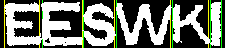

Running tally::: correct: 504 total: 517 accuracy: 0.975 avgEditDist 0.025
special window 0 8 ['D 0.90 ', 'T 0.16 ', 'V 0.14 ', 'C 0.11 ', 'L 0.05 ']
special window 36 44 ['E 1.00 ', 'D 0.94 ', 'A 0.02 ', 'T 0.02 ', 'V 0.01 ']
special window 148 156 ['N 0.86 ', 'A 0.85 ', 'F 0.01 ', 'H 0.01 ', 'J 0.01 ']
New example, correct answers:
DELNAC
[4, 37, 71, 106, 151, 190]
[39, 72, 110, 153, 192, 231]
model 3: DELNAC 0.516
[4, 40, 72, 108, 152, 192]
[36, 72, 108, 148, 192, 232]
edit distance: 0


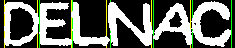

Running tally::: correct: 505 total: 518 accuracy: 0.975 avgEditDist 0.025
special window 36 44 ['H 0.96 ', 'F 0.86 ', 'R 0.18 ', 'P 0.02 ', 'A 0.02 ']
New example, correct answers:
HR
[4, 42]
[43, 80]
model 3: HR 0.845
[0, 44]
[40, 80]
edit distance: 0


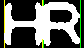

Running tally::: correct: 506 total: 519 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
PPST
[4, 42, 79, 120]
[45, 81, 121, 158]
model 3: PPST 0.641
[0, 36, 80, 120]
[40, 80, 120, 160]
edit distance: 0


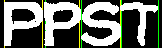

Running tally::: correct: 507 total: 520 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
LODN
[4, 32, 75, 106]
[40, 76, 108, 150]
model 3: LODN 0.644
[0, 36, 76, 108]
[36, 76, 108, 152]
edit distance: 0


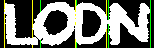

Running tally::: correct: 508 total: 521 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
LCNE
[4, 38, 76, 114]
[42, 77, 115, 147]
model 3: LCNE 0.652
[0, 40, 76, 112]
[40, 76, 112, 148]
edit distance: 0


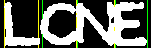

Running tally::: correct: 509 total: 522 accuracy: 0.975 avgEditDist 0.025
New example, correct answers:
SD
[4, 37]
[40, 78]
model 3: SD 0.780
[0, 40]
[40, 80]
edit distance: 0


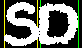

Running tally::: correct: 510 total: 523 accuracy: 0.975 avgEditDist 0.025
special window 0 8 ['R 0.84 ', 'F 0.30 ', 'V 0.18 ', 'T 0.08 ', 'J 0.08 ']
special window 112 120 ['N 0.86 ', 'H 0.75 ', 'F 0.05 ', 'I 0.02 ', 'V 0.02 ']
special window 152 164 ['N 0.83 ', 'H 0.76 ', 'M 0.01 ', 'A 0.01 ', 'I 0.01 ']
special window 196 204 ['A 0.94 ', 'N 0.90 ', 'J 0.01 ', 'L 0.01 ', 'V 0.01 ']
New example, correct answers:
RLNHNA
[4, 34, 72, 116, 159, 202]
[39, 74, 118, 161, 203, 239]
model 3: RLNHNA 0.558
[4, 36, 72, 116, 160, 204]
[36, 72, 112, 156, 200, 240]
edit distance: 0


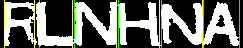

Running tally::: correct: 511 total: 524 accuracy: 0.975 avgEditDist 0.025
special window 112 124 ['N 0.92 ', 'V 0.82 ', 'A 0.01 ', 'J 0.01 ', 'M 0.01 ']
New example, correct answers:
LGVNL
[4, 34, 74, 116, 159]
[39, 77, 118, 161, 194]
model 3: LGVNL 0.541
[0, 36, 76, 120, 160]
[36, 76, 112, 160, 196]
edit distance: 0


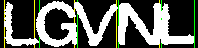

Running tally::: correct: 512 total: 525 accuracy: 0.975 avgEditDist 0.025
special window 0 16 ['I 1.00 ', 'H 0.92 ', 'V 0.20 ', 'J 0.06 ', 'F 0.06 ']
New example, correct answers:
IHB
[4, 14, 56]
[17, 58, 94]
model 3: IHB 0.804
[0, 16, 56]
[16, 56, 96]
edit distance: 0


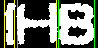

Running tally::: correct: 513 total: 526 accuracy: 0.975 avgEditDist 0.025
special window 40 56 ['I 0.99 ', 'F 0.96 ', 'T 0.09 ', 'V 0.09 ', 'L 0.04 ']
New example, correct answers:
FI
[4, 41]
[44, 53]
model 3: FI 0.865
[0, 40]
[40, 56]
edit distance: 0


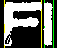

Running tally::: correct: 514 total: 527 accuracy: 0.975 avgEditDist 0.025
special window 112 120 ['N 0.93 ', 'M 0.05 ', 'V 0.04 ', 'I 0.01 ', 'H 0.01 ']
special window 152 160 ['N 0.81 ', 'A 0.68 ', 'V 0.05 ', 'I 0.04 ', 'H 0.03 ']
New example, correct answers:
LRNNAE
[4, 38, 72, 116, 156, 209]
[40, 74, 118, 158, 210, 247]
model 3: LRNNAE 0.512
[0, 36, 72, 116, 160, 208]
[36, 72, 112, 156, 208, 248]
edit distance: 0


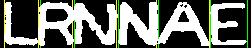

Running tally::: correct: 515 total: 528 accuracy: 0.975 avgEditDist 0.025
special window 64 72 ['N 0.98 ', 'L 0.96 ', 'V 0.02 ', 'T 0.02 ', 'Y 0.01 ']
New example, correct answers:
ENLAOB
[4, 32, 70, 105, 144, 186]
[34, 72, 108, 145, 188, 222]
model 3: ENLAOB 0.479
[0, 32, 72, 108, 144, 184]
[32, 68, 108, 144, 184, 224]
edit distance: 0


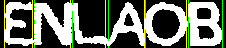

Running tally::: correct: 516 total: 529 accuracy: 0.975 avgEditDist 0.025
special window 40 52 ['C 0.97 ', 'N 0.88 ', 'Y 0.01 ', 'J 0.01 ', 'V 0.01 ']
New example, correct answers:
NCOAS
[4, 45, 85, 127, 167]
[48, 86, 130, 170, 208]
model 3: NCOAS 0.585
[0, 52, 88, 128, 168]
[44, 88, 128, 168, 208]
edit distance: 0


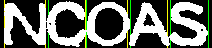

Running tally::: correct: 517 total: 530 accuracy: 0.975 avgEditDist 0.025
special window 40 48 ['E 1.00 ', 'P 0.84 ', 'T 0.01 ', 'A 0.01 ', 'G 0.01 ']
New example, correct answers:
PEGET
[4, 43, 77, 115, 145]
[45, 81, 117, 150, 189]
model 3: PEGET 0.532
[0, 48, 80, 116, 148]
[40, 80, 116, 148, 192]
edit distance: 0


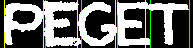

Running tally::: correct: 518 total: 531 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LS
[4, 38]
[43, 76]
model 3: LS 0.835
[0, 40]
[40, 76]
edit distance: 0


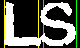

Running tally::: correct: 519 total: 532 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HN
[4, 38]
[40, 81]
model 3: HN 0.844
[0, 40]
[40, 84]
edit distance: 0


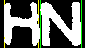

Running tally::: correct: 520 total: 533 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['E 0.99 ', 'V 0.13 ', 'T 0.08 ', 'L 0.07 ', 'Y 0.04 ']
New example, correct answers:
ERCOSE
[4, 45, 85, 125, 169, 206]
[48, 86, 126, 170, 208, 239]
model 3: ERCOSE 0.466
[4, 44, 84, 128, 168, 208]
[44, 84, 128, 168, 208, 240]
edit distance: 0


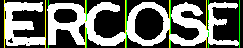

Running tally::: correct: 521 total: 534 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['E 0.98 ', 'V 0.13 ', 'T 0.09 ', 'L 0.05 ', 'Y 0.04 ']
New example, correct answers:
EVR
[4, 39, 79]
[42, 80, 118]
model 3: EVR 0.754
[4, 40, 80]
[40, 80, 120]
edit distance: 0


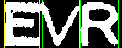

Running tally::: correct: 522 total: 535 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TOLEG
[4, 32, 73, 109, 139]
[42, 74, 110, 141, 179]
model 3: TOLEG 0.520
[0, 36, 72, 108, 140]
[36, 72, 108, 140, 180]
edit distance: 0


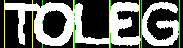

Running tally::: correct: 523 total: 536 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
CR
[4, 39]
[40, 76]
model 3: CR 0.813
[0, 40]
[40, 76]
edit distance: 0


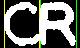

Running tally::: correct: 524 total: 537 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PN
[4, 38]
[42, 80]
model 3: PN 0.759
[0, 40]
[40, 80]
edit distance: 0


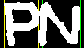

Running tally::: correct: 525 total: 538 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['C 0.97 ', 'I 0.97 ', 'V 0.13 ', 'T 0.07 ', 'M 0.06 ']
New example, correct answers:
IOA
[4, 12, 51]
[15, 58, 91]
model 3: IOA 0.724
[0, 16, 56]
[16, 56, 92]
edit distance: 0


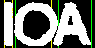

Running tally::: correct: 526 total: 539 accuracy: 0.976 avgEditDist 0.024
special window 44 52 ['E 1.00 ', 'G 0.35 ', 'A 0.05 ', 'I 0.03 ', 'L 0.03 ']
New example, correct answers:
GESA
[4, 45, 88, 124]
[49, 89, 126, 165]
model 3: GESA 0.615
[0, 48, 88, 124]
[44, 88, 124, 168]
edit distance: 0


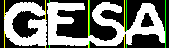

Running tally::: correct: 527 total: 540 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VSRSEO
[4, 49, 90, 128, 163, 191]
[52, 92, 130, 166, 193, 238]
model 3: VSRSEO 0.448
[0, 48, 92, 128, 164, 192]
[48, 92, 128, 164, 192, 240]
edit distance: 0


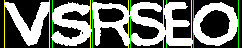

Running tally::: correct: 528 total: 541 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RDU
[4, 42, 79]
[45, 81, 118]
model 3: RDU 0.717
[0, 44, 80]
[44, 80, 120]
edit distance: 0


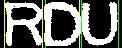

Running tally::: correct: 529 total: 542 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LVH
[4, 43, 82]
[48, 84, 121]
model 3: LVH 0.627
[0, 40, 84]
[40, 84, 124]
edit distance: 0


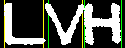

Running tally::: correct: 530 total: 543 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VSUH
[4, 48, 81, 116]
[50, 82, 118, 157]
model 3: VSUH 0.629
[0, 48, 80, 116]
[48, 80, 116, 160]
edit distance: 0


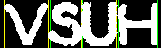

Running tally::: correct: 531 total: 544 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
DE
[4, 38]
[40, 71]
model 3: DE 0.816
[0, 40]
[40, 72]
edit distance: 0


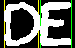

Running tally::: correct: 532 total: 545 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PVRT
[4, 40, 79, 113]
[44, 81, 119, 159]
model 3: PVRT 0.585
[0, 40, 80, 120]
[40, 80, 120, 160]
edit distance: 0


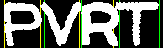

Running tally::: correct: 533 total: 546 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PG
[4, 36]
[40, 73]
model 3: PG 0.783
[0, 36]
[36, 76]
edit distance: 0


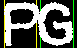

Running tally::: correct: 534 total: 547 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AV
[4, 34]
[41, 76]
model 3: AV 0.709
[0, 36]
[36, 76]
edit distance: 0


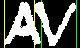

Running tally::: correct: 535 total: 548 accuracy: 0.976 avgEditDist 0.024
special window 36 52 ['I 1.00 ', 'P 0.92 ', 'A 0.76 ', 'M 0.01 ', 'F 0.01 ']
New example, correct answers:
PIA
[4, 38, 49]
[41, 50, 91]
model 3: PIA 0.797
[0, 36, 52]
[40, 52, 92]
edit distance: 0


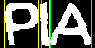

Running tally::: correct: 536 total: 549 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PGN
[4, 37, 79]
[40, 80, 118]
model 3: PGN 0.699
[0, 36, 80]
[36, 80, 120]
edit distance: 0


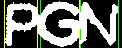

Running tally::: correct: 537 total: 550 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
WFR
[4, 63, 90]
[65, 92, 130]
model 3: WFR 0.679
[0, 64, 92]
[64, 92, 132]
edit distance: 0


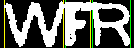

Running tally::: correct: 538 total: 551 accuracy: 0.976 avgEditDist 0.024
special window 188 204 ['I 0.99 ', 'J 0.99 ', 'V 0.08 ', 'T 0.07 ', 'U 0.03 ']
New example, correct answers:
EDMHUI
[4, 39, 72, 119, 151, 190]
[40, 74, 121, 153, 192, 201]
model 3: EDMHUI 0.600
[0, 36, 72, 120, 152, 188]
[36, 72, 120, 152, 188, 204]
edit distance: 0


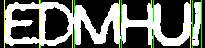

Running tally::: correct: 539 total: 552 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SUV
[4, 33, 71]
[38, 74, 113]
model 3: SUV 0.717
[0, 36, 72]
[36, 72, 116]
edit distance: 0


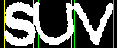

Running tally::: correct: 540 total: 553 accuracy: 0.976 avgEditDist 0.024
special window 120 128 ['H 0.88 ', 'M 0.69 ', 'F 0.12 ', 'J 0.05 ', 'I 0.02 ']
New example, correct answers:
HRMHV
[4, 42, 77, 126, 163]
[49, 79, 128, 165, 205]
model 3: HRMHV 0.576
[0, 44, 80, 128, 164]
[44, 80, 124, 164, 208]
edit distance: 0


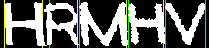

Running tally::: correct: 541 total: 554 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['N 0.97 ', 'M 0.02 ', 'I 0.01 ', 'A 0.01 ', 'H 0.01 ']
New example, correct answers:
NNR
[4, 41, 78]
[44, 80, 114]
model 3: NNR 0.777
[0, 44, 80]
[40, 80, 116]
edit distance: 0


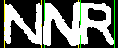

Running tally::: correct: 542 total: 555 accuracy: 0.977 avgEditDist 0.023
special window 80 88 ['N 0.93 ', 'T 0.89 ', 'V 0.01 ', 'I 0.01 ', 'H 0.01 ']
New example, correct answers:
ANTLKA
[4, 43, 86, 126, 162, 199]
[45, 87, 127, 164, 201, 251]
model 3: ANTLKA 0.468
[0, 44, 88, 128, 164, 204]
[44, 84, 128, 164, 204, 252]
edit distance: 0


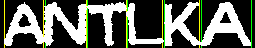

Running tally::: correct: 543 total: 556 accuracy: 0.977 avgEditDist 0.023
special window 44 52 ['N 0.95 ', 'O 0.39 ', 'D 0.21 ', 'J 0.04 ', 'V 0.04 ']
New example, correct answers:
ONEF
[4, 44, 88, 124]
[46, 89, 126, 160]
model 3: ONEF 0.617
[0, 48, 88, 124]
[44, 88, 124, 160]
edit distance: 0


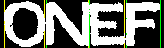

Running tally::: correct: 544 total: 557 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RL
[4, 37]
[41, 73]
model 3: RL 0.814
[0, 40]
[40, 76]
edit distance: 0


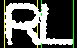

Running tally::: correct: 545 total: 558 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.99 ', 'V 0.12 ', 'T 0.10 ', 'L 0.06 ', 'A 0.04 ']
New example, correct answers:
EBPEO
[4, 42, 71, 106, 138]
[43, 72, 107, 141, 182]
model 3: EBPEO 0.523
[4, 40, 72, 108, 140]
[40, 72, 108, 140, 184]
edit distance: 0


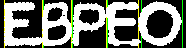

Running tally::: correct: 546 total: 559 accuracy: 0.977 avgEditDist 0.023
special window 40 52 ['I 1.00 ', 'V 0.81 ', 'M 0.65 ', 'N 0.01 ', 'W 0.01 ']
special window 92 100 ['M 0.97 ', 'T 0.02 ', 'I 0.01 ', 'W 0.01 ', 'V 0.01 ']
New example, correct answers:
VIMMSL
[4, 43, 50, 97, 144, 185]
[45, 52, 99, 146, 186, 219]
model 3: VIMMSL 0.591
[0, 40, 52, 100, 148, 184]
[44, 52, 96, 148, 184, 220]
edit distance: 0


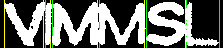

Running tally::: correct: 547 total: 560 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['D 0.97 ', 'V 0.14 ', 'T 0.12 ', 'J 0.07 ', 'Y 0.05 ']
special window 36 52 ['I 1.00 ', 'D 0.78 ', 'H 0.60 ', 'F 0.08 ', 'O 0.02 ']
special window 88 96 ['E 0.99 ', 'H 0.79 ', 'A 0.03 ', 'V 0.01 ', 'I 0.01 ']
New example, correct answers:
DIHER
[4, 39, 49, 93, 130]
[41, 51, 94, 132, 167]
model 3: DIHER 0.671
[4, 36, 52, 96, 132]
[36, 52, 92, 132, 168]
edit distance: 0


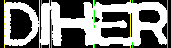

Running tally::: correct: 548 total: 561 accuracy: 0.977 avgEditDist 0.023
special window 112 120 ['N 0.88 ', 'R 0.86 ', 'V 0.03 ', 'T 0.02 ', 'M 0.01 ']
New example, correct answers:
TERN
[4, 43, 74, 113]
[46, 76, 114, 155]
model 3: TERN 0.673
[0, 44, 76, 116]
[44, 76, 112, 156]
edit distance: 0


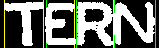

Running tally::: correct: 549 total: 562 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
GOR
[4, 40, 80]
[42, 82, 119]
model 3: GOR 0.709
[0, 44, 80]
[44, 80, 120]
edit distance: 0


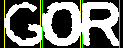

Running tally::: correct: 550 total: 563 accuracy: 0.977 avgEditDist 0.023
special window 128 140 ['I 1.00 ', 'F 0.87 ', 'T 0.47 ', 'R 0.18 ', 'V 0.06 ']
New example, correct answers:
ANTIR
[4, 50, 86, 128, 140]
[53, 90, 130, 141, 174]
model 3: ANTIR 0.655
[0, 48, 88, 128, 140]
[48, 88, 132, 140, 176]
edit distance: 0


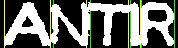

Running tally::: correct: 551 total: 564 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RAREF
[4, 39, 87, 119, 155]
[42, 89, 121, 157, 193]
model 3: RAREF 0.588
[0, 40, 88, 120, 156]
[40, 88, 124, 156, 196]
edit distance: 0


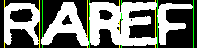

Running tally::: correct: 552 total: 565 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NOSPN
[4, 39, 81, 120, 153]
[41, 83, 122, 155, 196]
model 3: NOSPN 0.611
[0, 40, 84, 120, 156]
[40, 84, 120, 156, 196]
edit distance: 0


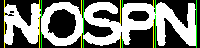

Running tally::: correct: 553 total: 566 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RPTAEF
[4, 39, 75, 109, 149, 184]
[42, 78, 114, 151, 187, 217]
model 3: RPTAEF 0.453
[0, 40, 76, 112, 152, 184]
[40, 76, 112, 152, 184, 220]
edit distance: 0


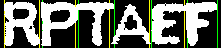

Running tally::: correct: 554 total: 567 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
DADA
[4, 40, 80, 113]
[42, 82, 116, 154]
model 3: DADA 0.620
[0, 40, 80, 112]
[40, 80, 112, 156]
edit distance: 0


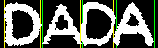

Running tally::: correct: 555 total: 568 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CPRH
[4, 47, 85, 118]
[49, 86, 120, 159]
model 3: CPRH 0.638
[0, 44, 84, 120]
[44, 84, 120, 160]
edit distance: 0


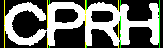

Running tally::: correct: 556 total: 569 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OEL
[4, 43, 80]
[46, 82, 111]
model 3: OEL 0.598
[0, 44, 80]
[44, 80, 112]
edit distance: 0


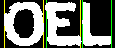

Running tally::: correct: 557 total: 570 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.98 ', 'V 0.11 ', 'T 0.10 ', 'L 0.04 ', 'A 0.03 ']
New example, correct answers:
ENEVAP
[4, 43, 82, 112, 156, 196]
[45, 84, 114, 158, 197, 228]
model 3: ENEVAP 0.516
[8, 44, 84, 116, 156, 196]
[44, 84, 116, 156, 196, 228]
edit distance: 0


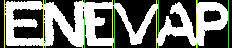

Running tally::: correct: 558 total: 571 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
VA
[4, 41]
[43, 88]
model 3: VA 0.599
[0, 44]
[48, 88]
edit distance: 0


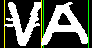

Running tally::: correct: 559 total: 572 accuracy: 0.977 avgEditDist 0.023
special window 100 108 ['N 0.99 ', 'W 0.53 ', 'V 0.06 ', 'U 0.01 ', 'T 0.01 ']
New example, correct answers:
SKNW
[4, 36, 73, 108]
[38, 74, 109, 162]
model 3: SKNW 0.638
[0, 36, 72, 108]
[36, 72, 104, 164]
edit distance: 0


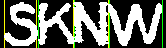

Running tally::: correct: 560 total: 573 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ENVOM
[4, 31, 69, 108, 151]
[34, 73, 114, 153, 198]
model 3: ENVOM 0.559
[0, 36, 72, 112, 152]
[36, 72, 112, 152, 200]
edit distance: 0


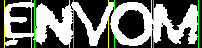

Running tally::: correct: 561 total: 574 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ETAVP
[4, 36, 77, 114, 155]
[40, 80, 122, 156, 189]
model 3: ETAVP 0.500
[0, 40, 80, 120, 156]
[40, 80, 120, 156, 192]
edit distance: 0


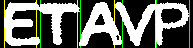

Running tally::: correct: 562 total: 575 accuracy: 0.977 avgEditDist 0.023
special window 36 48 ['L 0.97 ', 'H 0.94 ', 'V 0.01 ', 'I 0.01 ', 'Y 0.01 ']
New example, correct answers:
HLAF
[4, 45, 78, 119]
[48, 80, 122, 159]
model 3: HLAF 0.630
[0, 44, 80, 120]
[40, 80, 120, 160]
edit distance: 0


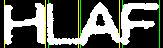

Running tally::: correct: 563 total: 576 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.98 ', 'V 0.12 ', 'T 0.11 ', 'A 0.03 ', 'Y 0.03 ']
New example, correct answers:
LDL
[4, 40, 74]
[42, 78, 110]
model 3: LDL 0.736
[8, 40, 76]
[40, 76, 112]
edit distance: 0


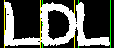

Running tally::: correct: 564 total: 577 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
TEOEED
[4, 38, 66, 105, 137, 174]
[42, 73, 107, 139, 175, 213]
model 3: TEOEED 0.490
[0, 40, 72, 108, 140, 176]
[40, 72, 108, 140, 176, 216]
edit distance: 0


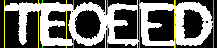

Running tally::: correct: 565 total: 578 accuracy: 0.978 avgEditDist 0.022
special window 0 12 ['N 0.94 ', 'V 0.16 ', 'J 0.07 ', 'T 0.04 ', 'Y 0.03 ']
New example, correct answers:
NDVGBH
[4, 48, 82, 127, 168, 196]
[50, 84, 132, 169, 198, 237]
model 3: NDVGBH 0.477
[8, 48, 84, 128, 168, 196]
[48, 84, 128, 168, 196, 240]
edit distance: 0


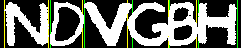

Running tally::: correct: 566 total: 579 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ODD
[4, 45, 81]
[46, 82, 115]
model 3: ODD 0.713
[0, 44, 80]
[44, 80, 116]
edit distance: 0


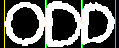

Running tally::: correct: 567 total: 580 accuracy: 0.978 avgEditDist 0.022
special window 68 76 ['K 0.99 ', 'T 0.94 ', 'A 0.03 ', 'L 0.02 ', 'M 0.01 ']
special window 184 192 ['L 0.99 ', 'G 0.38 ', 'E 0.37 ', 'V 0.04 ', 'T 0.03 ']
New example, correct answers:
LTKAGL
[4, 33, 70, 106, 149, 185]
[43, 71, 107, 151, 187, 224]
model 3: LTKAGL 0.426
[0, 36, 72, 108, 148, 188]
[36, 68, 108, 148, 184, 224]
edit distance: 0


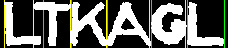

Running tally::: correct: 568 total: 581 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AADLEU
[4, 43, 94, 129, 158, 192]
[45, 96, 131, 160, 194, 233]
model 3: AADLEU 0.505
[0, 44, 92, 128, 160, 192]
[48, 92, 128, 160, 192, 236]
edit distance: 0


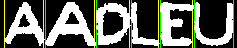

Running tally::: correct: 569 total: 582 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AAW
[4, 54, 94]
[57, 99, 148]
model 3: AAW 0.641
[0, 48, 96]
[48, 96, 148]
edit distance: 0


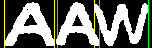

Running tally::: correct: 570 total: 583 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ARRCR
[4, 47, 86, 118, 156]
[48, 87, 119, 157, 193]
model 3: ARRCR 0.604
[0, 48, 80, 120, 156]
[48, 84, 120, 156, 196]
edit distance: 0


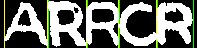

Running tally::: correct: 571 total: 584 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ME
[4, 45]
[47, 81]
model 3: ME 0.822
[0, 44]
[44, 84]
edit distance: 0


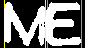

Running tally::: correct: 572 total: 585 accuracy: 0.978 avgEditDist 0.022
special window 0 16 ['I 0.99 ', 'R 0.98 ', 'V 0.17 ', 'T 0.06 ', 'A 0.04 ']
New example, correct answers:
IRGESR
[4, 11, 48, 86, 119, 149]
[13, 49, 88, 121, 151, 191]
model 3: IRGESR 0.609
[0, 12, 48, 88, 120, 152]
[16, 48, 88, 120, 152, 192]
edit distance: 0


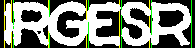

Running tally::: correct: 573 total: 586 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
GRH
[4, 41, 74]
[42, 76, 115]
model 3: GRH 0.778
[0, 40, 76]
[40, 76, 116]
edit distance: 0


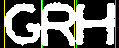

Running tally::: correct: 574 total: 587 accuracy: 0.978 avgEditDist 0.022
special window 36 44 ['H 0.94 ', 'F 0.86 ', 'R 0.17 ', 'P 0.02 ', 'V 0.02 ']
New example, correct answers:
HRA
[4, 43, 76]
[46, 78, 125]
model 3: HRA 0.730
[0, 44, 80]
[40, 80, 128]
edit distance: 0


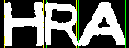

Running tally::: correct: 575 total: 588 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
KNSNOA
[4, 40, 78, 114, 150, 186]
[41, 80, 115, 152, 191, 230]
model 3: KNSNOA 0.526
[0, 40, 80, 116, 152, 188]
[40, 80, 116, 152, 188, 232]
edit distance: 0


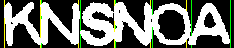

Running tally::: correct: 576 total: 589 accuracy: 0.978 avgEditDist 0.022
special window 116 124 ['I 0.99 ', 'R 0.96 ', 'V 0.09 ', 'T 0.06 ', 'L 0.06 ']
New example, correct answers:
ADRI
[4, 45, 78, 113]
[46, 79, 115, 123]
model 3: ADRI 0.723
[0, 44, 80, 116]
[44, 80, 116, 124]
edit distance: 0


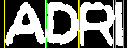

Running tally::: correct: 577 total: 590 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['E 0.98 ', 'V 0.12 ', 'T 0.09 ', 'L 0.05 ', 'A 0.04 ']
New example, correct answers:
EWROH
[4, 43, 100, 136, 173]
[46, 101, 137, 175, 211]
model 3: EWROH 0.581
[4, 44, 100, 136, 176]
[44, 100, 136, 176, 212]
edit distance: 0


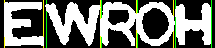

Running tally::: correct: 578 total: 591 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['R 0.91 ', 'V 0.15 ', 'J 0.12 ', 'T 0.06 ', 'L 0.04 ']
special window 76 88 ['A 0.91 ', 'N 0.84 ', 'F 0.00 ', 'I 0.00 ', 'O 0.00 ']
New example, correct answers:
RNAA
[4, 43, 80, 123]
[46, 82, 125, 169]
model 3: RNAA 0.657
[4, 40, 84, 124]
[40, 80, 124, 172]
edit distance: 0


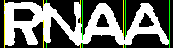

Running tally::: correct: 579 total: 592 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
OVH
[4, 47, 80]
[50, 82, 119]
model 3: OVH 0.659
[0, 48, 80]
[48, 80, 120]
edit distance: 0


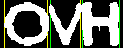

Running tally::: correct: 580 total: 593 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AL
[4, 43]
[45, 77]
model 3: AL 0.820
[0, 44]
[44, 80]
edit distance: 0


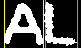

Running tally::: correct: 581 total: 594 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
GS
[4, 39]
[41, 83]
model 3: GS 0.833
[0, 40]
[40, 84]
edit distance: 0


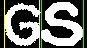

Running tally::: correct: 582 total: 595 accuracy: 0.978 avgEditDist 0.022
special window 0 16 ['I 0.98 ', 'C 0.96 ', 'V 0.20 ', 'T 0.08 ', 'M 0.04 ']
special window 56 64 ['R 0.95 ', 'D 0.78 ', 'V 0.06 ', 'J 0.06 ', 'N 0.04 ']
New example, correct answers:
IORR
[4, 11, 58, 94]
[14, 59, 96, 140]
model 3: IORR 0.757
[0, 16, 60, 92]
[16, 56, 96, 140]
edit distance: 0


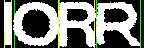

Running tally::: correct: 583 total: 596 accuracy: 0.978 avgEditDist 0.022
special window 68 76 ['N 0.98 ', 'T 0.08 ', 'V 0.07 ', 'L 0.05 ', 'H 0.02 ']
New example, correct answers:
FN
[4, 34]
[36, 76]
model 3: FN 0.789
[0, 36]
[36, 72]
edit distance: 0


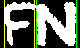

Running tally::: correct: 584 total: 597 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
PATLC
[4, 29, 61, 97, 124]
[38, 67, 98, 127, 158]
model 3: PATLC 0.441
[0, 36, 64, 96, 124]
[36, 64, 100, 124, 160]
edit distance: 0


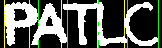

Running tally::: correct: 585 total: 598 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RESTV
[4, 37, 66, 98, 135]
[40, 69, 99, 137, 172]
model 3: RESTV 0.541
[0, 40, 68, 100, 136]
[40, 72, 100, 136, 172]
edit distance: 0


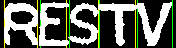

Running tally::: correct: 586 total: 599 accuracy: 0.978 avgEditDist 0.022
special window 148 156 ['H 0.99 ', 'V 0.16 ', 'T 0.09 ', 'Y 0.03 ', 'L 0.02 ']
New example, correct answers:
DOKH
[4, 42, 80, 117]
[43, 83, 119, 155]
model 3: DOKH 0.645
[0, 40, 80, 120]
[40, 80, 120, 152]
edit distance: 0


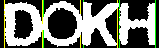

Running tally::: correct: 587 total: 600 accuracy: 0.978 avgEditDist 0.022
special window 108 124 ['I 1.00 ', 'H 0.87 ', 'C 0.74 ', 'O 0.06 ', 'G 0.03 ']
New example, correct answers:
EOHICR
[4, 33, 74, 112, 121, 159]
[35, 76, 113, 123, 161, 199]
model 3: EOHICR 0.536
[0, 36, 76, 108, 124, 160]
[36, 76, 112, 124, 160, 200]
edit distance: 0


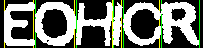

Running tally::: correct: 588 total: 601 accuracy: 0.978 avgEditDist 0.022
special window 72 80 ['I 1.00 ', 'E 0.99 ', 'C 0.71 ', 'L 0.03 ', 'V 0.02 ']
New example, correct answers:
SCIE
[4, 39, 71, 79]
[40, 73, 80, 112]
model 3: SCIE 0.722
[0, 36, 72, 80]
[36, 72, 80, 112]
edit distance: 0


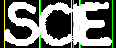

Running tally::: correct: 589 total: 602 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
GDI
[4, 41, 81]
[43, 83, 92]
model 3: GD 0.585
[0, 44]
[44, 92]
edit distance: 1
-----------------------------------------------------------------------------


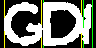

Running tally::: correct: 589 total: 603 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['I 1.00 ', 'F 0.92 ', 'V 0.21 ', 'J 0.08 ', 'H 0.04 ']
New example, correct answers:
IPSS
[4, 11, 42, 75]
[15, 46, 77, 111]
model 3: IPSS 0.743
[0, 12, 44, 76]
[12, 44, 76, 112]
edit distance: 0


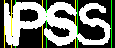

Running tally::: correct: 590 total: 604 accuracy: 0.977 avgEditDist 0.023
special window 40 56 ['I 0.99 ', 'E 0.93 ', 'C 0.92 ', 'O 0.03 ', 'G 0.02 ']
New example, correct answers:
EIOODV
[4, 44, 53, 91, 135, 162]
[46, 54, 93, 138, 171, 202]
model 3: EIOODV 0.561
[0, 40, 56, 96, 136, 164]
[40, 56, 96, 136, 168, 204]
edit distance: 0


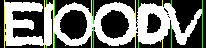

Running tally::: correct: 591 total: 605 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EN
[4, 32]
[36, 70]
model 3: EN 0.786
[0, 36]
[36, 72]
edit distance: 0


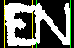

Running tally::: correct: 592 total: 606 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['H 0.94 ', 'A 0.94 ', 'J 0.01 ', 'L 0.01 ', 'I 0.00 ']
special window 152 160 ['N 0.98 ', 'L 0.97 ', 'T 0.02 ', 'V 0.01 ', 'Y 0.01 ']
New example, correct answers:
HALNL
[4, 41, 83, 119, 158]
[42, 86, 121, 159, 197]
model 3: HALNL 0.624
[0, 44, 84, 120, 160]
[40, 84, 120, 156, 200]
edit distance: 0


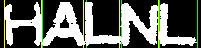

Running tally::: correct: 593 total: 607 accuracy: 0.977 avgEditDist 0.023
special window 80 88 ['E 1.00 ', 'N 0.85 ', 'A 0.01 ', 'V 0.01 ', 'W 0.01 ']
New example, correct answers:
CNE
[4, 38, 84]
[44, 86, 115]
model 3: CNE 0.700
[0, 40, 84]
[40, 80, 116]
edit distance: 0


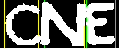

Running tally::: correct: 594 total: 608 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EBL
[4, 38, 69]
[40, 71, 106]
model 3: EBL 0.688
[0, 36, 68]
[40, 68, 108]
edit distance: 0


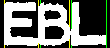

Running tally::: correct: 595 total: 609 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.98 ', 'V 0.14 ', 'T 0.12 ', 'Y 0.03 ', 'A 0.02 ']
New example, correct answers:
LMER
[4, 37, 82, 115]
[40, 84, 117, 154]
model 3: LMER 0.666
[4, 36, 84, 116]
[36, 84, 116, 156]
edit distance: 0


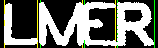

Running tally::: correct: 596 total: 610 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['C 0.96 ', 'N 0.91 ', 'T 0.03 ', 'O 0.01 ', 'Y 0.01 ']
New example, correct answers:
SNOTU
[4, 38, 77, 115, 152]
[40, 79, 123, 154, 191]
model 3: SNOTU 0.510
[0, 36, 80, 120, 156]
[36, 76, 120, 156, 192]
edit distance: 0


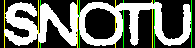

Running tally::: correct: 597 total: 611 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
BAENEA
[4, 35, 71, 102, 141, 177]
[38, 72, 103, 143, 178, 219]
model 3: BAENEA 0.489
[0, 36, 72, 104, 144, 176]
[36, 72, 104, 144, 176, 220]
edit distance: 0


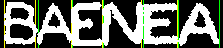

Running tally::: correct: 598 total: 612 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.98 ', 'V 0.14 ', 'T 0.13 ', 'Y 0.03 ', 'A 0.02 ']
New example, correct answers:
LNTER
[4, 43, 81, 123, 164]
[46, 82, 125, 165, 199]
model 3: LNTER 0.608
[4, 44, 84, 124, 164]
[44, 84, 124, 164, 200]
edit distance: 0


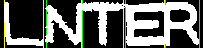

Running tally::: correct: 599 total: 613 accuracy: 0.977 avgEditDist 0.023
special window 32 40 ['H 0.99 ', 'T 0.82 ', 'V 0.09 ', 'I 0.02 ', 'W 0.02 ']
New example, correct answers:
HT
[4, 40]
[43, 87]
model 3: HT 0.795
[0, 40]
[36, 88]
edit distance: 0


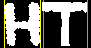

Running tally::: correct: 600 total: 614 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['I 1.00 ', 'L 0.39 ', 'V 0.24 ', 'U 0.15 ', 'T 0.07 ']
special window 112 120 ['P 0.99 ', 'H 0.93 ', 'I 0.02 ', 'V 0.02 ', 'A 0.02 ']
New example, correct answers:
IUDHP
[4, 11, 46, 80, 118]
[14, 47, 81, 119, 152]
model 3: IUDHP 0.641
[0, 12, 48, 80, 120]
[12, 48, 80, 116, 152]
edit distance: 0


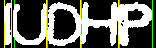

Running tally::: correct: 601 total: 615 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MVC
[4, 51, 89]
[54, 92, 128]
model 3: MVC 0.664
[0, 52, 92]
[52, 92, 128]
edit distance: 0


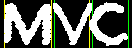

Running tally::: correct: 602 total: 616 accuracy: 0.977 avgEditDist 0.023
special window 76 92 ['I 1.00 ', 'E 0.98 ', 'O 0.20 ', 'J 0.17 ', 'V 0.05 ']
New example, correct answers:
SOIEOV
[4, 41, 80, 88, 116, 154]
[43, 82, 90, 123, 156, 196]
model 3: SOIEOV 0.515
[0, 44, 76, 92, 120, 156]
[44, 80, 92, 124, 156, 196]
edit distance: 0


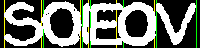

Running tally::: correct: 603 total: 617 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NWOV
[4, 46, 103, 135]
[48, 104, 142, 195]
model 3: NWOV 0.501
[0, 48, 104, 148]
[48, 104, 148, 196]
edit distance: 0


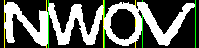

Running tally::: correct: 604 total: 618 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ADD
[4, 41, 79]
[44, 81, 115]
model 3: ADD 0.723
[0, 44, 80]
[44, 80, 116]
edit distance: 0


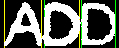

Running tally::: correct: 605 total: 619 accuracy: 0.977 avgEditDist 0.023
special window 52 60 ['R 0.99 ', 'M 0.65 ', 'N 0.02 ', 'I 0.02 ', 'V 0.01 ']
New example, correct answers:
MRAAG
[4, 54, 89, 124, 165]
[57, 90, 126, 170, 203]
model 3: MRAAG 0.588
[0, 56, 88, 124, 168]
[52, 88, 128, 168, 204]
edit distance: 0


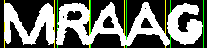

Running tally::: correct: 606 total: 620 accuracy: 0.977 avgEditDist 0.023
special window 124 140 ['I 0.99 ', 'O 0.69 ', 'T 0.18 ', 'V 0.10 ', 'D 0.07 ']
New example, correct answers:
DOOI
[4, 42, 85, 130]
[45, 86, 131, 138]
model 3: DOOI 0.718
[0, 40, 80, 124]
[40, 80, 128, 140]
edit distance: 0


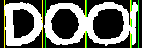

Running tally::: correct: 607 total: 621 accuracy: 0.977 avgEditDist 0.023
special window 112 124 ['N 0.99 ', 'U 0.61 ', 'L 0.08 ', 'V 0.02 ', 'C 0.02 ']
New example, correct answers:
DENUKE
[4, 39, 82, 122, 157, 196]
[40, 83, 123, 160, 199, 238]
model 3: DENUKE 0.487
[0, 40, 80, 124, 160, 200]
[40, 80, 116, 160, 200, 240]
edit distance: 0


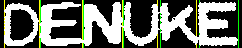

Running tally::: correct: 608 total: 622 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
GRAA
[4, 41, 79, 115]
[43, 81, 116, 157]
model 3: GRAA 0.630
[0, 44, 80, 112]
[44, 80, 116, 160]
edit distance: 0


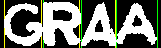

Running tally::: correct: 609 total: 623 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AFARE
[4, 43, 75, 118, 158]
[47, 81, 121, 160, 193]
model 3: AFARE 0.525
[0, 44, 76, 120, 160]
[44, 76, 120, 160, 196]
edit distance: 0


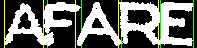

Running tally::: correct: 610 total: 624 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ELTFR
[4, 35, 66, 100, 135]
[37, 75, 102, 137, 171]
model 3: ELTFR 0.502
[0, 36, 68, 100, 136]
[36, 68, 100, 136, 172]
edit distance: 0


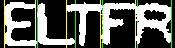

Running tally::: correct: 611 total: 625 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ADTPRH
[4, 51, 86, 124, 157, 189]
[53, 89, 125, 158, 191, 235]
model 3: ADTPRH 0.418
[0, 48, 88, 124, 156, 192]
[48, 88, 124, 156, 192, 236]
edit distance: 0


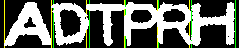

Running tally::: correct: 612 total: 626 accuracy: 0.978 avgEditDist 0.022
special window 36 44 ['L 0.99 ', 'P 0.96 ', 'T 0.02 ', 'V 0.01 ', 'Y 0.01 ']
New example, correct answers:
PLVA
[4, 38, 75, 110]
[40, 80, 114, 152]
model 3: PLVA 0.551
[0, 40, 76, 108]
[36, 76, 108, 152]
edit distance: 0


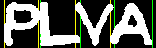

Running tally::: correct: 613 total: 627 accuracy: 0.978 avgEditDist 0.022
special window 76 92 ['I 1.00 ', 'E 0.99 ', 'N 0.50 ', 'V 0.20 ', 'M 0.05 ']
New example, correct answers:
OEIN
[4, 47, 79, 89]
[48, 81, 91, 129]
model 3: OEIN 0.711
[0, 48, 76, 92]
[48, 80, 92, 132]
edit distance: 0


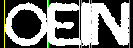

Running tally::: correct: 614 total: 628 accuracy: 0.978 avgEditDist 0.022
special window 40 56 ['I 1.00 ', 'C 0.96 ', 'D 0.68 ', 'L 0.06 ', 'V 0.02 ']
New example, correct answers:
CIDRVV
[4, 41, 53, 83, 122, 160]
[44, 54, 87, 129, 162, 206]
model 3: CIDRVV 0.534
[0, 40, 52, 84, 124, 168]
[40, 56, 84, 124, 172, 208]
edit distance: 0


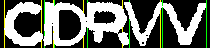

Running tally::: correct: 615 total: 629 accuracy: 0.978 avgEditDist 0.022
special window 80 88 ['N 0.87 ', 'V 0.77 ', 'T 0.02 ', 'I 0.01 ', 'Y 0.01 ']
special window 164 172 ['F 0.99 ', 'N 0.97 ', 'L 0.02 ', 'C 0.01 ', 'I 0.01 ']
New example, correct answers:
UNVNF
[4, 46, 86, 131, 168]
[48, 88, 132, 170, 206]
model 3: UNVNF 0.567
[0, 44, 88, 132, 172]
[44, 84, 132, 168, 208]
edit distance: 0


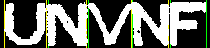

Running tally::: correct: 616 total: 630 accuracy: 0.978 avgEditDist 0.022
special window 0 16 ['I 0.97 ', 'T 0.96 ', 'V 0.18 ', 'L 0.05 ', 'J 0.04 ']
New example, correct answers:
ITNT
[4, 16, 55, 94]
[18, 58, 96, 130]
model 3: ITNT 0.624
[0, 20, 56, 96]
[16, 56, 96, 132]
edit distance: 0


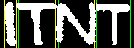

Running tally::: correct: 617 total: 631 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
WV
[4, 58]
[60, 99]
model 3: WV 0.823
[0, 60]
[60, 100]
edit distance: 0


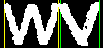

Running tally::: correct: 618 total: 632 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
TRH
[4, 38, 87]
[43, 88, 126]
model 3: TRH 0.708
[0, 44, 88]
[44, 88, 128]
edit distance: 0


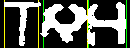

Running tally::: correct: 619 total: 633 accuracy: 0.978 avgEditDist 0.022
special window 60 68 ['I 1.00 ', 'G 0.77 ', 'W 0.49 ', 'V 0.27 ', 'C 0.08 ']
New example, correct answers:
WIGONR
[4, 59, 67, 102, 135, 173]
[62, 68, 103, 136, 174, 207]
model 3: WIGONR 0.606
[0, 60, 68, 100, 132, 172]
[60, 68, 104, 136, 172, 208]
edit distance: 0


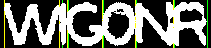

Running tally::: correct: 620 total: 634 accuracy: 0.978 avgEditDist 0.022
special window 48 56 ['H 0.88 ', 'V 0.80 ', 'J 0.04 ', 'F 0.02 ', 'W 0.01 ']
special window 196 212 ['E 0.99 ', 'I 0.99 ', 'V 0.21 ', 'T 0.09 ', 'L 0.07 ']
New example, correct answers:
VHRREI
[4, 47, 91, 125, 168, 199]
[50, 92, 130, 169, 201, 211]
model 3: VHRREI 0.617
[0, 52, 92, 120, 168, 196]
[48, 92, 124, 168, 196, 212]
edit distance: 0


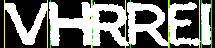

Running tally::: correct: 621 total: 635 accuracy: 0.978 avgEditDist 0.022
special window 72 80 ['F 0.98 ', 'L 0.98 ', 'V 0.03 ', 'T 0.02 ', 'Y 0.02 ']
New example, correct answers:
VFL
[4, 41, 74]
[43, 76, 115]
model 3: VFL 0.731
[0, 40, 76]
[40, 72, 116]
edit distance: 0


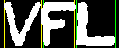

Running tally::: correct: 622 total: 636 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
OGRT
[4, 41, 81, 116]
[44, 82, 118, 154]
model 3: OGRT 0.588
[0, 40, 80, 116]
[40, 80, 116, 156]
edit distance: 0


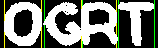

Running tally::: correct: 623 total: 637 accuracy: 0.978 avgEditDist 0.022
special window 200 208 ['I 0.92 ', 'A 0.91 ', 'T 0.07 ', 'V 0.05 ', 'L 0.03 ']
New example, correct answers:
ASOKAI
[4, 41, 74, 117, 154, 198]
[44, 76, 120, 156, 199, 207]
model 3: ASOKAI 0.501
[0, 44, 76, 120, 156, 200]
[44, 76, 120, 156, 200, 208]
edit distance: 0


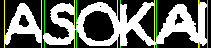

Running tally::: correct: 624 total: 638 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AOVF
[4, 37, 81, 118]
[45, 82, 120, 154]
model 3: AOVF 0.601
[0, 40, 80, 120]
[40, 80, 120, 156]
edit distance: 0


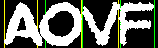

Running tally::: correct: 625 total: 639 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RPS
[4, 39, 77]
[43, 78, 117]
model 3: RPS 0.764
[0, 40, 76]
[40, 76, 120]
edit distance: 0


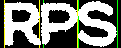

Running tally::: correct: 626 total: 640 accuracy: 0.978 avgEditDist 0.022
special window 0 12 ['L 0.98 ', 'V 0.11 ', 'T 0.10 ', 'J 0.04 ', 'Y 0.03 ']
New example, correct answers:
LEKVA
[4, 42, 74, 112, 149]
[45, 77, 115, 158, 195]
model 3: LEKVA 0.545
[8, 44, 76, 116, 152]
[44, 76, 116, 152, 196]
edit distance: 0


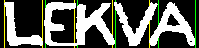

Running tally::: correct: 627 total: 641 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
DVK
[4, 39, 83]
[46, 84, 121]
model 3: DVK 0.673
[0, 44, 84]
[44, 84, 124]
edit distance: 0


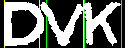

Running tally::: correct: 628 total: 642 accuracy: 0.978 avgEditDist 0.022
special window 44 52 ['B 0.99 ', 'A 0.87 ', 'T 0.01 ', 'L 0.01 ', 'N 0.01 ']
New example, correct answers:
ABATE
[4, 46, 80, 112, 154]
[49, 81, 119, 156, 180]
model 3: ABATE 0.464
[0, 48, 80, 116, 152]
[44, 80, 116, 156, 180]
edit distance: 0


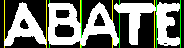

Running tally::: correct: 629 total: 643 accuracy: 0.978 avgEditDist 0.022
special window 40 56 ['I 0.99 ', 'T 0.97 ', 'V 0.13 ', 'L 0.09 ', 'W 0.02 ']
New example, correct answers:
TI
[4, 43]
[45, 54]
model 3: TI 0.909
[0, 40]
[44, 56]
edit distance: 0


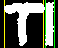

Running tally::: correct: 630 total: 644 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ORSD
[4, 37, 72, 108]
[38, 74, 109, 143]
model 3: ORSD 0.635
[0, 40, 72, 108]
[40, 72, 108, 144]
edit distance: 0


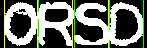

Running tally::: correct: 631 total: 645 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ELU
[4, 34, 71]
[38, 76, 109]
model 3: ELU 0.720
[0, 36, 72]
[36, 72, 112]
edit distance: 0


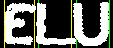

Running tally::: correct: 632 total: 646 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AKEG
[4, 44, 85, 115]
[51, 86, 119, 154]
model 3: AKEG 0.578
[0, 44, 84, 116]
[44, 84, 116, 156]
edit distance: 0


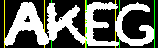

Running tally::: correct: 633 total: 647 accuracy: 0.978 avgEditDist 0.022
special window 0 16 ['I 0.99 ', 'G 0.93 ', 'V 0.21 ', 'T 0.08 ', 'Y 0.05 ']
New example, correct answers:
IG
[4, 12]
[15, 54]
model 3: IG 0.891
[0, 16]
[16, 56]
edit distance: 0


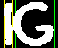

Running tally::: correct: 634 total: 648 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ULTD
[4, 41, 68, 99]
[43, 76, 101, 135]
model 3: ULTD 0.500
[0, 40, 68, 100]
[40, 68, 100, 136]
edit distance: 0


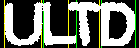

Running tally::: correct: 635 total: 649 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ACLC
[4, 43, 81, 120]
[50, 83, 122, 161]
model 3: ACLC 0.590
[0, 48, 84, 120]
[48, 84, 120, 164]
edit distance: 0


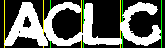

Running tally::: correct: 636 total: 650 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
EOL
[4, 37, 77]
[39, 79, 108]
model 3: EOL 0.687
[0, 40, 76]
[40, 76, 108]
edit distance: 0


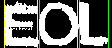

Running tally::: correct: 637 total: 651 accuracy: 0.978 avgEditDist 0.022
special window 124 132 ['R 0.99 ', 'D 0.47 ', 'O 0.10 ', 'V 0.10 ', 'J 0.04 ']
special window 160 176 ['I 0.99 ', 'R 0.94 ', 'V 0.09 ', 'T 0.08 ', 'L 0.06 ']
New example, correct answers:
PWORI
[4, 35, 85, 125, 162]
[40, 89, 127, 164, 173]
model 3: PWORI 0.641
[0, 36, 88, 128, 160]
[36, 88, 124, 164, 176]
edit distance: 0


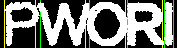

Running tally::: correct: 638 total: 652 accuracy: 0.979 avgEditDist 0.021
special window 40 48 ['F 0.99 ', 'V 0.68 ', 'W 0.09 ', 'A 0.01 ', 'J 0.01 ']
New example, correct answers:
VPW
[4, 41, 81]
[44, 83, 136]
model 3: VPW 0.718
[0, 48, 84]
[40, 84, 136]
edit distance: 0


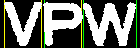

Running tally::: correct: 639 total: 653 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
EP
[4, 38]
[42, 72]
model 3: EP 0.778
[0, 40]
[40, 72]
edit distance: 0


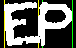

Running tally::: correct: 640 total: 654 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RVRLR
[4, 33, 77, 115, 149]
[39, 78, 117, 150, 184]
model 3: RVRLR 0.553
[0, 36, 76, 112, 148]
[36, 76, 112, 148, 184]
edit distance: 0


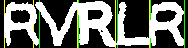

Running tally::: correct: 641 total: 655 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ONVOD
[4, 39, 82, 123, 160]
[42, 84, 127, 162, 196]
model 3: ONVOD 0.567
[0, 40, 84, 124, 160]
[40, 84, 124, 160, 196]
edit distance: 0


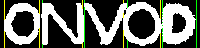

Running tally::: correct: 642 total: 656 accuracy: 0.979 avgEditDist 0.021
special window 80 92 ['I 0.98 ', 'T 0.97 ', 'A 0.88 ', 'N 0.01 ', 'W 0.01 ']
New example, correct answers:
AAITU
[4, 43, 80, 89, 124]
[45, 82, 91, 126, 161]
model 3: AAITU 0.652
[0, 40, 80, 92, 128]
[44, 80, 92, 132, 164]
edit distance: 0


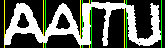

Running tally::: correct: 643 total: 657 accuracy: 0.979 avgEditDist 0.021
special window 40 48 ['E 1.00 ', 'V 0.03 ', 'T 0.02 ', 'A 0.01 ', 'G 0.01 ']
special window 116 124 ['N 0.97 ', 'C 0.97 ', 'T 0.05 ', 'J 0.01 ', 'O 0.01 ']
special window 164 172 ['E 1.00 ', 'D 0.90 ', 'T 0.01 ', 'V 0.01 ', 'Y 0.01 ']
New example, correct answers:
EENOEC
[4, 39, 83, 119, 163, 194]
[44, 85, 121, 165, 197, 238]
model 3: EENOEC 0.483
[0, 44, 84, 124, 168, 196]
[40, 84, 120, 164, 196, 240]
edit distance: 0


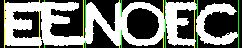

Running tally::: correct: 644 total: 658 accuracy: 0.979 avgEditDist 0.021
special window 0 8 ['R 0.93 ', 'V 0.17 ', 'F 0.06 ', 'J 0.05 ', 'T 0.05 ']
New example, correct answers:
REAR
[4, 46, 83, 124]
[49, 84, 125, 160]
model 3: REAR 0.716
[8, 48, 84, 124]
[48, 84, 124, 160]
edit distance: 0


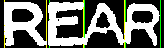

Running tally::: correct: 645 total: 659 accuracy: 0.979 avgEditDist 0.021
special window 36 44 ['N 0.94 ', 'A 0.91 ', 'H 0.01 ', 'T 0.01 ', 'J 0.01 ']
New example, correct answers:
NAT
[4, 41, 77]
[44, 84, 120]
model 3: NAT 0.684
[0, 44, 80]
[40, 80, 120]
edit distance: 0


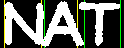

Running tally::: correct: 646 total: 660 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
PELVP
[4, 42, 76, 101, 152]
[44, 77, 111, 153, 193]
model 3: PELVP 0.491
[0, 40, 72, 108, 152]
[40, 76, 108, 152, 196]
edit distance: 0


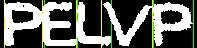

Running tally::: correct: 647 total: 661 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ASMS
[4, 45, 80, 125]
[46, 81, 126, 158]
model 3: ASMS 0.627
[0, 48, 80, 124]
[48, 80, 124, 160]
edit distance: 0


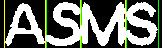

Running tally::: correct: 648 total: 662 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
TE
[4, 42]
[45, 77]
model 3: TE 0.816
[0, 44]
[44, 80]
edit distance: 0


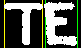

Running tally::: correct: 649 total: 663 accuracy: 0.979 avgEditDist 0.021
special window 44 60 ['I 0.99 ', 'M 0.70 ', 'A 0.60 ', 'H 0.04 ', 'F 0.02 ']
New example, correct answers:
MIA
[4, 45, 54]
[47, 56, 106]
model 3: MIA 0.807
[0, 44, 60]
[44, 60, 108]
edit distance: 0


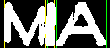

Running tally::: correct: 650 total: 664 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
RC
[4, 42]
[44, 84]
model 3: RC 0.766
[0, 44]
[44, 84]
edit distance: 0


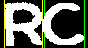

Running tally::: correct: 651 total: 665 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
DOTD
[4, 38, 69, 100]
[40, 76, 102, 137]
model 3: DOTD 0.548
[0, 36, 76, 104]
[36, 76, 108, 140]
edit distance: 0


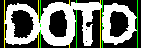

Running tally::: correct: 652 total: 666 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
DEA
[4, 39, 74]
[41, 75, 118]
model 3: DEA 0.721
[0, 40, 76]
[40, 76, 120]
edit distance: 0


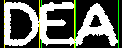

Running tally::: correct: 653 total: 667 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
EPSN
[4, 40, 77, 111]
[42, 81, 114, 154]
model 3: EPSN 0.609
[0, 40, 80, 116]
[40, 80, 116, 156]
edit distance: 0


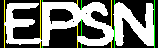

Running tally::: correct: 654 total: 668 accuracy: 0.979 avgEditDist 0.021
special window 40 48 ['R 0.94 ', 'N 0.89 ', 'F 0.11 ', 'A 0.02 ', 'I 0.01 ']
New example, correct answers:
NRR
[4, 46, 81]
[48, 83, 119]
model 3: NRR 0.780
[0, 48, 80]
[44, 84, 120]
edit distance: 0


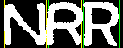

Running tally::: correct: 655 total: 669 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
OER
[4, 43, 76]
[44, 78, 113]
model 3: OER 0.735
[0, 44, 76]
[44, 76, 116]
edit distance: 0


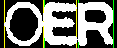

Running tally::: correct: 656 total: 670 accuracy: 0.979 avgEditDist 0.021
special window 44 52 ['A 0.95 ', 'I 0.90 ', 'V 0.07 ', 'T 0.07 ', 'Y 0.03 ']
New example, correct answers:
AI
[4, 42]
[44, 55]
model 3: AI 0.886
[0, 44]
[44, 52]
edit distance: 0


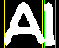

Running tally::: correct: 657 total: 671 accuracy: 0.979 avgEditDist 0.021
special window 0 16 ['R 0.99 ', 'I 0.99 ', 'V 0.15 ', 'T 0.07 ', 'L 0.05 ']
New example, correct answers:
IR
[4, 11]
[13, 47]
model 3: IR 0.916
[0, 12]
[16, 48]
edit distance: 0


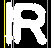

Running tally::: correct: 658 total: 672 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
REO
[4, 45, 71]
[48, 73, 112]
model 3: REO 0.669
[0, 44, 72]
[44, 72, 112]
edit distance: 0


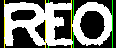

Running tally::: correct: 659 total: 673 accuracy: 0.979 avgEditDist 0.021
special window 120 136 ['I 1.00 ', 'F 0.90 ', 'T 0.72 ', 'H 0.01 ', 'A 0.01 ']
special window 164 180 ['I 1.00 ', 'F 0.98 ', 'V 0.14 ', 'T 0.06 ', 'A 0.05 ']
New example, correct answers:
ETTIFI
[4, 35, 78, 122, 132, 168]
[38, 80, 124, 134, 170, 177]
model 3: ETTIFI 0.652
[0, 36, 76, 120, 132, 164]
[36, 80, 120, 136, 168, 180]
edit distance: 0


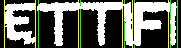

Running tally::: correct: 660 total: 674 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
PL
[4, 35]
[39, 74]
model 3: PL 0.810
[0, 36]
[36, 76]
edit distance: 0


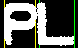

Running tally::: correct: 661 total: 675 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VRLD
[4, 39, 71, 110]
[41, 73, 111, 143]
model 3: VRLD 0.606
[0, 40, 72, 108]
[40, 72, 112, 144]
edit distance: 0


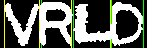

Running tally::: correct: 662 total: 676 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
WLTVS
[4, 56, 90, 133, 162]
[59, 95, 134, 166, 197]
model 3: WLTVS 0.562
[0, 56, 92, 132, 164]
[56, 92, 132, 164, 200]
edit distance: 0


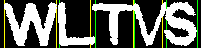

Running tally::: correct: 663 total: 677 accuracy: 0.979 avgEditDist 0.021
special window 148 156 ['A 0.95 ', 'N 0.88 ', 'I 0.01 ', 'V 0.01 ', 'J 0.00 ']
New example, correct answers:
EDCNAO
[4, 38, 72, 111, 151, 190]
[39, 73, 113, 153, 192, 234]
model 3: EDCNAO 0.509
[0, 40, 72, 112, 156, 192]
[40, 72, 112, 152, 192, 236]
edit distance: 0


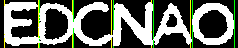

Running tally::: correct: 664 total: 678 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
OSOP
[4, 42, 76, 115]
[43, 78, 116, 148]
model 3: OSOP 0.646
[0, 44, 80, 116]
[44, 80, 116, 148]
edit distance: 0


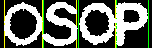

Running tally::: correct: 665 total: 679 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VSEOR
[4, 43, 76, 105, 148]
[48, 78, 111, 149, 184]
model 3: VSEOR 0.571
[0, 44, 76, 108, 148]
[44, 76, 108, 148, 184]
edit distance: 0


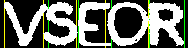

Running tally::: correct: 666 total: 680 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
HG
[4, 44]
[46, 82]
model 3: HG 0.803
[0, 44]
[44, 84]
edit distance: 0


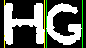

Running tally::: correct: 667 total: 681 accuracy: 0.979 avgEditDist 0.021
special window 40 48 ['N 0.93 ', 'A 0.92 ', 'T 0.01 ', 'J 0.01 ', 'H 0.01 ']
special window 124 132 ['C 0.97 ', 'N 0.85 ', 'T 0.01 ', 'V 0.01 ', 'J 0.01 ']
New example, correct answers:
NANOP
[4, 46, 84, 128, 171]
[49, 86, 129, 173, 212]
model 3: NANOP 0.551
[0, 48, 84, 132, 172]
[44, 84, 124, 172, 212]
edit distance: 0


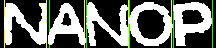

Running tally::: correct: 668 total: 682 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
BR
[4, 39]
[42, 77]
model 3: BR 0.823
[0, 40]
[40, 80]
edit distance: 0


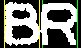

Running tally::: correct: 669 total: 683 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
TE
[4, 48]
[51, 80]
model 3: TE 0.727
[0, 48]
[48, 80]
edit distance: 0


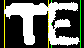

Running tally::: correct: 670 total: 684 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
NA
[4, 41]
[43, 79]
model 3: NA 0.830
[0, 44]
[44, 80]
edit distance: 0


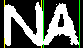

Running tally::: correct: 671 total: 685 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
NNSS
[4, 41, 71, 108]
[43, 74, 109, 144]
model 3: NNSS 0.716
[0, 40, 72, 108]
[40, 72, 108, 144]
edit distance: 0


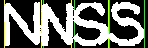

Running tally::: correct: 672 total: 686 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
GTS
[4, 43, 78]
[45, 80, 110]
model 3: GTS 0.643
[0, 44, 76]
[44, 80, 112]
edit distance: 0


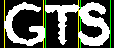

Running tally::: correct: 673 total: 687 accuracy: 0.980 avgEditDist 0.020
special window 76 88 ['L 0.96 ', 'N 0.92 ', 'V 0.04 ', 'Y 0.01 ', 'T 0.01 ']
New example, correct answers:
ANLDW
[4, 41, 86, 124, 162]
[48, 87, 126, 164, 214]
model 3: ANLDW 0.612
[0, 44, 88, 124, 164]
[44, 80, 124, 164, 216]
edit distance: 0


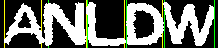

Running tally::: correct: 674 total: 688 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
EM
[4, 32]
[35, 85]
model 3: EM 0.764
[0, 36]
[36, 88]
edit distance: 0


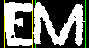

Running tally::: correct: 675 total: 689 accuracy: 0.980 avgEditDist 0.020
special window 120 128 ['T 0.98 ', 'N 0.84 ', 'A 0.02 ', 'I 0.02 ', 'H 0.01 ']
New example, correct answers:
NHNTAE
[4, 45, 85, 123, 153, 193]
[48, 87, 125, 162, 196, 234]
model 3: NHNTAE 0.442
[0, 48, 88, 128, 160, 196]
[48, 88, 124, 160, 196, 236]
edit distance: 0


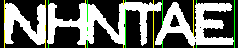

Running tally::: correct: 676 total: 690 accuracy: 0.980 avgEditDist 0.020
special window 68 84 ['I 1.00 ', 'D 0.98 ', 'F 0.95 ', 'A 0.02 ', 'L 0.01 ']
New example, correct answers:
NDIP
[4, 39, 72, 81]
[42, 74, 82, 118]
model 3: NDIP 0.735
[0, 40, 68, 84]
[40, 72, 84, 120]
edit distance: 0


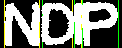

Running tally::: correct: 677 total: 691 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
OOTLTA
[4, 50, 96, 130, 162, 197]
[51, 97, 131, 168, 200, 239]
model 3: OOTLTA 0.411
[0, 44, 92, 132, 164, 200]
[44, 92, 132, 164, 200, 240]
edit distance: 0


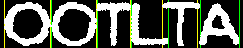

Running tally::: correct: 678 total: 692 accuracy: 0.980 avgEditDist 0.020
special window 0 16 ['I 1.00 ', 'E 0.99 ', 'V 0.18 ', 'T 0.09 ', 'L 0.06 ']
New example, correct answers:
IEA
[4, 11, 42]
[14, 44, 85]
model 3: IEA 0.815
[0, 12, 44]
[16, 44, 88]
edit distance: 0


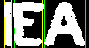

Running tally::: correct: 679 total: 693 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
BE
[4, 37]
[40, 72]
model 3: BE 0.806
[0, 40]
[40, 72]
edit distance: 0


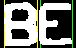

Running tally::: correct: 680 total: 694 accuracy: 0.980 avgEditDist 0.020
special window 0 8 ['L 0.98 ', 'V 0.12 ', 'T 0.11 ', 'Y 0.03 ', 'A 0.03 ']
special window 92 100 ['F 0.99 ', 'V 0.60 ', 'W 0.37 ', 'U 0.03 ', 'J 0.01 ']
New example, correct answers:
LWFR
[4, 35, 93, 124]
[37, 95, 126, 160]
model 3: LWFR 0.615
[4, 36, 96, 124]
[36, 92, 124, 160]
edit distance: 0


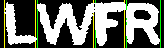

Running tally::: correct: 681 total: 695 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
TRRE
[4, 47, 86, 122]
[49, 87, 124, 162]
model 3: TRRE 0.716
[0, 48, 80, 124]
[48, 84, 124, 164]
edit distance: 0


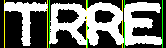

Running tally::: correct: 682 total: 696 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
ASV
[4, 42, 79]
[45, 80, 121]
model 3: ASV 0.762
[0, 44, 80]
[44, 80, 124]
edit distance: 0


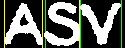

Running tally::: correct: 683 total: 697 accuracy: 0.980 avgEditDist 0.020
special window 40 48 ['E 0.99 ', 'D 0.34 ', 'O 0.19 ', 'V 0.03 ', 'L 0.02 ']
New example, correct answers:
DELA
[4, 41, 77, 112]
[44, 82, 114, 156]
model 3: DELA 0.682
[0, 44, 80, 112]
[40, 80, 112, 156]
edit distance: 0


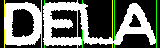

Running tally::: correct: 684 total: 698 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
EA
[4, 34]
[36, 74]
model 3: EA 0.832
[0, 36]
[36, 76]
edit distance: 0


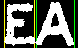

Running tally::: correct: 685 total: 699 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
RGRVES
[4, 40, 79, 114, 150, 185]
[45, 82, 117, 151, 186, 223]
model 3: RGRVES 0.471
[0, 40, 80, 116, 152, 184]
[40, 80, 116, 152, 184, 224]
edit distance: 0


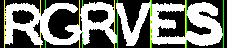

Running tally::: correct: 686 total: 700 accuracy: 0.980 avgEditDist 0.020
special window 0 16 ['I 1.00 ', 'L 0.98 ', 'V 0.16 ', 'T 0.12 ', 'Y 0.03 ']
special window 172 180 ['H 0.48 ', 'T 0.07 ', 'J 0.07 ', 'V 0.04 ', 'L 0.02 ']
New example, correct answers:
ILNAH
[4, 12, 46, 84, 136]
[17, 47, 86, 138, 178]
model 3: ILNAH 0.591
[0, 12, 48, 88, 136]
[16, 48, 88, 136, 172]
edit distance: 0


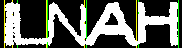

Running tally::: correct: 687 total: 701 accuracy: 0.980 avgEditDist 0.020
special window 72 84 ['I 1.00 ', 'N 0.79 ', 'V 0.64 ', 'W 0.02 ', 'H 0.01 ']
New example, correct answers:
GNIVES
[4, 38, 74, 83, 119, 157]
[40, 77, 85, 121, 158, 192]
model 3: GNIVES 0.588
[0, 40, 72, 84, 120, 156]
[40, 76, 84, 120, 156, 192]
edit distance: 0


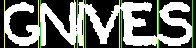

Running tally::: correct: 688 total: 702 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
RV
[4, 46]
[50, 85]
model 3: RV 0.783
[0, 48]
[48, 88]
edit distance: 0


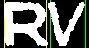

Running tally::: correct: 689 total: 703 accuracy: 0.980 avgEditDist 0.020
special window 128 136 ['T 0.99 ', 'N 0.95 ', 'I 0.08 ', 'V 0.04 ', 'A 0.02 ']
New example, correct answers:
LRENT
[4, 34, 68, 99, 135]
[36, 69, 100, 136, 170]
model 3: LRENT 0.500
[0, 36, 68, 96, 136]
[36, 68, 100, 128, 172]
edit distance: 0


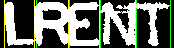

Running tally::: correct: 690 total: 704 accuracy: 0.980 avgEditDist 0.020
special window 88 96 ['F 0.97 ', 'H 0.96 ', 'A 0.03 ', 'I 0.01 ', 'J 0.01 ']
New example, correct answers:
WHFKAO
[4, 55, 94, 131, 167, 211]
[57, 95, 132, 169, 213, 253]
model 3: WHFKAO 0.528
[0, 56, 96, 132, 168, 212]
[56, 92, 132, 168, 212, 256]
edit distance: 0


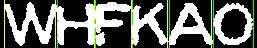

Running tally::: correct: 691 total: 705 accuracy: 0.980 avgEditDist 0.020
special window 112 120 ['L 0.99 ', 'N 0.88 ', 'T 0.02 ', 'V 0.01 ', 'Y 0.01 ']
New example, correct answers:
DANL
[4, 36, 74, 118]
[43, 76, 119, 154]
model 3: DANL 0.616
[0, 40, 76, 120]
[40, 76, 116, 156]
edit distance: 0


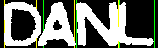

Running tally::: correct: 692 total: 706 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
KVPEGN
[4, 41, 85, 123, 157, 198]
[44, 86, 125, 159, 199, 239]
model 3: KVPEGN 0.467
[0, 44, 84, 124, 156, 196]
[44, 84, 124, 156, 196, 240]
edit distance: 0


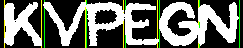

Running tally::: correct: 693 total: 707 accuracy: 0.980 avgEditDist 0.020
special window 156 172 ['I 0.99 ', 'A 0.86 ', 'T 0.82 ', 'H 0.01 ', 'F 0.00 ']
New example, correct answers:
VELAIT
[4, 50, 86, 119, 160, 166]
[52, 87, 120, 161, 168, 213]
model 3: VELAIT 0.573
[0, 48, 84, 120, 156, 168]
[48, 84, 120, 160, 172, 216]
edit distance: 0


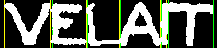

Running tally::: correct: 694 total: 708 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
FL
[4, 51]
[53, 90]
model 3: HFL 0.415
[0, 20, 52]
[24, 52, 92]
edit distance: 1
-----------------------------------------------------------------------------


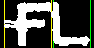

Running tally::: correct: 694 total: 709 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
SDA
[4, 43, 83]
[46, 85, 116]
model 3: SDA 0.721
[0, 44, 80]
[44, 80, 116]
edit distance: 0


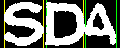

Running tally::: correct: 695 total: 710 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
EV
[4, 34]
[36, 80]
model 3: EV 0.809
[0, 36]
[36, 80]
edit distance: 0


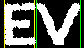

Running tally::: correct: 696 total: 711 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
VH
[4, 53]
[57, 91]
model 3: VH 0.758
[0, 48]
[48, 92]
edit distance: 0


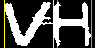

Running tally::: correct: 697 total: 712 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
KUOBRA
[4, 42, 75, 114, 147, 180]
[44, 77, 115, 148, 182, 223]
model 3: KUOBRA 0.489
[0, 40, 76, 112, 148, 184]
[40, 76, 112, 148, 184, 224]
edit distance: 0


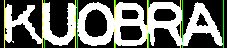

Running tally::: correct: 698 total: 713 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
URA
[4, 47, 81]
[49, 83, 127]
model 3: URA 0.713
[0, 48, 84]
[48, 84, 128]
edit distance: 0


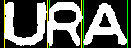

Running tally::: correct: 699 total: 714 accuracy: 0.979 avgEditDist 0.021
special window 36 44 ['N 0.98 ', 'S 0.94 ', 'V 0.01 ', 'Y 0.01 ', 'T 0.01 ']
New example, correct answers:
NS
[4, 42]
[45, 77]
model 3: NS 0.835
[0, 44]
[40, 80]
edit distance: 0


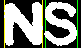

Running tally::: correct: 700 total: 715 accuracy: 0.979 avgEditDist 0.021
special window 44 52 ['A 0.89 ', 'M 0.79 ', 'J 0.01 ', 'N 0.01 ', 'I 0.01 ']
New example, correct answers:
AMA
[4, 45, 90]
[47, 91, 145]
model 3: AMA 0.570
[0, 48, 100]
[44, 100, 148]
edit distance: 0


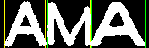

Running tally::: correct: 701 total: 716 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ENL
[4, 32, 67]
[34, 68, 105]
model 3: ENL 0.734
[0, 32, 68]
[36, 68, 108]
edit distance: 0


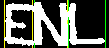

Running tally::: correct: 702 total: 717 accuracy: 0.979 avgEditDist 0.021
special window 0 16 ['I 0.99 ', 'N 0.40 ', 'V 0.23 ', 'H 0.07 ', 'M 0.06 ']
special window 164 172 ['R 0.97 ', 'N 0.84 ', 'V 0.03 ', 'I 0.02 ', 'T 0.01 ']
New example, correct answers:
INATNR
[4, 14, 48, 91, 125, 165]
[16, 50, 94, 126, 167, 206]
model 3: INATNR 0.538
[0, 16, 52, 92, 124, 168]
[16, 52, 92, 124, 164, 208]
edit distance: 0


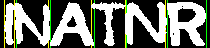

Running tally::: correct: 703 total: 718 accuracy: 0.979 avgEditDist 0.021
special window 148 156 ['A 0.82 ', 'M 0.52 ', 'J 0.45 ', 'N 0.03 ', 'H 0.03 ']
New example, correct answers:
LCRMA
[4, 30, 67, 104, 152]
[40, 70, 106, 154, 201]
model 3: LCRMA 0.548
[0, 32, 68, 104, 156]
[32, 68, 104, 152, 204]
edit distance: 0


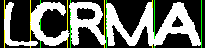

Running tally::: correct: 704 total: 719 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ORORD
[4, 44, 76, 117, 149]
[46, 78, 118, 151, 191]
model 3: ORORD 0.505
[0, 44, 80, 116, 152]
[44, 80, 116, 152, 192]
edit distance: 0


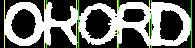

Running tally::: correct: 705 total: 720 accuracy: 0.979 avgEditDist 0.021
special window 80 88 ['N 0.91 ', 'C 0.90 ', 'O 0.02 ', 'V 0.01 ', 'T 0.01 ']
New example, correct answers:
ANCU
[4, 44, 87, 124]
[47, 88, 125, 161]
model 3: ANCU 0.643
[0, 44, 88, 124]
[44, 84, 124, 164]
edit distance: 0


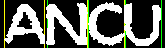

Running tally::: correct: 706 total: 721 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
ECDKU
[4, 39, 78, 116, 153]
[40, 80, 118, 155, 189]
model 3: ECDKU 0.526
[0, 40, 80, 116, 152]
[40, 80, 116, 152, 192]
edit distance: 0


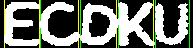

Running tally::: correct: 707 total: 722 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
KSLE
[4, 39, 72, 107]
[41, 73, 109, 140]
model 3: KSLE 0.679
[0, 40, 72, 108]
[40, 72, 108, 140]
edit distance: 0


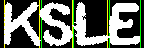

Running tally::: correct: 708 total: 723 accuracy: 0.979 avgEditDist 0.021
special window 0 16 ['I 1.00 ', 'R 0.97 ', 'V 0.17 ', 'F 0.08 ', 'T 0.07 ']
New example, correct answers:
IRHE
[4, 14, 47, 81]
[16, 51, 83, 121]
model 3: IRHE 0.721
[0, 16, 48, 84]
[16, 48, 84, 124]
edit distance: 0


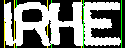

Running tally::: correct: 709 total: 724 accuracy: 0.979 avgEditDist 0.021
special window 88 96 ['N 0.94 ', 'W 0.64 ', 'V 0.03 ', 'F 0.02 ', 'T 0.01 ']
special window 124 132 ['V 0.54 ', 'N 0.33 ', 'Y 0.09 ', 'T 0.04 ', 'L 0.03 ']
New example, correct answers:
AWN
[4, 39, 88]
[46, 90, 130]
model 3: AWN 0.657
[0, 40, 96]
[40, 88, 128]
edit distance: 0


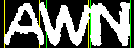

Running tally::: correct: 710 total: 725 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
DT
[4, 46]
[48, 84]
model 3: DT 0.575
[0, 40]
[40, 84]
edit distance: 0


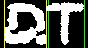

Running tally::: correct: 711 total: 726 accuracy: 0.979 avgEditDist 0.021
special window 48 56 ['F 0.99 ', 'M 0.69 ', 'J 0.06 ', 'L 0.01 ', 'I 0.01 ']
special window 88 96 ['E 1.00 ', 'F 0.66 ', 'T 0.07 ', 'V 0.02 ', 'A 0.02 ']
New example, correct answers:
MFEL
[4, 53, 87, 122]
[55, 89, 124, 162]
model 3: MFEL 0.657
[0, 56, 92, 124]
[48, 88, 124, 164]
edit distance: 0


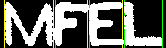

Running tally::: correct: 712 total: 727 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
AEAVLS
[4, 44, 74, 111, 150, 190]
[46, 75, 120, 152, 191, 225]
model 3: AEAVLS 0.475
[0, 44, 76, 116, 152, 188]
[44, 76, 116, 152, 188, 228]
edit distance: 0


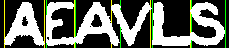

Running tally::: correct: 713 total: 728 accuracy: 0.979 avgEditDist 0.021
New example, correct answers:
MGP
[4, 54, 95]
[57, 97, 133]
model 3: MGP 0.715
[0, 56, 96]
[56, 96, 136]
edit distance: 0


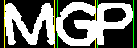

Running tally::: correct: 714 total: 729 accuracy: 0.979 avgEditDist 0.021
special window 120 128 ['F 0.95 ', 'T 0.75 ', 'V 0.06 ', 'M 0.02 ', 'P 0.01 ']
New example, correct answers:
VNTPH
[4, 40, 79, 121, 163]
[43, 80, 123, 164, 204]
model 3: VNTPH 0.564
[0, 40, 80, 124, 164]
[40, 80, 120, 164, 204]
edit distance: 0


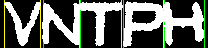

Running tally::: correct: 715 total: 730 accuracy: 0.979 avgEditDist 0.021
special window 136 144 ['K 0.99 ', 'V 0.66 ', 'Y 0.02 ', 'A 0.01 ', 'J 0.01 ']
New example, correct answers:
AAVKR
[4, 47, 88, 136, 172]
[49, 95, 138, 176, 210]
model 3: AAVKR 0.538
[0, 44, 92, 140, 176]
[48, 92, 136, 176, 212]
edit distance: 0


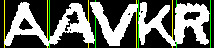

Running tally::: correct: 716 total: 731 accuracy: 0.979 avgEditDist 0.021
special window 120 128 ['P 0.83 ', 'R 0.71 ', 'F 0.55 ', 'N 0.02 ', 'G 0.02 ']
New example, correct answers:
OVPRFE
[4, 44, 82, 119, 161, 198]
[46, 84, 121, 163, 200, 234]
model 3: OVPRFE 0.460
[0, 44, 84, 124, 164, 196]
[44, 84, 120, 164, 196, 236]
edit distance: 0


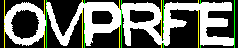

Running tally::: correct: 717 total: 732 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
NE
[4, 41]
[43, 73]
model 3: NE 0.821
[0, 44]
[44, 76]
edit distance: 0


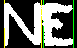

Running tally::: correct: 718 total: 733 accuracy: 0.980 avgEditDist 0.020
special window 160 168 ['R 0.99 ', 'D 0.77 ', 'V 0.04 ', 'J 0.04 ', 'N 0.02 ']
New example, correct answers:
THNORO
[4, 41, 77, 116, 163, 201]
[46, 78, 119, 165, 202, 240]
model 3: THNORO 0.517
[0, 44, 80, 120, 164, 200]
[44, 80, 120, 160, 200, 240]
edit distance: 0


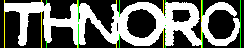

Running tally::: correct: 719 total: 734 accuracy: 0.980 avgEditDist 0.020
special window 36 44 ['N 0.98 ', 'T 0.92 ', 'I 0.01 ', 'V 0.01 ', 'H 0.01 ']
New example, correct answers:
NTFOS
[4, 41, 84, 112, 157]
[43, 85, 114, 158, 195]
model 3: NTFOS 0.564
[0, 44, 84, 116, 156]
[40, 84, 116, 156, 196]
edit distance: 0


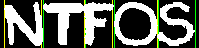

Running tally::: correct: 720 total: 735 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
TAFA
[4, 34, 72, 96]
[40, 73, 101, 139]
model 3: TAFA 0.537
[0, 36, 72, 100]
[36, 72, 100, 140]
edit distance: 0


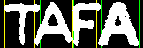

Running tally::: correct: 721 total: 736 accuracy: 0.980 avgEditDist 0.020
special window 64 80 ['I 1.00 ', 'E 0.98 ', 'B 0.01 ', 'F 0.01 ', 'G 0.00 ']
New example, correct answers:
EEIES
[4, 31, 64, 75, 115]
[34, 66, 76, 116, 147]
model 3: EEIES 0.621
[0, 32, 64, 80, 116]
[36, 64, 80, 116, 148]
edit distance: 0


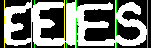

Running tally::: correct: 722 total: 737 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
SR
[4, 39]
[40, 75]
model 3: SR 0.839
[0, 40]
[40, 76]
edit distance: 0


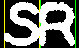

Running tally::: correct: 723 total: 738 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
MW
[4, 55]
[58, 115]
model 3: MW 0.824
[0, 56]
[56, 116]
edit distance: 0


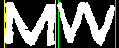

Running tally::: correct: 724 total: 739 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
GA
[4, 43]
[46, 93]
model 3: GA 0.743
[0, 48]
[48, 96]
edit distance: 0


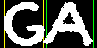

Running tally::: correct: 725 total: 740 accuracy: 0.980 avgEditDist 0.020
New example, correct answers:
OUR
[4, 48, 81]
[50, 83, 139]
model 3: OURL 0.447
[0, 48, 80, 112]
[48, 80, 116, 140]
edit distance: 1
-----------------------------------------------------------------------------


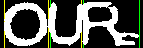

Running tally::: correct: 725 total: 741 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LCVRP
[4, 36, 71, 113, 144]
[38, 73, 114, 146, 187]
model 3: LCVBP 0.399
[0, 36, 72, 112, 148]
[40, 72, 112, 148, 188]
edit distance: 1
-----------------------------------------------------------------------------


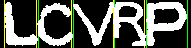

Running tally::: correct: 725 total: 742 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CT
[4, 36]
[39, 71]
model 3: CT 0.756
[0, 36]
[36, 72]
edit distance: 0


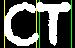

Running tally::: correct: 726 total: 743 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
GOVG
[4, 43, 78, 111]
[46, 83, 118, 150]
model 3: GOVG 0.554
[0, 44, 80, 112]
[44, 80, 112, 152]
edit distance: 0


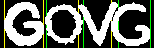

Running tally::: correct: 727 total: 744 accuracy: 0.977 avgEditDist 0.023
special window 156 164 ['N 0.88 ', 'T 0.84 ', 'I 0.15 ', 'V 0.03 ', 'H 0.01 ']
New example, correct answers:
CSONTL
[4, 41, 80, 123, 161, 203]
[46, 81, 124, 163, 205, 239]
model 3: CSONTL 0.521
[0, 44, 80, 120, 164, 204]
[44, 80, 120, 160, 208, 240]
edit distance: 0


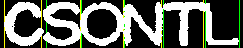

Running tally::: correct: 728 total: 745 accuracy: 0.977 avgEditDist 0.023
special window 112 120 ['E 1.00 ', 'F 0.51 ', 'V 0.04 ', 'T 0.03 ', 'A 0.02 ']
New example, correct answers:
CLFEO
[4, 42, 76, 113, 145]
[45, 78, 114, 151, 187]
model 3: CLFEO 0.478
[0, 44, 76, 116, 148]
[44, 76, 112, 148, 188]
edit distance: 0


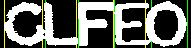

Running tally::: correct: 729 total: 746 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EEUL
[4, 32, 70, 106]
[36, 72, 107, 142]
model 3: EEUL 0.648
[0, 36, 72, 104]
[36, 72, 108, 144]
edit distance: 0


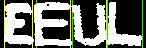

Running tally::: correct: 730 total: 747 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['D 0.67 ', 'V 0.15 ', 'T 0.14 ', 'C 0.09 ', 'L 0.08 ']
special window 116 124 ['N 0.99 ', 'T 0.83 ', 'V 0.08 ', 'I 0.02 ', 'W 0.02 ']
New example, correct answers:
DBTN
[4, 43, 78, 114]
[45, 80, 116, 149]
model 3: DBTN 0.606
[8, 44, 80, 120]
[44, 80, 116, 152]
edit distance: 0


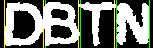

Running tally::: correct: 731 total: 748 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['V 0.22 ', 'M 0.19 ', 'J 0.07 ', 'T 0.04 ', 'Y 0.02 ']
New example, correct answers:
NRTS
[4, 47, 80, 116]
[48, 81, 121, 151]
model 3: NRTS 0.638
[8, 48, 80, 120]
[48, 80, 120, 152]
edit distance: 0


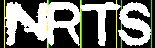

Running tally::: correct: 732 total: 749 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
VLL
[4, 43, 75]
[46, 77, 110]
model 3: VLL 0.743
[0, 44, 72]
[44, 76, 112]
edit distance: 0


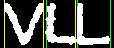

Running tally::: correct: 733 total: 750 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EVTRO
[4, 38, 75, 112, 154]
[39, 77, 114, 156, 193]
model 3: EVTRO 0.541
[0, 36, 76, 116, 152]
[36, 76, 116, 152, 196]
edit distance: 0


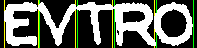

Running tally::: correct: 734 total: 751 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NVAV
[4, 39, 80, 131]
[41, 83, 133, 167]
model 3: NVAV 0.553
[0, 40, 84, 128]
[40, 84, 128, 168]
edit distance: 0


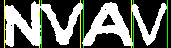

Running tally::: correct: 735 total: 752 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LN
[4, 43]
[45, 82]
model 3: LN 0.762
[0, 40]
[40, 84]
edit distance: 0


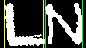

Running tally::: correct: 736 total: 753 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['I 1.00 ', 'E 0.99 ', 'V 0.17 ', 'T 0.11 ', 'L 0.07 ']
New example, correct answers:
IE
[4, 13]
[15, 41]
model 3: IE 0.861
[0, 12]
[16, 44]
edit distance: 0


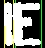

Running tally::: correct: 737 total: 754 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['C 0.95 ', 'H 0.95 ', 'V 0.02 ', 'O 0.02 ', 'U 0.01 ']
New example, correct answers:
HCLSNO
[4, 41, 78, 119, 159, 205]
[45, 80, 121, 161, 206, 249]
model 3: HCLSNO 0.462
[0, 44, 80, 120, 160, 204]
[40, 80, 120, 160, 204, 252]
edit distance: 0


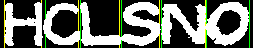

Running tally::: correct: 738 total: 755 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NWANEL
[4, 41, 92, 131, 169, 201]
[44, 99, 132, 172, 203, 243]
model 3: NWANEL 0.523
[0, 44, 96, 132, 172, 204]
[44, 96, 132, 172, 204, 244]
edit distance: 0


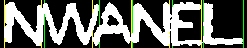

Running tally::: correct: 739 total: 756 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
VDN
[4, 44, 76]
[47, 81, 130]
model 3: VDN 0.606
[0, 44, 84]
[44, 84, 132]
edit distance: 0


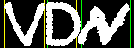

Running tally::: correct: 740 total: 757 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
THMVO
[4, 40, 79, 124, 162]
[43, 80, 126, 163, 202]
model 3: THMVO 0.551
[0, 44, 80, 124, 164]
[44, 80, 124, 164, 204]
edit distance: 0


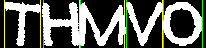

Running tally::: correct: 741 total: 758 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ESR
[4, 37, 71]
[38, 73, 106]
model 3: ESR 0.764
[0, 36, 72]
[36, 72, 108]
edit distance: 0


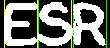

Running tally::: correct: 742 total: 759 accuracy: 0.978 avgEditDist 0.022
special window 80 88 ['T 0.94 ', 'N 0.89 ', 'A 0.02 ', 'V 0.01 ', 'H 0.01 ']
New example, correct answers:
NNT
[4, 44, 84]
[46, 86, 124]
model 3: NNT 0.696
[0, 44, 88]
[44, 84, 124]
edit distance: 0


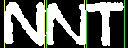

Running tally::: correct: 743 total: 760 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
CNUC
[4, 39, 77, 115]
[43, 78, 117, 153]
model 3: CNUC 0.649
[0, 40, 80, 116]
[40, 80, 116, 156]
edit distance: 0


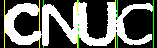

Running tally::: correct: 744 total: 761 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RNAATA
[4, 39, 73, 127, 158, 186]
[40, 79, 128, 164, 194, 227]
model 3: RNAATA 0.455
[0, 40, 80, 124, 160, 192]
[40, 80, 124, 160, 192, 228]
edit distance: 0


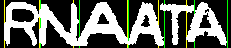

Running tally::: correct: 745 total: 762 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
BS
[4, 36]
[39, 68]
model 3: BS 0.815
[0, 36]
[36, 68]
edit distance: 0


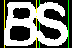

Running tally::: correct: 746 total: 763 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SKPL
[4, 35, 71, 109]
[39, 73, 110, 148]
model 3: SKPL 0.638
[0, 36, 72, 108]
[36, 72, 108, 148]
edit distance: 0


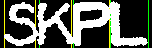

Running tally::: correct: 747 total: 764 accuracy: 0.978 avgEditDist 0.022
special window 32 48 ['I 1.00 ', 'S 0.96 ', 'A 0.69 ', 'H 0.01 ', 'G 0.01 ']
New example, correct answers:
SIAAB
[4, 35, 45, 89, 138]
[38, 47, 91, 140, 174]
model 3: SIAAB 0.668
[0, 32, 48, 96, 140]
[36, 48, 96, 140, 176]
edit distance: 0


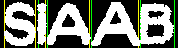

Running tally::: correct: 748 total: 765 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ACVA
[4, 40, 78, 122]
[44, 80, 124, 168]
model 3: ACVA 0.640
[0, 40, 80, 124]
[40, 80, 124, 168]
edit distance: 0


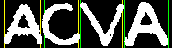

Running tally::: correct: 749 total: 766 accuracy: 0.978 avgEditDist 0.022
special window 80 96 ['I 1.00 ', 'H 0.79 ', 'J 0.30 ', 'D 0.15 ', 'O 0.12 ']
special window 128 136 ['H 0.96 ', 'U 0.65 ', 'L 0.07 ', 'V 0.04 ', 'I 0.02 ']
New example, correct answers:
AOIHU
[4, 45, 85, 93, 134]
[51, 87, 96, 135, 176]
model 3: AOIHU 0.622
[0, 48, 80, 96, 136]
[48, 84, 96, 132, 176]
edit distance: 0


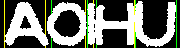

Running tally::: correct: 750 total: 767 accuracy: 0.978 avgEditDist 0.022
special window 0 12 ['I 1.00 ', 'L 0.30 ', 'V 0.21 ', 'T 0.16 ', 'D 0.15 ']
special window 116 124 ['P 0.98 ', 'S 0.96 ', 'F 0.03 ', 'A 0.02 ', 'T 0.01 ']
New example, correct answers:
IDTSP
[4, 9, 39, 79, 117]
[12, 48, 85, 119, 154]
model 3: IDTSP 0.532
[0, 12, 48, 84, 120]
[12, 48, 84, 116, 156]
edit distance: 0


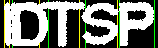

Running tally::: correct: 751 total: 768 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['D 0.42 ', 'V 0.15 ', 'T 0.14 ', 'C 0.12 ', 'L 0.11 ']
special window 80 92 ['E 1.00 ', 'N 0.89 ', 'V 0.05 ', 'S 0.01 ', 'Y 0.01 ']
New example, correct answers:
DNE
[4, 45, 90]
[49, 91, 122]
model 3: DNE 0.697
[8, 44, 92]
[44, 84, 124]
edit distance: 0


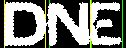

Running tally::: correct: 752 total: 769 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
AFEER
[4, 46, 81, 119, 156]
[48, 82, 120, 157, 196]
model 3: AFEER 0.540
[0, 48, 80, 116, 156]
[48, 80, 116, 156, 196]
edit distance: 0


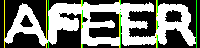

Running tally::: correct: 753 total: 770 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
HGLD
[4, 42, 78, 113]
[45, 80, 115, 151]
model 3: HGLD 0.637
[0, 44, 80, 116]
[44, 80, 116, 152]
edit distance: 0


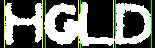

Running tally::: correct: 754 total: 771 accuracy: 0.978 avgEditDist 0.022
special window 100 116 ['I 1.00 ', 'N 0.78 ', 'G 0.77 ', 'H 0.01 ', 'C 0.01 ']
New example, correct answers:
WGIN
[4, 59, 100, 112]
[61, 102, 114, 152]
model 3: WGIN 0.742
[0, 60, 100, 112]
[60, 100, 116, 152]
edit distance: 0


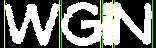

Running tally::: correct: 755 total: 772 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
PTORP
[4, 42, 72, 112, 145]
[44, 77, 114, 147, 187]
model 3: PTORP 0.504
[0, 44, 76, 112, 148]
[44, 76, 112, 148, 188]
edit distance: 0


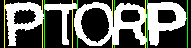

Running tally::: correct: 756 total: 773 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
SV
[4, 29]
[38, 70]
model 3: SV 0.728
[0, 32]
[36, 72]
edit distance: 0


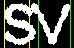

Running tally::: correct: 757 total: 774 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LGF
[4, 42, 80]
[43, 81, 116]
model 3: LGF 0.664
[0, 40, 80]
[40, 80, 116]
edit distance: 0


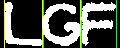

Running tally::: correct: 758 total: 775 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
EALO
[4, 34, 74, 109]
[36, 76, 116, 149]
model 3: EALO 0.641
[0, 36, 76, 112]
[36, 76, 112, 152]
edit distance: 0


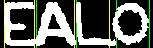

Running tally::: correct: 759 total: 776 accuracy: 0.978 avgEditDist 0.022
special window 48 56 ['P 0.98 ', 'A 0.74 ', 'V 0.02 ', 'G 0.01 ', 'Y 0.01 ']
New example, correct answers:
AP
[4, 47]
[50, 89]
model 3: AP 0.814
[0, 52]
[48, 92]
edit distance: 0


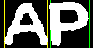

Running tally::: correct: 760 total: 777 accuracy: 0.978 avgEditDist 0.022
special window 36 44 ['D 0.97 ', 'N 0.90 ', 'A 0.01 ', 'I 0.01 ', 'H 0.01 ']
special window 112 120 ['E 0.99 ', 'H 0.96 ', 'A 0.04 ', 'I 0.01 ', 'V 0.01 ']
New example, correct answers:
DNHER
[4, 37, 79, 118, 154]
[40, 81, 119, 155, 187]
model 3: DNHER 0.616
[0, 40, 80, 120, 152]
[36, 80, 116, 152, 188]
edit distance: 0


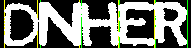

Running tally::: correct: 761 total: 778 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
LHO
[4, 40, 75]
[41, 77, 114]
model 3: LHO 0.734
[0, 40, 76]
[40, 76, 116]
edit distance: 0


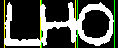

Running tally::: correct: 762 total: 779 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
TDL
[4, 42, 70]
[45, 72, 108]
model 3: TDL 0.709
[0, 40, 72]
[44, 72, 108]
edit distance: 0


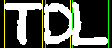

Running tally::: correct: 763 total: 780 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['D 0.73 ', 'T 0.15 ', 'V 0.14 ', 'C 0.12 ', 'L 0.08 ']
New example, correct answers:
DPC
[4, 44, 77]
[46, 78, 113]
model 3: DPC 0.717
[8, 44, 76]
[44, 76, 116]
edit distance: 0


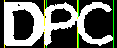

Running tally::: correct: 764 total: 781 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
GDD
[4, 46, 84]
[50, 86, 120]
model 3: GDD 0.699
[0, 48, 84]
[48, 84, 120]
edit distance: 0


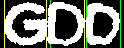

Running tally::: correct: 765 total: 782 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
RFGSV
[4, 36, 70, 104, 135]
[37, 72, 108, 143, 176]
model 3: RFGSV 0.511
[0, 40, 72, 108, 140]
[40, 72, 108, 140, 176]
edit distance: 0


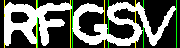

Running tally::: correct: 766 total: 783 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
NASL
[4, 40, 83, 116]
[43, 84, 118, 159]
model 3: WASL 0.486
[0, 44, 84, 120]
[44, 84, 120, 160]
edit distance: 1
-----------------------------------------------------------------------------


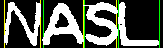

Running tally::: correct: 766 total: 784 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['N 0.99 ', 'V 0.17 ', 'T 0.08 ', 'L 0.05 ', 'A 0.02 ']
New example, correct answers:
NROSPH
[4, 37, 68, 107, 141, 170]
[40, 70, 109, 142, 173, 211]
model 3: NROSPH 0.530
[4, 40, 72, 108, 140, 172]
[40, 72, 108, 140, 172, 212]
edit distance: 0


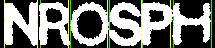

Running tally::: correct: 767 total: 785 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OOTN
[4, 48, 89, 123]
[51, 92, 124, 162]
model 3: OOTN 0.619
[0, 44, 92, 124]
[44, 92, 128, 164]
edit distance: 0


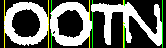

Running tally::: correct: 768 total: 786 accuracy: 0.977 avgEditDist 0.023
special window 44 52 ['L 0.99 ', 'A 0.86 ', 'N 0.06 ', 'V 0.06 ', 'W 0.02 ']
New example, correct answers:
ALOATF
[4, 45, 70, 109, 147, 184]
[49, 78, 114, 149, 186, 215]
model 3: ALOATF 0.452
[0, 48, 76, 112, 148, 184]
[44, 76, 112, 148, 188, 216]
edit distance: 0


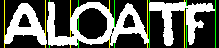

Running tally::: correct: 769 total: 787 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EETETA
[4, 45, 81, 120, 156, 197]
[47, 83, 123, 157, 204, 239]
model 3: EETETA 0.473
[0, 40, 80, 124, 156, 196]
[40, 80, 124, 156, 196, 240]
edit distance: 0


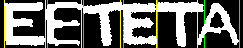

Running tally::: correct: 770 total: 788 accuracy: 0.977 avgEditDist 0.023
special window 64 72 ['P 0.83 ', 'V 0.80 ', 'F 0.15 ', 'W 0.04 ', 'Y 0.01 ']
New example, correct answers:
WP
[4, 67]
[68, 103]
model 3: WP 0.810
[0, 68]
[64, 104]
edit distance: 0


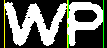

Running tally::: correct: 771 total: 789 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
BRR
[4, 39, 73]
[40, 75, 110]
model 3: BRR 0.758
[0, 40, 72]
[40, 76, 112]
edit distance: 0


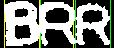

Running tally::: correct: 772 total: 790 accuracy: 0.977 avgEditDist 0.023
special window 76 92 ['I 1.00 ', 'C 0.90 ', 'N 0.77 ', 'O 0.04 ', 'W 0.01 ']
New example, correct answers:
DNION
[4, 36, 81, 88, 124]
[39, 82, 90, 126, 168]
model 3: DNION 0.645
[0, 36, 76, 92, 124]
[36, 80, 92, 124, 168]
edit distance: 0


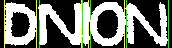

Running tally::: correct: 773 total: 791 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CN
[4, 44]
[46, 83]
model 3: CN 0.799
[0, 44]
[44, 84]
edit distance: 0


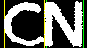

Running tally::: correct: 774 total: 792 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['E 1.00 ', 'H 0.86 ', 'A 0.03 ', 'V 0.03 ', 'I 0.01 ']
New example, correct answers:
HEVM
[4, 41, 75, 119]
[43, 77, 121, 179]
model 3: HEVM 0.552
[0, 44, 76, 120]
[40, 76, 120, 180]
edit distance: 0


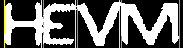

Running tally::: correct: 775 total: 793 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OS
[4, 40]
[44, 75]
model 3: OS 0.822
[0, 40]
[40, 76]
edit distance: 0


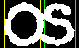

Running tally::: correct: 776 total: 794 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OHAOVU
[4, 36, 72, 113, 149, 200]
[38, 75, 115, 151, 201, 237]
model 3: OHAOVU 0.476
[0, 36, 76, 116, 152, 196]
[36, 76, 116, 152, 196, 240]
edit distance: 0


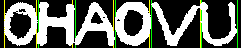

Running tally::: correct: 777 total: 795 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
AAH
[4, 45, 82]
[47, 84, 124]
model 3: AAH 0.791
[0, 44, 84]
[48, 84, 124]
edit distance: 0


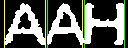

Running tally::: correct: 778 total: 796 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['F 0.99 ', 'V 0.15 ', 'J 0.05 ', 'T 0.05 ', 'L 0.04 ']
New example, correct answers:
PEWA
[4, 44, 79, 137]
[46, 80, 143, 182]
model 3: PEWA 0.617
[8, 44, 80, 140]
[44, 80, 140, 184]
edit distance: 0


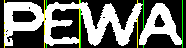

Running tally::: correct: 779 total: 797 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['F 0.99 ', 'V 0.14 ', 'J 0.09 ', 'T 0.04 ', 'L 0.04 ']
special window 104 120 ['I 0.97 ', 'L 0.86 ', 'T 0.08 ', 'V 0.05 ', 'A 0.02 ']
New example, correct answers:
FELI
[4, 37, 68, 107]
[40, 70, 108, 117]
model 3: FELI 0.698
[4, 36, 68, 104]
[36, 68, 104, 120]
edit distance: 0


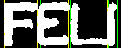

Running tally::: correct: 780 total: 798 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SA
[4, 35]
[38, 75]
model 3: SA 0.816
[0, 36]
[36, 76]
edit distance: 0


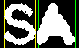

Running tally::: correct: 781 total: 799 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
WLPPS
[4, 53, 88, 122, 158]
[55, 89, 124, 160, 193]
model 3: WLPPS 0.543
[0, 52, 88, 120, 160]
[52, 88, 120, 160, 196]
edit distance: 0


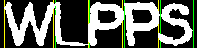

Running tally::: correct: 782 total: 800 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
BM
[4, 41]
[42, 93]
model 3: BM 0.804
[0, 40]
[40, 96]
edit distance: 0


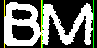

Running tally::: correct: 783 total: 801 accuracy: 0.978 avgEditDist 0.022
special window 156 172 ['K 0.98 ', 'A 0.67 ', 'G 0.03 ', 'V 0.02 ', 'H 0.01 ']
New example, correct answers:
SLOAKA
[4, 40, 75, 116, 158, 206]
[42, 77, 117, 160, 207, 248]
model 3: SLOAKA 0.495
[0, 40, 76, 116, 168, 200]
[40, 76, 116, 156, 204, 248]
edit distance: 0


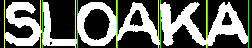

Running tally::: correct: 784 total: 802 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
NNO
[4, 44, 84]
[46, 86, 130]
model 3: NNO 0.730
[0, 44, 84]
[44, 84, 132]
edit distance: 0


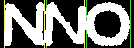

Running tally::: correct: 785 total: 803 accuracy: 0.978 avgEditDist 0.022
special window 0 8 ['L 0.98 ', 'V 0.12 ', 'T 0.10 ', 'Y 0.03 ', 'J 0.03 ']
special window 84 96 ['M 0.69 ', 'I 0.66 ', 'G 0.57 ', 'V 0.11 ', 'N 0.09 ']
special window 168 180 ['I 1.00 ', 'E 0.97 ', 'T 0.90 ', 'A 0.02 ', 'M 0.01 ']
New example, correct answers:
LMGTIB
[4, 42, 91, 128, 170, 180]
[45, 93, 133, 172, 181, 216]
model 3: LMIGTIB 0.539
[4, 44, 84, 96, 132, 168, 180]
[44, 88, 96, 132, 172, 180, 216]
edit distance: 1
-----------------------------------------------------------------------------


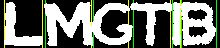

Running tally::: correct: 785 total: 804 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RAE
[4, 38, 87]
[41, 89, 119]
model 3: RAE 0.716
[0, 40, 88]
[40, 88, 120]
edit distance: 0


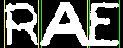

Running tally::: correct: 786 total: 805 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RA
[4, 40]
[42, 83]
model 3: RA 0.801
[0, 44]
[44, 84]
edit distance: 0


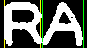

Running tally::: correct: 787 total: 806 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NNE
[4, 38, 78]
[39, 79, 117]
model 3: NNE 0.729
[0, 40, 80]
[40, 80, 120]
edit distance: 0


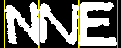

Running tally::: correct: 788 total: 807 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['L 0.98 ', 'V 0.12 ', 'T 0.10 ', 'Y 0.03 ', 'J 0.03 ']
special window 124 132 ['H 0.99 ', 'N 0.85 ', 'V 0.02 ', 'L 0.01 ', 'A 0.01 ']
New example, correct answers:
LCNHL
[4, 39, 81, 125, 158]
[45, 83, 127, 159, 194]
model 3: LCNHL 0.550
[4, 44, 84, 128, 160]
[44, 84, 124, 160, 196]
edit distance: 0


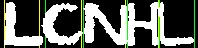

Running tally::: correct: 789 total: 808 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PO
[4, 38]
[40, 80]
model 3: PO 0.757
[0, 40]
[40, 80]
edit distance: 0


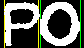

Running tally::: correct: 790 total: 809 accuracy: 0.977 avgEditDist 0.023
special window 124 136 ['H 0.91 ', 'A 0.76 ', 'J 0.01 ', 'P 0.01 ', 'F 0.00 ']
New example, correct answers:
LMHAE
[4, 40, 90, 132, 180]
[43, 92, 134, 183, 214]
model 3: LMHAE 0.609
[0, 40, 92, 136, 180]
[40, 92, 128, 180, 216]
edit distance: 0


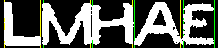

Running tally::: correct: 791 total: 810 accuracy: 0.977 avgEditDist 0.023
special window 80 96 ['I 0.98 ', 'J 0.94 ', 'V 0.10 ', 'U 0.06 ', 'T 0.06 ']
New example, correct answers:
RUI
[4, 41, 80]
[42, 82, 93]
model 3: RUI 0.791
[0, 40, 80]
[40, 80, 96]
edit distance: 0


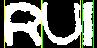

Running tally::: correct: 792 total: 811 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['L 0.97 ', 'V 0.13 ', 'T 0.11 ', 'Y 0.03 ', 'A 0.03 ']
New example, correct answers:
LOSHHR
[4, 35, 75, 116, 149, 189]
[38, 77, 117, 151, 190, 225]
model 3: LOSHHR 0.512
[4, 36, 76, 116, 152, 188]
[36, 76, 116, 152, 188, 228]
edit distance: 0


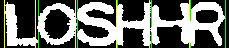

Running tally::: correct: 793 total: 812 accuracy: 0.977 avgEditDist 0.023
special window 144 152 ['E 0.99 ', 'N 0.96 ', 'I 0.01 ', 'V 0.01 ', 'A 0.01 ']
New example, correct answers:
FTVNE
[4, 30, 73, 111, 150]
[33, 74, 113, 152, 185]
model 3: FTVNE 0.566
[0, 28, 76, 112, 152]
[32, 76, 112, 148, 188]
edit distance: 0


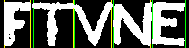

Running tally::: correct: 794 total: 813 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SOLS
[4, 40, 78, 109]
[42, 80, 114, 145]
model 3: SOLS 0.671
[0, 40, 80, 112]
[40, 80, 112, 148]
edit distance: 0


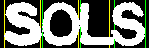

Running tally::: correct: 795 total: 814 accuracy: 0.977 avgEditDist 0.023
special window 120 136 ['I 1.00 ', 'C 0.95 ', 'N 0.80 ', 'O 0.02 ', 'V 0.02 ']
New example, correct answers:
LONION
[4, 39, 83, 123, 132, 171]
[42, 85, 125, 133, 172, 213]
model 3: LONION 0.588
[0, 40, 84, 120, 136, 172]
[40, 84, 120, 136, 172, 216]
edit distance: 0


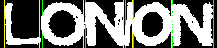

Running tally::: correct: 796 total: 815 accuracy: 0.977 avgEditDist 0.023
special window 124 136 ['I 1.00 ', 'L 0.90 ', 'S 0.85 ', 'J 0.16 ', 'V 0.06 ']
New example, correct answers:
NALIS
[4, 48, 89, 125, 133]
[49, 91, 127, 136, 168]
model 3: NALIS 0.587
[0, 48, 88, 124, 136]
[48, 88, 128, 136, 168]
edit distance: 0


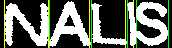

Running tally::: correct: 797 total: 816 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
PVLAE
[4, 38, 80, 108, 152]
[40, 82, 111, 153, 185]
model 3: PVLAE 0.553
[0, 40, 80, 112, 152]
[40, 80, 112, 152, 188]
edit distance: 0


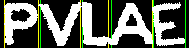

Running tally::: correct: 798 total: 817 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CEK
[4, 40, 67]
[42, 68, 104]
model 3: CEK 0.634
[0, 40, 68]
[40, 72, 104]
edit distance: 0


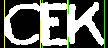

Running tally::: correct: 799 total: 818 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CTDE
[4, 40, 85, 116]
[43, 86, 119, 148]
model 3: CTDE 0.626
[0, 40, 84, 116]
[40, 84, 116, 148]
edit distance: 0


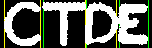

Running tally::: correct: 800 total: 819 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.99 ', 'V 0.13 ', 'T 0.10 ', 'L 0.05 ', 'A 0.04 ']
New example, correct answers:
ESAAOV
[4, 30, 63, 107, 147, 186]
[38, 65, 108, 148, 188, 227]
model 3: ESAAOV 0.475
[4, 32, 64, 108, 148, 188]
[36, 64, 112, 148, 188, 228]
edit distance: 0


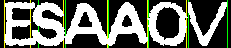

Running tally::: correct: 801 total: 820 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
AOA
[4, 47, 84]
[49, 86, 135]
model 3: AOA 0.682
[0, 48, 88]
[48, 88, 136]
edit distance: 0


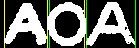

Running tally::: correct: 802 total: 821 accuracy: 0.977 avgEditDist 0.023
special window 44 60 ['I 1.00 ', 'L 0.93 ', 'N 0.70 ', 'V 0.02 ', 'G 0.00 ']
New example, correct answers:
NILE
[4, 47, 58, 91]
[50, 59, 92, 119]
model 3: NILE 0.712
[0, 44, 60, 92]
[44, 60, 92, 120]
edit distance: 0


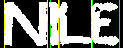

Running tally::: correct: 803 total: 822 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
TDEN
[4, 44, 82, 121]
[50, 84, 123, 165]
model 3: TDEN 0.661
[0, 48, 84, 124]
[48, 84, 124, 168]
edit distance: 0


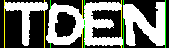

Running tally::: correct: 804 total: 823 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EEKVG
[4, 37, 69, 101, 133]
[38, 70, 108, 139, 174]
model 3: EEKVG 0.481
[0, 36, 68, 104, 136]
[36, 68, 104, 140, 176]
edit distance: 0


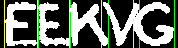

Running tally::: correct: 805 total: 824 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MD
[4, 46]
[50, 83]
model 3: MD 0.806
[0, 48]
[48, 84]
edit distance: 0


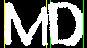

Running tally::: correct: 806 total: 825 accuracy: 0.977 avgEditDist 0.023
special window 76 84 ['H 0.98 ', 'S 0.95 ', 'E 0.18 ', 'A 0.03 ', 'V 0.03 ']
New example, correct answers:
NHSB
[4, 43, 81, 117]
[46, 83, 118, 147]
model 3: NHSB 0.673
[0, 44, 84, 116]
[44, 80, 116, 148]
edit distance: 0


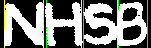

Running tally::: correct: 807 total: 826 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['R 0.95 ', 'V 0.13 ', 'J 0.11 ', 'F 0.06 ', 'T 0.06 ']
New example, correct answers:
RDTRO
[4, 42, 95, 125, 165]
[46, 96, 127, 166, 206]
model 3: ROTRO 0.400
[8, 52, 96, 128, 164]
[52, 96, 128, 164, 208]
edit distance: 1
-----------------------------------------------------------------------------


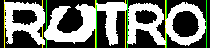

Running tally::: correct: 807 total: 827 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SSRE
[4, 40, 81, 113]
[42, 82, 115, 149]
model 3: SSRE 0.625
[0, 44, 80, 116]
[48, 80, 116, 152]
edit distance: 0


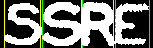

Running tally::: correct: 808 total: 828 accuracy: 0.976 avgEditDist 0.024
special window 112 120 ['I 0.89 ', 'L 0.73 ', 'J 0.10 ', 'T 0.06 ', 'V 0.06 ']
New example, correct answers:
LELI
[4, 40, 73, 109]
[44, 75, 111, 120]
model 3: LELI 0.746
[0, 40, 76, 112]
[40, 76, 112, 120]
edit distance: 0


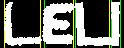

Running tally::: correct: 809 total: 829 accuracy: 0.976 avgEditDist 0.024
special window 72 80 ['I 0.98 ', 'L 0.86 ', 'V 0.37 ', 'H 0.06 ', 'J 0.04 ']
New example, correct answers:
SLIVR
[4, 36, 73, 80, 118]
[37, 74, 82, 119, 154]
model 3: SLIVR 0.502
[0, 36, 72, 80, 120]
[36, 72, 80, 124, 156]
edit distance: 0


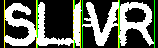

Running tally::: correct: 810 total: 830 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RO
[4, 43]
[46, 89]
model 3: RO 0.817
[0, 44]
[44, 92]
edit distance: 0


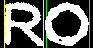

Running tally::: correct: 811 total: 831 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['I 1.00 ', 'L 0.98 ', 'V 0.18 ', 'T 0.10 ', 'Y 0.03 ']
New example, correct answers:
ILNE
[4, 13, 49, 90]
[16, 53, 91, 124]
model 3: ILNE 0.726
[0, 16, 52, 92]
[16, 52, 92, 124]
edit distance: 0


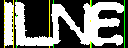

Running tally::: correct: 812 total: 832 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LN
[4, 37]
[42, 82]
model 3: LN 0.787
[0, 40]
[40, 84]
edit distance: 0


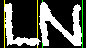

Running tally::: correct: 813 total: 833 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
DSR
[4, 42, 79]
[44, 80, 114]
model 3: DSR 0.723
[0, 40, 76]
[40, 76, 116]
edit distance: 0


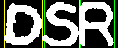

Running tally::: correct: 814 total: 834 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TEDUDO
[4, 49, 78, 111, 150, 184]
[51, 79, 115, 152, 186, 225]
model 3: TEDUDO 0.486
[0, 48, 76, 112, 152, 184]
[48, 76, 112, 152, 184, 228]
edit distance: 0


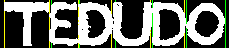

Running tally::: correct: 815 total: 835 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
PAROR
[4, 28, 66, 102, 142]
[37, 68, 108, 144, 184]
model 3: PAROR 0.481
[0, 32, 68, 108, 144]
[32, 68, 108, 144, 184]
edit distance: 0


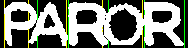

Running tally::: correct: 816 total: 836 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RERAE
[4, 45, 80, 115, 159]
[48, 82, 117, 160, 194]
model 3: RERAE 0.538
[0, 48, 80, 116, 160]
[48, 80, 116, 160, 196]
edit distance: 0


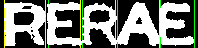

Running tally::: correct: 817 total: 837 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
WVUR
[4, 57, 102, 133]
[60, 103, 135, 178]
model 3: WVUR 0.660
[0, 60, 100, 136]
[60, 100, 136, 180]
edit distance: 0


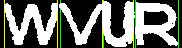

Running tally::: correct: 818 total: 838 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HEOH
[4, 35, 73, 119]
[37, 77, 121, 159]
model 3: HEOH 0.608
[0, 40, 76, 120]
[40, 76, 120, 160]
edit distance: 0


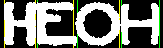

Running tally::: correct: 819 total: 839 accuracy: 0.976 avgEditDist 0.024
special window 144 152 ['R 0.95 ', 'T 0.95 ', 'F 0.04 ', 'V 0.03 ', 'N 0.02 ']
New example, correct answers:
DEOTRV
[4, 39, 64, 107, 145, 182]
[41, 71, 109, 146, 187, 221]
model 3: DEOTRV 0.405
[0, 36, 68, 108, 148, 188]
[36, 68, 108, 144, 188, 224]
edit distance: 0


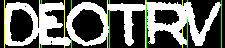

Running tally::: correct: 820 total: 840 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
MREVN
[4, 46, 81, 114, 148]
[48, 82, 118, 150, 186]
model 3: MREVN 0.473
[0, 48, 84, 112, 148]
[48, 84, 116, 152, 188]
edit distance: 0


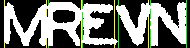

Running tally::: correct: 821 total: 841 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AW
[4, 38]
[46, 92]
model 3: AW 0.777
[0, 40]
[40, 92]
edit distance: 0


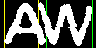

Running tally::: correct: 822 total: 842 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['I 0.97 ', 'W 0.59 ', 'V 0.24 ', 'T 0.06 ', 'U 0.05 ']
New example, correct answers:
IWR
[4, 14, 73]
[16, 74, 111]
model 3: IWR 0.832
[0, 16, 72]
[16, 72, 112]
edit distance: 0


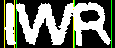

Running tally::: correct: 823 total: 843 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['N 0.88 ', 'M 0.67 ', 'I 0.01 ', 'H 0.01 ', 'J 0.01 ']
special window 88 96 ['M 0.81 ', 'V 0.63 ', 'J 0.02 ', 'T 0.02 ', 'Y 0.02 ']
New example, correct answers:
NMV
[4, 45, 93]
[48, 95, 139]
model 3: NMV 0.700
[0, 48, 96]
[44, 92, 140]
edit distance: 0


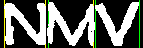

Running tally::: correct: 824 total: 844 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VACH
[4, 40, 76, 116]
[42, 77, 117, 152]
model 3: VACH 0.645
[0, 40, 76, 116]
[40, 76, 116, 152]
edit distance: 0


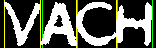

Running tally::: correct: 825 total: 845 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
EOKLEE
[4, 30, 70, 107, 141, 182]
[36, 71, 108, 143, 183, 216]
model 3: EOKLEE 0.446
[0, 36, 72, 108, 144, 176]
[36, 72, 108, 144, 180, 216]
edit distance: 0


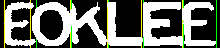

Running tally::: correct: 826 total: 846 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['E 0.99 ', 'I 0.99 ', 'V 0.18 ', 'T 0.09 ', 'L 0.07 ']
New example, correct answers:
IENSED
[4, 13, 45, 81, 119, 153]
[16, 46, 84, 121, 155, 192]
model 3: IENSED 0.593
[0, 16, 44, 84, 120, 156]
[16, 44, 84, 120, 156, 192]
edit distance: 0


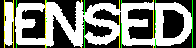

Running tally::: correct: 827 total: 847 accuracy: 0.976 avgEditDist 0.024
special window 36 44 ['R 0.99 ', 'S 0.97 ', 'V 0.06 ', 'W 0.02 ', 'T 0.01 ']
New example, correct answers:
SRVEL
[4, 39, 70, 115, 153]
[41, 72, 116, 155, 196]
model 3: SRVEL 0.540
[0, 40, 72, 116, 156]
[36, 72, 116, 156, 196]
edit distance: 0


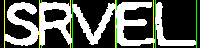

Running tally::: correct: 828 total: 848 accuracy: 0.976 avgEditDist 0.024
special window 84 92 ['N 0.89 ', 'J 0.88 ', 'U 0.17 ', 'D 0.02 ', 'I 0.01 ']
New example, correct answers:
VUNSD
[4, 47, 84, 126, 159]
[50, 86, 128, 161, 197]
model 3: VUNSD 0.619
[0, 48, 88, 128, 160]
[48, 84, 128, 160, 200]
edit distance: 0


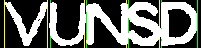

Running tally::: correct: 829 total: 849 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TDOV
[4, 42, 80, 120]
[45, 82, 124, 159]
model 3: TDOV 0.629
[0, 44, 76, 124]
[44, 80, 124, 160]
edit distance: 0


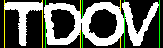

Running tally::: correct: 830 total: 850 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
DEADE
[4, 38, 70, 110, 150]
[40, 71, 112, 152, 185]
model 3: DEADE 0.550
[0, 40, 72, 112, 152]
[40, 72, 112, 152, 188]
edit distance: 0


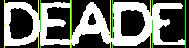

Running tally::: correct: 831 total: 851 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RVVO
[4, 29, 75, 109]
[37, 77, 110, 153]
model 3: RVVO 0.603
[0, 36, 76, 112]
[36, 76, 112, 156]
edit distance: 0


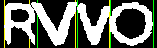

Running tally::: correct: 832 total: 852 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EEW
[4, 36, 70]
[38, 71, 121]
model 3: EEW 0.702
[0, 28, 68]
[32, 68, 124]
edit distance: 0


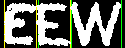

Running tally::: correct: 833 total: 853 accuracy: 0.977 avgEditDist 0.023
special window 188 204 ['I 1.00 ', 'N 0.92 ', 'V 0.12 ', 'T 0.05 ', 'L 0.04 ']
New example, correct answers:
SOAENI
[4, 38, 81, 119, 153, 190]
[41, 87, 120, 154, 192, 202]
model 3: SOAENI 0.584
[0, 40, 84, 120, 152, 188]
[40, 84, 120, 152, 188, 204]
edit distance: 0


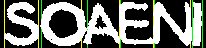

Running tally::: correct: 834 total: 854 accuracy: 0.977 avgEditDist 0.023
special window 40 56 ['I 0.99 ', 'R 0.79 ', 'W 0.61 ', 'V 0.02 ', 'G 0.01 ']
New example, correct answers:
RIWABC
[4, 41, 51, 99, 138, 177]
[44, 52, 108, 141, 179, 215]
model 3: RIWABC 0.532
[0, 40, 56, 104, 140, 176]
[40, 56, 104, 140, 176, 216]
edit distance: 0


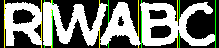

Running tally::: correct: 835 total: 855 accuracy: 0.977 avgEditDist 0.023
special window 148 156 ['H 0.99 ', 'A 0.97 ', 'U 0.01 ', 'T 0.01 ', 'N 0.01 ']
New example, correct answers:
OUAHAA
[4, 42, 77, 117, 154, 192]
[46, 79, 120, 155, 194, 231]
model 3: OUAHAA 0.506
[0, 40, 76, 116, 156, 192]
[40, 76, 116, 152, 196, 232]
edit distance: 0


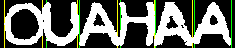

Running tally::: correct: 836 total: 856 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NR
[4, 44]
[45, 82]
model 3: NR 0.819
[0, 44]
[44, 84]
edit distance: 0


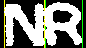

Running tally::: correct: 837 total: 857 accuracy: 0.977 avgEditDist 0.023
special window 44 52 ['E 1.00 ', 'G 0.82 ', 'A 0.02 ', 'L 0.02 ', 'T 0.02 ']
New example, correct answers:
GERV
[4, 44, 78, 112]
[47, 80, 114, 157]
model 3: GERV 0.599
[0, 48, 80, 112]
[44, 80, 112, 160]
edit distance: 0


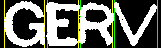

Running tally::: correct: 838 total: 858 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['V 0.22 ', 'M 0.19 ', 'J 0.07 ', 'T 0.04 ', 'Y 0.02 ']
New example, correct answers:
NRESAN
[4, 46, 80, 108, 142, 182]
[48, 81, 114, 143, 184, 221]
model 3: NRESAN 0.529
[8, 48, 80, 112, 144, 184]
[48, 80, 112, 144, 184, 224]
edit distance: 0


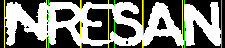

Running tally::: correct: 839 total: 859 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
GT
[4, 42]
[48, 79]
model 3: GT 0.752
[0, 44]
[44, 80]
edit distance: 0


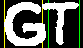

Running tally::: correct: 840 total: 860 accuracy: 0.977 avgEditDist 0.023
special window 40 48 ['R 1.00 ', 'C 0.68 ', 'L 0.08 ', 'T 0.04 ', 'D 0.03 ']
New example, correct answers:
CROOVU
[4, 40, 78, 114, 155, 196]
[44, 80, 115, 158, 197, 238]
model 3: CROOVU 0.503
[0, 44, 80, 112, 156, 196]
[40, 80, 116, 156, 196, 240]
edit distance: 0


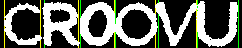

Running tally::: correct: 841 total: 861 accuracy: 0.977 avgEditDist 0.023
special window 44 52 ['K 0.98 ', 'V 0.65 ', 'J 0.47 ', 'A 0.05 ', 'H 0.05 ']
special window 80 88 ['K 0.90 ', 'C 0.68 ', 'D 0.29 ', 'L 0.06 ', 'V 0.04 ']
New example, correct answers:
VKD
[4, 44, 82]
[47, 83, 123]
model 3: VKD 0.704
[0, 48, 84]
[44, 80, 124]
edit distance: 0


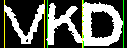

Running tally::: correct: 842 total: 862 accuracy: 0.977 avgEditDist 0.023
special window 116 128 ['E 0.98 ', 'H 0.97 ', 'A 0.01 ', 'L 0.01 ', 'I 0.01 ']
New example, correct answers:
AVHE
[4, 44, 84, 123]
[46, 86, 125, 163]
model 3: AVHE 0.645
[0, 44, 84, 124]
[44, 84, 120, 164]
edit distance: 0


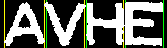

Running tally::: correct: 843 total: 863 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EVEN
[4, 37, 72, 102]
[38, 73, 103, 143]
model 3: EVEN 0.578
[0, 36, 72, 100]
[36, 72, 104, 144]
edit distance: 0


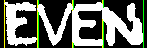

Running tally::: correct: 844 total: 864 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
DRCG
[4, 39, 70, 109]
[40, 73, 110, 148]
model 3: DRCG 0.671
[0, 40, 72, 108]
[40, 72, 108, 148]
edit distance: 0


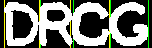

Running tally::: correct: 845 total: 865 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
DOVA
[4, 39, 76, 109]
[42, 80, 117, 151]
model 3: DOVA 0.573
[0, 36, 76, 112]
[40, 76, 112, 152]
edit distance: 0


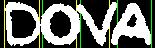

Running tally::: correct: 846 total: 866 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['E 0.98 ', 'V 0.12 ', 'T 0.09 ', 'L 0.05 ', 'A 0.04 ']
New example, correct answers:
EAAN
[4, 43, 84, 121]
[46, 85, 123, 165]
model 3: EAAN 0.658
[8, 44, 80, 120]
[44, 84, 120, 168]
edit distance: 0


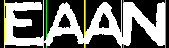

Running tally::: correct: 847 total: 867 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ER
[4, 39]
[40, 72]
model 3: ER 0.821
[0, 40]
[40, 72]
edit distance: 0


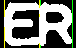

Running tally::: correct: 848 total: 868 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MRP
[4, 50, 83]
[53, 85, 121]
model 3: MRP 0.762
[0, 52, 84]
[52, 84, 124]
edit distance: 0


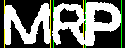

Running tally::: correct: 849 total: 869 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['R 0.79 ', 'F 0.34 ', 'V 0.15 ', 'T 0.07 ', 'J 0.06 ']
special window 36 52 ['I 1.00 ', 'E 0.94 ', 'R 0.85 ', 'B 0.01 ', 'G 0.01 ']
New example, correct answers:
RIECW
[4, 42, 49, 80, 116]
[44, 51, 86, 119, 169]
model 3: RIECW 0.511
[4, 36, 52, 80, 116]
[40, 52, 80, 116, 172]
edit distance: 0


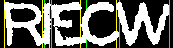

Running tally::: correct: 850 total: 870 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
TLET
[4, 46, 78, 113]
[48, 80, 115, 146]
model 3: TLET 0.634
[0, 44, 80, 112]
[44, 80, 112, 148]
edit distance: 0


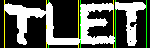

Running tally::: correct: 851 total: 871 accuracy: 0.977 avgEditDist 0.023
special window 44 56 ['I 0.99 ', 'M 0.79 ', 'C 0.61 ', 'D 0.23 ', 'L 0.11 ']
New example, correct answers:
MIDTS
[4, 47, 55, 87, 118]
[50, 56, 91, 124, 151]
model 3: MIDTS 0.542
[0, 44, 56, 88, 120]
[48, 56, 88, 120, 152]
edit distance: 0


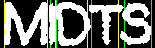

Running tally::: correct: 852 total: 872 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
CRGD
[4, 43, 86, 126]
[46, 88, 127, 163]
model 3: CRGD 0.624
[0, 44, 88, 124]
[44, 88, 124, 164]
edit distance: 0


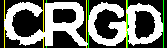

Running tally::: correct: 853 total: 873 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['C 0.98 ', 'I 0.96 ', 'V 0.18 ', 'T 0.06 ', 'H 0.04 ']
New example, correct answers:
ICDE
[4, 12, 50, 84]
[15, 51, 86, 122]
model 3: ICDE 0.687
[0, 16, 48, 84]
[16, 52, 84, 124]
edit distance: 0


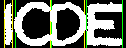

Running tally::: correct: 854 total: 874 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RTVNR
[4, 33, 70, 109, 148]
[38, 72, 111, 150, 188]
model 3: RTVNR 0.581
[0, 36, 72, 108, 148]
[36, 72, 108, 148, 188]
edit distance: 0


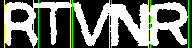

Running tally::: correct: 855 total: 875 accuracy: 0.977 avgEditDist 0.023
special window 112 120 ['L 0.98 ', 'J 0.91 ', 'U 0.06 ', 'V 0.04 ', 'Y 0.02 ']
New example, correct answers:
HRULA
[4, 39, 74, 111, 146]
[41, 76, 113, 148, 189]
model 3: HRULA 0.611
[0, 40, 76, 116, 148]
[40, 76, 112, 148, 192]
edit distance: 0


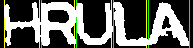

Running tally::: correct: 856 total: 876 accuracy: 0.977 avgEditDist 0.023
special window 40 48 ['S 0.94 ', 'N 0.85 ', 'V 0.07 ', 'J 0.05 ', 'I 0.02 ']
New example, correct answers:
NSAN
[4, 46, 79, 116]
[48, 80, 117, 156]
model 3: NSAN 0.643
[0, 48, 80, 116]
[40, 80, 116, 156]
edit distance: 0


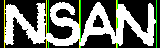

Running tally::: correct: 857 total: 877 accuracy: 0.977 avgEditDist 0.023
special window 76 88 ['N 0.96 ', 'I 0.52 ', 'V 0.08 ', 'T 0.08 ', 'H 0.04 ']
New example, correct answers:
UNI
[4, 40, 79]
[43, 80, 87]
model 3: UNI 0.801
[0, 40, 76]
[40, 80, 88]
edit distance: 0


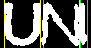

Running tally::: correct: 858 total: 878 accuracy: 0.977 avgEditDist 0.023
special window 108 116 ['C 0.98 ', 'N 0.82 ', 'V 0.04 ', 'J 0.01 ', 'I 0.01 ']
special window 192 200 ['R 0.94 ', 'A 0.87 ', 'F 0.04 ', 'N 0.04 ', 'V 0.03 ']
New example, correct answers:
LSNOAR
[4, 35, 70, 115, 149, 194]
[42, 71, 116, 154, 196, 234]
model 3: LSNOAR 0.503
[0, 36, 68, 116, 152, 196]
[40, 68, 108, 152, 192, 236]
edit distance: 0


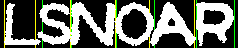

Running tally::: correct: 859 total: 879 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['E 1.00 ', 'V 0.05 ', 'A 0.04 ', 'T 0.03 ', 'L 0.01 ']
New example, correct answers:
AEESTP
[4, 45, 72, 108, 137, 183]
[46, 74, 109, 141, 184, 217]
model 3: AEESTP 0.450
[0, 44, 76, 108, 144, 184]
[44, 72, 108, 144, 184, 220]
edit distance: 0


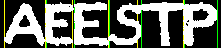

Running tally::: correct: 860 total: 880 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SLBA
[4, 40, 77, 105]
[42, 78, 107, 148]
model 3: SLBA 0.689
[0, 40, 76, 108]
[40, 76, 108, 148]
edit distance: 0


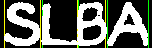

Running tally::: correct: 861 total: 881 accuracy: 0.977 avgEditDist 0.023
special window 40 48 ['E 1.00 ', 'N 0.83 ', 'V 0.02 ', 'W 0.01 ', 'A 0.01 ']
New example, correct answers:
NER
[4, 43, 81]
[45, 82, 118]
model 3: NER 0.714
[0, 48, 84]
[44, 84, 120]
edit distance: 0


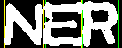

Running tally::: correct: 862 total: 882 accuracy: 0.977 avgEditDist 0.023
special window 88 96 ['E 0.99 ', 'W 0.66 ', 'A 0.02 ', 'U 0.02 ', 'V 0.02 ']
New example, correct answers:
LWE
[4, 33, 88]
[35, 90, 129]
model 3: LWE 0.700
[0, 36, 92]
[36, 88, 132]
edit distance: 0


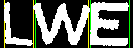

Running tally::: correct: 863 total: 883 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RE
[4, 42]
[44, 72]
model 3: RE 0.818
[0, 40]
[40, 72]
edit distance: 0


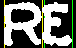

Running tally::: correct: 864 total: 884 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RSRH
[4, 41, 75, 111]
[44, 76, 113, 152]
model 3: RSRH 0.704
[0, 40, 76, 112]
[40, 76, 112, 152]
edit distance: 0


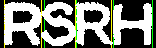

Running tally::: correct: 865 total: 885 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
MA
[4, 50]
[52, 95]
model 3: MA 0.820
[0, 52]
[52, 96]
edit distance: 0


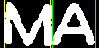

Running tally::: correct: 866 total: 886 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LOSLHN
[4, 38, 83, 116, 146, 186]
[40, 84, 117, 150, 187, 225]
model 3: LOSLHN 0.505
[0, 40, 84, 116, 148, 184]
[40, 84, 116, 148, 188, 228]
edit distance: 0


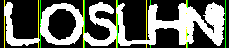

Running tally::: correct: 867 total: 887 accuracy: 0.977 avgEditDist 0.023
special window 40 48 ['N 0.89 ', 'U 0.78 ', 'L 0.10 ', 'V 0.04 ', 'J 0.01 ']
New example, correct answers:
NUAB
[4, 46, 77, 117]
[48, 83, 118, 154]
model 3: NUAB 0.585
[0, 48, 76, 116]
[44, 80, 116, 156]
edit distance: 0


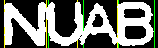

Running tally::: correct: 868 total: 888 accuracy: 0.977 avgEditDist 0.023
special window 112 120 ['N 0.91 ', 'A 0.91 ', 'F 0.01 ', 'H 0.01 ', 'J 0.01 ']
New example, correct answers:
TRNAS
[4, 42, 79, 116, 155]
[44, 81, 119, 157, 191]
model 3: TRNAS 0.606
[0, 44, 80, 120, 156]
[44, 80, 116, 160, 192]
edit distance: 0


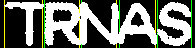

Running tally::: correct: 869 total: 889 accuracy: 0.978 avgEditDist 0.022
New example, correct answers:
ANEECN
[4, 38, 76, 146, 177, 218]
[44, 77, 148, 182, 220, 259]
model 3: ANGEECN 0.129
[0, 40, 72, 104, 144, 180, 220]
[40, 76, 108, 144, 180, 220, 260]
edit distance: 1
-----------------------------------------------------------------------------


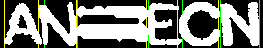

Running tally::: correct: 869 total: 890 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NKOV
[4, 40, 72, 112]
[42, 81, 118, 150]
model 3: NKOV 0.520
[0, 44, 76, 112]
[44, 80, 112, 152]
edit distance: 0


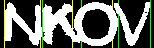

Running tally::: correct: 870 total: 891 accuracy: 0.976 avgEditDist 0.024
special window 36 44 ['N 0.99 ', 'V 0.03 ', 'M 0.02 ', 'J 0.01 ', 'H 0.01 ']
special window 160 176 ['C 0.92 ', 'M 0.82 ', 'O 0.01 ', 'W 0.01 ', 'A 0.01 ']
New example, correct answers:
NNRMO
[4, 39, 83, 123, 168]
[43, 85, 125, 169, 212]
model 3: NNRMO 0.558
[0, 44, 88, 124, 176]
[40, 88, 124, 164, 212]
edit distance: 0


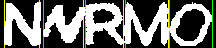

Running tally::: correct: 871 total: 892 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RAPLAL
[4, 44, 85, 123, 161, 199]
[47, 86, 125, 163, 201, 233]
model 3: RAPLAL 0.537
[0, 44, 84, 124, 160, 200]
[44, 84, 124, 160, 200, 236]
edit distance: 0


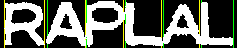

Running tally::: correct: 872 total: 893 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['V 0.96 ', 'N 0.83 ', 'W 0.01 ', 'J 0.01 ', 'L 0.01 ']
New example, correct answers:
NVVK
[4, 44, 78, 110]
[46, 79, 112, 148]
model 3: NVVK 0.521
[0, 48, 76, 112]
[44, 80, 112, 148]
edit distance: 0


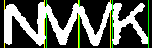

Running tally::: correct: 873 total: 894 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['I 0.99 ', 'R 0.97 ', 'V 0.17 ', 'T 0.07 ', 'F 0.05 ']
New example, correct answers:
IREVE
[4, 12, 47, 79, 118]
[14, 48, 81, 120, 153]
model 3: IREVE 0.643
[0, 16, 48, 80, 120]
[16, 48, 80, 120, 156]
edit distance: 0


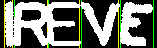

Running tally::: correct: 874 total: 895 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
ETGETL
[4, 35, 72, 105, 136, 181]
[38, 73, 108, 137, 182, 215]
model 3: ETGETL 0.482
[0, 36, 72, 108, 136, 180]
[36, 72, 108, 136, 180, 216]
edit distance: 0


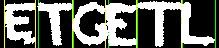

Running tally::: correct: 875 total: 896 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['E 0.99 ', 'N 0.99 ', 'I 0.03 ', 'V 0.03 ', 'F 0.01 ']
New example, correct answers:
ENE
[4, 39, 80]
[42, 81, 115]
model 3: ENE 0.698
[0, 40, 80]
[40, 76, 116]
edit distance: 0


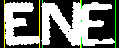

Running tally::: correct: 876 total: 897 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
TEP
[4, 37, 70]
[39, 72, 106]
model 3: TEP 0.721
[0, 40, 72]
[40, 72, 108]
edit distance: 0


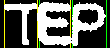

Running tally::: correct: 877 total: 898 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['I 1.00 ', 'F 0.96 ', 'V 0.14 ', 'J 0.06 ', 'H 0.05 ']
New example, correct answers:
IRSVAR
[4, 13, 47, 78, 113, 147]
[15, 49, 81, 122, 149, 188]
model 3: IRSVAR 0.599
[0, 12, 48, 80, 116, 148]
[12, 48, 80, 116, 148, 188]
edit distance: 0


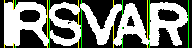

Running tally::: correct: 878 total: 899 accuracy: 0.977 avgEditDist 0.023
special window 136 144 ['L 0.99 ', 'W 0.64 ', 'T 0.04 ', 'V 0.02 ', 'U 0.01 ']
New example, correct answers:
OAWLS
[4, 42, 85, 137, 174]
[45, 87, 139, 176, 216]
model 3: OAWLS 0.582
[0, 44, 84, 140, 176]
[44, 84, 136, 176, 216]
edit distance: 0


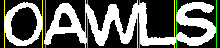

Running tally::: correct: 879 total: 900 accuracy: 0.977 avgEditDist 0.023
special window 104 112 ['N 0.92 ', 'F 0.82 ', 'R 0.45 ', 'I 0.01 ', 'A 0.01 ']
New example, correct answers:
VPNR
[4, 36, 72, 110]
[37, 73, 112, 146]
model 3: VPNR 0.647
[0, 36, 72, 112]
[40, 72, 108, 148]
edit distance: 0


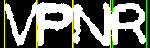

Running tally::: correct: 880 total: 901 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OPON
[4, 39, 79, 124]
[42, 80, 126, 168]
model 3: OPON 0.561
[0, 40, 80, 124]
[40, 80, 124, 168]
edit distance: 0


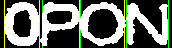

Running tally::: correct: 881 total: 902 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
WOVOEO
[4, 53, 93, 130, 176, 207]
[55, 98, 132, 178, 209, 249]
model 3: WOVOEO 0.493
[0, 56, 96, 132, 176, 208]
[56, 96, 132, 176, 208, 252]
edit distance: 0


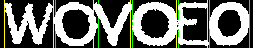

Running tally::: correct: 882 total: 903 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LV
[4, 38]
[45, 84]
model 3: LV 0.785
[0, 40]
[40, 84]
edit distance: 0


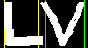

Running tally::: correct: 883 total: 904 accuracy: 0.977 avgEditDist 0.023
special window 84 96 ['I 1.00 ', 'D 0.55 ', 'V 0.13 ', 'J 0.10 ', 'T 0.10 ']
New example, correct answers:
OOI
[4, 42, 88]
[43, 90, 96]
model 3: OUI 0.697
[0, 44, 84]
[44, 84, 96]
edit distance: 1
-----------------------------------------------------------------------------


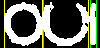

Running tally::: correct: 883 total: 905 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
EOSA
[4, 30, 74, 107]
[37, 76, 109, 156]
model 3: EOSA 0.643
[0, 36, 76, 108]
[36, 76, 108, 156]
edit distance: 0


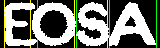

Running tally::: correct: 884 total: 906 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
EV
[4, 36]
[38, 77]
model 3: EV 0.814
[0, 36]
[36, 80]
edit distance: 0


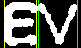

Running tally::: correct: 885 total: 907 accuracy: 0.976 avgEditDist 0.024
special window 192 208 ['I 1.00 ', 'T 0.98 ', 'V 0.17 ', 'L 0.10 ', 'W 0.03 ']
New example, correct answers:
HKLSTI
[4, 39, 77, 115, 153, 196]
[42, 79, 117, 155, 198, 206]
model 3: HKLSTI 0.553
[0, 40, 80, 116, 152, 192]
[40, 80, 116, 152, 196, 208]
edit distance: 0


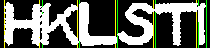

Running tally::: correct: 886 total: 908 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VDEBF
[4, 38, 73, 104, 140]
[40, 74, 105, 142, 171]
model 3: VDEBF 0.556
[0, 40, 72, 104, 140]
[40, 72, 104, 140, 172]
edit distance: 0


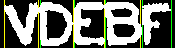

Running tally::: correct: 887 total: 909 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TB
[4, 42]
[44, 86]
model 3: TB 0.784
[0, 44]
[44, 88]
edit distance: 0


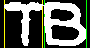

Running tally::: correct: 888 total: 910 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
VSS
[4, 44, 81]
[50, 83, 115]
model 3: VSS 0.693
[0, 44, 76]
[44, 80, 116]
edit distance: 0


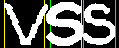

Running tally::: correct: 889 total: 911 accuracy: 0.976 avgEditDist 0.024
special window 148 156 ['I 0.99 ', 'A 0.87 ', 'W 0.63 ', 'V 0.09 ', 'T 0.02 ']
New example, correct answers:
TRDAIV
[4, 42, 79, 108, 146, 153]
[44, 81, 113, 147, 155, 190]
model 3: TRDAIV 0.531
[0, 44, 80, 112, 148, 156]
[44, 80, 112, 148, 156, 192]
edit distance: 0


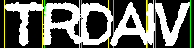

Running tally::: correct: 890 total: 912 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AMT
[4, 44, 87]
[46, 89, 129]
model 3: AMT 0.689
[0, 44, 88]
[44, 88, 132]
edit distance: 0


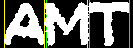

Running tally::: correct: 891 total: 913 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
ODT
[4, 42, 75]
[44, 81, 113]
model 3: ODT 0.652
[0, 44, 76]
[44, 80, 116]
edit distance: 0


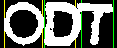

Running tally::: correct: 892 total: 914 accuracy: 0.976 avgEditDist 0.024
special window 124 132 ['V 0.82 ', 'R 0.62 ', 'F 0.27 ', 'P 0.02 ', 'N 0.01 ']
New example, correct answers:
FTVRGD
[4, 38, 82, 124, 167, 205]
[39, 83, 126, 168, 207, 238]
model 3: FTVRGD 0.535
[0, 36, 84, 128, 168, 204]
[36, 84, 124, 168, 204, 240]
edit distance: 0


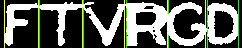

Running tally::: correct: 893 total: 915 accuracy: 0.976 avgEditDist 0.024
special window 112 120 ['C 0.97 ', 'H 0.87 ', 'V 0.03 ', 'O 0.02 ', 'M 0.01 ']
New example, correct answers:
ACHOE
[4, 40, 79, 116, 155]
[43, 80, 118, 156, 189]
model 3: ACHOE 0.561
[0, 40, 80, 120, 156]
[40, 80, 116, 156, 192]
edit distance: 0


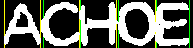

Running tally::: correct: 894 total: 916 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HASV
[4, 38, 85, 118]
[40, 87, 123, 164]
model 3: HASV 0.631
[0, 40, 88, 124]
[40, 88, 124, 164]
edit distance: 0


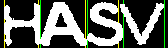

Running tally::: correct: 895 total: 917 accuracy: 0.976 avgEditDist 0.024
special window 84 92 ['D 0.99 ', 'V 0.47 ', 'J 0.03 ', 'Y 0.02 ', 'L 0.02 ']
New example, correct answers:
KVDAE
[4, 40, 82, 122, 162]
[42, 84, 124, 164, 202]
model 3: KVDAE 0.553
[0, 40, 88, 124, 164]
[40, 84, 124, 164, 204]
edit distance: 0


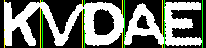

Running tally::: correct: 896 total: 918 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
ACETON
[4, 43, 77, 109, 150, 193]
[47, 79, 111, 156, 195, 231]
model 3: ACETON 0.499
[0, 44, 80, 112, 152, 192]
[44, 80, 112, 152, 192, 232]
edit distance: 0


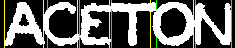

Running tally::: correct: 897 total: 919 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
OET
[4, 43, 74]
[45, 79, 120]
model 3: OET 0.672
[0, 44, 76]
[44, 76, 120]
edit distance: 0


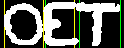

Running tally::: correct: 898 total: 920 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['T 0.98 ', 'I 0.96 ', 'V 0.14 ', 'L 0.05 ', 'J 0.04 ']
special window 92 100 ['L 0.98 ', 'H 0.97 ', 'V 0.02 ', 'T 0.02 ', 'Y 0.01 ']
New example, correct answers:
ITHLRR
[4, 13, 60, 97, 132, 173]
[17, 61, 99, 133, 174, 207]
model 3: ITHLRR 0.615
[0, 16, 60, 100, 132, 172]
[16, 60, 96, 132, 172, 208]
edit distance: 0


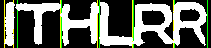

Running tally::: correct: 899 total: 921 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RTSVLA
[4, 34, 66, 98, 141, 179]
[38, 68, 100, 142, 180, 223]
model 3: RTSVLA 0.439
[0, 32, 68, 100, 140, 180]
[36, 68, 100, 140, 180, 224]
edit distance: 0


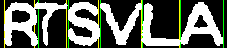

Running tally::: correct: 900 total: 922 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
OTLAR
[4, 45, 79, 118, 162]
[48, 81, 120, 163, 199]
model 3: OTLAR 0.584
[0, 44, 80, 120, 160]
[44, 80, 120, 160, 200]
edit distance: 0


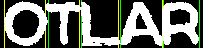

Running tally::: correct: 901 total: 923 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RSLETR
[4, 45, 79, 121, 149, 184]
[48, 80, 123, 151, 186, 222]
model 3: RSLETR 0.490
[0, 48, 80, 120, 152, 188]
[48, 80, 120, 152, 188, 224]
edit distance: 0


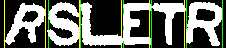

Running tally::: correct: 902 total: 924 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SAE
[4, 42, 81]
[45, 82, 112]
model 3: SAE 0.697
[0, 44, 80]
[44, 80, 112]
edit distance: 0


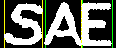

Running tally::: correct: 903 total: 925 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
LTRSFL
[4, 31, 66, 105, 137, 172]
[41, 68, 106, 138, 173, 209]
model 3: LTRSFL 0.462
[0, 36, 68, 104, 140, 172]
[36, 68, 104, 140, 172, 212]
edit distance: 0


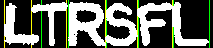

Running tally::: correct: 904 total: 926 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['I 0.99 ', 'N 0.78 ', 'V 0.16 ', 'M 0.10 ', 'T 0.04 ']
New example, correct answers:
INEC
[4, 14, 53, 89]
[16, 54, 92, 128]
model 3: INEC 0.651
[0, 16, 52, 88]
[16, 52, 88, 128]
edit distance: 0


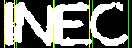

Running tally::: correct: 905 total: 927 accuracy: 0.976 avgEditDist 0.024
special window 76 92 ['I 1.00 ', 'R 0.80 ', 'G 0.67 ', 'C 0.04 ', 'V 0.03 ']
New example, correct answers:
NRIGDH
[4, 43, 74, 85, 129, 166]
[45, 77, 87, 131, 168, 207]
model 3: NRIGDH 0.624
[0, 44, 76, 92, 132, 168]
[44, 76, 92, 132, 168, 208]
edit distance: 0


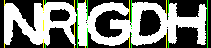

Running tally::: correct: 906 total: 928 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RREVSP
[4, 37, 74, 105, 141, 175]
[40, 76, 107, 145, 176, 208]
model 3: RREVSP 0.504
[0, 36, 76, 108, 144, 176]
[40, 76, 108, 144, 176, 208]
edit distance: 0


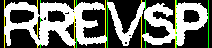

Running tally::: correct: 907 total: 929 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
WMERA
[4, 57, 102, 143, 178]
[58, 104, 144, 180, 222]
model 3: WMERA 0.624
[0, 56, 104, 144, 180]
[56, 104, 144, 180, 224]
edit distance: 0


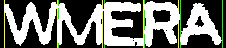

Running tally::: correct: 908 total: 930 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TTNEOT
[4, 45, 84, 125, 157, 192]
[46, 86, 126, 164, 198, 232]
model 3: TTNEOT 0.485
[0, 44, 84, 124, 160, 196]
[48, 84, 124, 160, 196, 232]
edit distance: 0


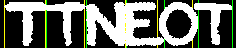

Running tally::: correct: 909 total: 931 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
MRTU
[4, 43, 81, 115]
[48, 83, 117, 154]
model 3: MRTU 0.664
[0, 44, 80, 116]
[44, 80, 116, 156]
edit distance: 0


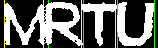

Running tally::: correct: 910 total: 932 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NBEE
[4, 43, 79, 112]
[44, 80, 114, 148]
model 3: NBEE 0.644
[0, 44, 80, 112]
[44, 80, 112, 148]
edit distance: 0


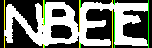

Running tally::: correct: 911 total: 933 accuracy: 0.976 avgEditDist 0.024
special window 84 92 ['I 1.00 ', 'F 0.96 ', 'R 0.75 ', 'A 0.02 ', 'P 0.01 ']
New example, correct answers:
ORIR
[4, 44, 82, 93]
[46, 87, 94, 135]
model 3: ORIR 0.621
[0, 44, 84, 100]
[44, 84, 92, 136]
edit distance: 0


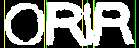

Running tally::: correct: 912 total: 934 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TW
[4, 45]
[48, 105]
model 3: TW 0.816
[0, 44]
[48, 108]
edit distance: 0


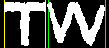

Running tally::: correct: 913 total: 935 accuracy: 0.976 avgEditDist 0.024
special window 92 100 ['R 0.98 ', 'V 0.81 ', 'N 0.01 ', 'F 0.01 ', 'W 0.01 ']
special window 128 140 ['I 1.00 ', 'A 0.87 ', 'R 0.64 ', 'V 0.02 ', 'P 0.02 ']
New example, correct answers:
ANRIA
[4, 42, 95, 130, 137]
[45, 96, 132, 139, 182]
model 3: ANRIA 0.706
[0, 44, 96, 128, 140]
[44, 92, 132, 140, 184]
edit distance: 0


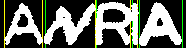

Running tally::: correct: 914 total: 936 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
DL
[4, 40]
[42, 76]
model 3: DL 0.803
[0, 40]
[40, 76]
edit distance: 0


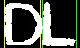

Running tally::: correct: 915 total: 937 accuracy: 0.977 avgEditDist 0.023
special window 80 92 ['C 0.96 ', 'M 0.81 ', 'W 0.03 ', 'V 0.02 ', 'T 0.01 ']
New example, correct answers:
OMOM
[4, 41, 88, 124]
[43, 90, 126, 173]
model 3: OMOM 0.653
[0, 40, 92, 128]
[40, 84, 128, 176]
edit distance: 0


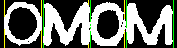

Running tally::: correct: 916 total: 938 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
TTLE
[4, 46, 88, 124]
[49, 90, 126, 162]
model 3: TTLE 0.705
[0, 40, 88, 124]
[44, 88, 124, 164]
edit distance: 0


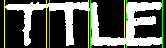

Running tally::: correct: 917 total: 939 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SVOON
[4, 37, 77, 115, 160]
[43, 79, 117, 161, 201]
model 3: SVOON 0.571
[0, 40, 76, 120, 160]
[40, 76, 120, 160, 204]
edit distance: 0


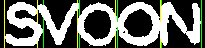

Running tally::: correct: 918 total: 940 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OFRT
[4, 42, 69, 102]
[44, 72, 105, 142]
model 3: OFRT 0.574
[0, 40, 72, 104]
[40, 72, 104, 144]
edit distance: 0


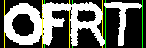

Running tally::: correct: 919 total: 941 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EO
[4, 38]
[39, 82]
model 3: EO 0.744
[0, 40]
[40, 84]
edit distance: 0


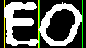

Running tally::: correct: 920 total: 942 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EAHEH
[4, 34, 68, 106, 132]
[37, 70, 109, 134, 184]
model 3: EAHEH 0.449
[0, 36, 68, 108, 140]
[36, 68, 108, 140, 184]
edit distance: 0


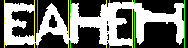

Running tally::: correct: 921 total: 943 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
RSAS
[4, 45, 81, 115]
[47, 83, 117, 154]
model 3: RSAS 0.665
[0, 44, 80, 116]
[44, 80, 116, 156]
edit distance: 0


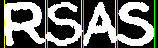

Running tally::: correct: 922 total: 944 accuracy: 0.977 avgEditDist 0.023
special window 160 168 ['K 0.99 ', 'A 0.88 ', 'N 0.02 ', 'F 0.02 ', 'T 0.01 ']
New example, correct answers:
CARAK
[4, 41, 82, 119, 161]
[43, 84, 121, 163, 200]
model 3: CARAK 0.555
[0, 40, 84, 120, 164]
[40, 84, 120, 160, 200]
edit distance: 0


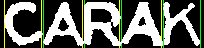

Running tally::: correct: 923 total: 945 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
EBEVT
[4, 42, 74, 107, 144]
[44, 75, 110, 146, 188]
model 3: EBEVT 0.537
[0, 40, 76, 108, 144]
[40, 76, 108, 144, 188]
edit distance: 0


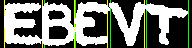

Running tally::: correct: 924 total: 946 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
PAE
[4, 34, 72]
[41, 73, 104]
model 3: PAE 0.634
[0, 40, 72]
[40, 72, 104]
edit distance: 0


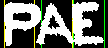

Running tally::: correct: 925 total: 947 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['H 0.99 ', 'V 0.17 ', 'T 0.07 ', 'L 0.04 ', 'J 0.04 ']
New example, correct answers:
HELEK
[4, 36, 68, 102, 134]
[39, 69, 104, 136, 174]
model 3: HELEK 0.543
[8, 36, 68, 104, 136]
[40, 68, 104, 136, 176]
edit distance: 0


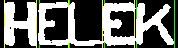

Running tally::: correct: 926 total: 948 accuracy: 0.977 avgEditDist 0.023
special window 132 148 ['I 1.00 ', 'E 0.98 ', 'H 0.26 ', 'K 0.09 ', 'V 0.03 ']
New example, correct answers:
ELLEIK
[4, 32, 67, 100, 136, 147]
[36, 68, 103, 138, 148, 181]
model 3: ELLEIK 0.557
[0, 36, 68, 100, 132, 148]
[36, 68, 100, 132, 148, 184]
edit distance: 0


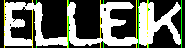

Running tally::: correct: 927 total: 949 accuracy: 0.977 avgEditDist 0.023
special window 0 12 ['I 1.00 ', 'L 0.34 ', 'V 0.23 ', 'U 0.18 ', 'T 0.07 ']
New example, correct answers:
IUAED
[4, 10, 46, 87, 116]
[12, 48, 89, 117, 157]
model 3: IUAED 0.635
[0, 12, 48, 88, 116]
[12, 48, 88, 116, 160]
edit distance: 0


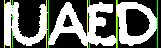

Running tally::: correct: 928 total: 950 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SVAU
[4, 42, 78, 118]
[44, 86, 119, 159]
model 3: SVAU 0.574
[0, 40, 80, 116]
[40, 80, 116, 160]
edit distance: 0


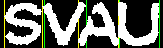

Running tally::: correct: 929 total: 951 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
VAAS
[4, 40, 88, 128]
[46, 89, 129, 162]
model 3: VAAS 0.660
[0, 44, 84, 128]
[44, 84, 128, 164]
edit distance: 0


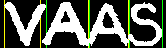

Running tally::: correct: 930 total: 952 accuracy: 0.977 avgEditDist 0.023
special window 72 80 ['R 0.89 ', 'B 0.86 ', 'F 0.24 ', 'P 0.04 ', 'N 0.03 ']
New example, correct answers:
FBRET
[4, 36, 73, 117, 151]
[39, 75, 118, 152, 190]
model 3: FBRET 0.521
[0, 36, 76, 116, 152]
[36, 72, 116, 152, 192]
edit distance: 0


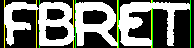

Running tally::: correct: 931 total: 953 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['R 0.79 ', 'F 0.34 ', 'V 0.15 ', 'T 0.07 ', 'J 0.06 ']
New example, correct answers:
RMCO
[4, 41, 99, 136]
[44, 101, 137, 178]
model 3: RMCO 0.594
[4, 40, 100, 136]
[40, 100, 136, 180]
edit distance: 0


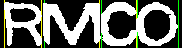

Running tally::: correct: 932 total: 954 accuracy: 0.977 avgEditDist 0.023
special window 0 8 ['D 0.78 ', 'O 0.38 ', 'V 0.15 ', 'T 0.13 ', 'J 0.11 ']
New example, correct answers:
DE
[4, 31]
[33, 67]
model 3: OE 0.705
[4, 32]
[36, 68]
edit distance: 1
-----------------------------------------------------------------------------


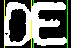

Running tally::: correct: 932 total: 955 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['E 0.99 ', 'V 0.12 ', 'T 0.09 ', 'L 0.05 ', 'A 0.04 ']
special window 32 48 ['E 1.00 ', 'I 1.00 ', 'V 0.02 ', 'G 0.01 ', 'L 0.01 ']
special window 76 92 ['I 0.99 ', 'E 0.98 ', 'V 0.18 ', 'T 0.08 ', 'L 0.05 ']
New example, correct answers:
EIEI
[4, 36, 46, 79]
[39, 47, 81, 90]
model 3: EIEI 0.821
[4, 32, 48, 76]
[36, 48, 80, 92]
edit distance: 0


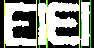

Running tally::: correct: 933 total: 956 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['E 0.99 ', 'I 0.99 ', 'V 0.17 ', 'T 0.10 ', 'L 0.05 ']
New example, correct answers:
IEL
[4, 10, 40]
[12, 41, 70]
model 3: IEL 0.735
[0, 12, 40]
[16, 44, 72]
edit distance: 0


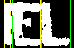

Running tally::: correct: 934 total: 957 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NRETEN
[4, 43, 73, 108, 150, 182]
[46, 75, 110, 151, 183, 222]
model 3: NRETEN 0.533
[0, 44, 76, 108, 148, 184]
[44, 76, 108, 148, 184, 224]
edit distance: 0


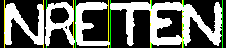

Running tally::: correct: 935 total: 958 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['F 0.87 ', 'V 0.16 ', 'J 0.07 ', 'T 0.06 ', 'L 0.03 ']
New example, correct answers:
RSEUL
[4, 40, 72, 100, 135]
[42, 73, 102, 136, 169]
model 3: RSEUL 0.553
[4, 40, 72, 104, 132]
[40, 72, 104, 136, 172]
edit distance: 0


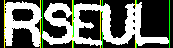

Running tally::: correct: 936 total: 959 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
FNL
[4, 33, 72]
[34, 74, 110]
model 3: FNL 0.695
[0, 32, 72]
[32, 72, 112]
edit distance: 0


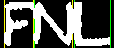

Running tally::: correct: 937 total: 960 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
KWMCM
[4, 40, 101, 150, 182]
[44, 103, 151, 184, 231]
model 3: KWMCM 0.565
[0, 44, 104, 152, 184]
[44, 104, 152, 184, 232]
edit distance: 0


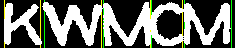

Running tally::: correct: 938 total: 961 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
HV
[4, 43]
[46, 88]
model 3: HV 0.813
[0, 44]
[44, 88]
edit distance: 0


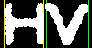

Running tally::: correct: 939 total: 962 accuracy: 0.976 avgEditDist 0.024
special window 144 152 ['A 0.94 ', 'N 0.92 ', 'V 0.01 ', 'T 0.01 ', 'H 0.00 ']
New example, correct answers:
UAENA
[4, 35, 73, 107, 147]
[43, 75, 109, 149, 186]
model 3: UAENA 0.504
[0, 40, 72, 108, 152]
[40, 72, 108, 148, 188]
edit distance: 0


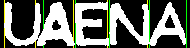

Running tally::: correct: 940 total: 963 accuracy: 0.976 avgEditDist 0.024
special window 0 16 ['I 1.00 ', 'M 0.51 ', 'V 0.23 ', 'T 0.07 ', 'H 0.02 ']
special window 56 68 ['M 0.62 ', 'V 0.44 ', 'W 0.33 ', 'I 0.10 ', 'N 0.03 ']
New example, correct answers:
IMV
[4, 13, 62]
[16, 64, 101]
model 3: IMV 0.609
[0, 16, 64]
[16, 60, 104]
edit distance: 0


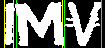

Running tally::: correct: 941 total: 964 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
UNOAEA
[4, 40, 85, 117, 154, 191]
[41, 86, 125, 159, 192, 230]
model 3: UNOAEA 0.414
[0, 44, 84, 120, 156, 188]
[44, 84, 124, 156, 188, 232]
edit distance: 0


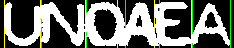

Running tally::: correct: 942 total: 965 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
OV
[4, 41]
[44, 87]
model 3: OV 0.783
[0, 40]
[40, 88]
edit distance: 0


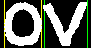

Running tally::: correct: 943 total: 966 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
RWT
[4, 39, 95]
[40, 97, 143]
model 3: RWT 0.719
[0, 40, 96]
[40, 96, 144]
edit distance: 0


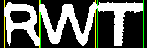

Running tally::: correct: 944 total: 967 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
KDE
[4, 42, 78]
[44, 79, 114]
model 3: KDE 0.717
[0, 44, 80]
[44, 80, 116]
edit distance: 0


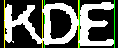

Running tally::: correct: 945 total: 968 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['L 0.99 ', 'V 0.13 ', 'T 0.13 ', 'Y 0.03 ', 'A 0.02 ']
New example, correct answers:
LPC
[4, 36, 75]
[39, 76, 114]
model 3: LPC 0.723
[4, 36, 76]
[36, 76, 116]
edit distance: 0


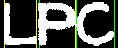

Running tally::: correct: 946 total: 969 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
WNWG
[4, 57, 101, 148]
[59, 102, 152, 194]
model 3: WNWG 0.691
[0, 56, 100, 152]
[56, 100, 152, 196]
edit distance: 0


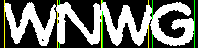

Running tally::: correct: 947 total: 970 accuracy: 0.976 avgEditDist 0.024
special window 40 48 ['L 0.99 ', 'E 0.99 ', 'T 0.03 ', 'V 0.02 ', 'A 0.02 ']
New example, correct answers:
ELOOLB
[4, 41, 72, 109, 152, 186]
[44, 79, 110, 154, 187, 222]
model 3: ELOOLB 0.485
[0, 44, 76, 112, 152, 188]
[40, 76, 112, 152, 188, 224]
edit distance: 0


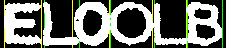

Running tally::: correct: 948 total: 971 accuracy: 0.976 avgEditDist 0.024
special window 44 52 ['D 0.88 ', 'M 0.81 ', 'L 0.07 ', 'T 0.03 ', 'C 0.02 ']
New example, correct answers:
MD
[4, 49]
[50, 85]
model 3: MD 0.781
[0, 48]
[44, 88]
edit distance: 0


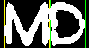

Running tally::: correct: 949 total: 972 accuracy: 0.976 avgEditDist 0.024
special window 0 8 ['E 0.99 ', 'V 0.17 ', 'T 0.12 ', 'L 0.05 ', 'A 0.04 ']
special window 28 44 ['I 1.00 ', 'E 1.00 ', 'S 0.79 ', 'V 0.03 ', 'L 0.01 ']
New example, correct answers:
EIST
[4, 32, 42, 76]
[35, 43, 78, 119]
model 3: EIST 0.695
[4, 28, 44, 80]
[32, 44, 80, 120]
edit distance: 0


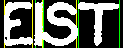

Running tally::: correct: 950 total: 973 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
AAUO
[4, 40, 82, 119]
[42, 85, 121, 168]
model 3: AAUO 0.636
[0, 44, 84, 120]
[48, 84, 120, 168]
edit distance: 0


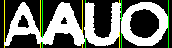

Running tally::: correct: 951 total: 974 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
TEDBC
[4, 43, 90, 122, 156]
[46, 91, 124, 158, 198]
model 3: TEDBC 0.435
[0, 48, 88, 124, 156]
[48, 88, 124, 156, 200]
edit distance: 0


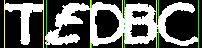

Running tally::: correct: 952 total: 975 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
NCWV
[4, 43, 80, 130]
[45, 82, 131, 165]
model 3: NCWV 0.655
[0, 44, 80, 128]
[44, 80, 128, 168]
edit distance: 0


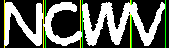

Running tally::: correct: 953 total: 976 accuracy: 0.976 avgEditDist 0.024
special window 36 48 ['N 0.87 ', 'V 0.40 ', 'W 0.29 ', 'T 0.01 ', 'J 0.00 ']
New example, correct answers:
NVA
[4, 43, 81]
[45, 83, 131]
model 3: NVA 0.687
[0, 48, 84]
[40, 84, 132]
edit distance: 0


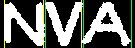

Running tally::: correct: 954 total: 977 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
GDR
[4, 44, 81]
[46, 83, 116]
model 3: GDR 0.730
[0, 44, 80]
[44, 80, 116]
edit distance: 0


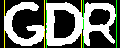

Running tally::: correct: 955 total: 978 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
OSL
[4, 45, 84]
[48, 85, 123]
model 3: OSL 0.732
[0, 48, 84]
[48, 84, 124]
edit distance: 0


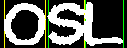

Running tally::: correct: 956 total: 979 accuracy: 0.977 avgEditDist 0.023
special window 36 44 ['N 0.98 ', 'C 0.91 ', 'T 0.03 ', 'O 0.03 ', 'J 0.01 ']
New example, correct answers:
NOCEO
[4, 42, 79, 115, 143]
[45, 80, 116, 146, 188]
model 3: NOCEO 0.486
[0, 44, 80, 112, 144]
[40, 80, 116, 144, 188]
edit distance: 0


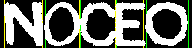

Running tally::: correct: 957 total: 980 accuracy: 0.977 avgEditDist 0.023
special window 152 168 ['I 0.99 ', 'M 0.84 ', 'A 0.64 ', 'F 0.11 ', 'H 0.04 ']
New example, correct answers:
ARHMIA
[4, 46, 81, 116, 156, 163]
[48, 82, 117, 158, 165, 204]
model 3: ARHMIA 0.593
[0, 44, 80, 116, 152, 164]
[44, 80, 116, 156, 168, 204]
edit distance: 0


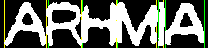

Running tally::: correct: 958 total: 981 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LLELA
[4, 33, 75, 106, 137]
[36, 77, 108, 139, 177]
model 3: LLELA 0.624
[0, 36, 76, 108, 140]
[36, 76, 108, 140, 180]
edit distance: 0


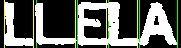

Running tally::: correct: 959 total: 982 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OSDSC
[4, 46, 82, 114, 149]
[49, 84, 118, 150, 187]
model 3: OSDSC 0.595
[0, 48, 84, 116, 148]
[48, 84, 116, 148, 188]
edit distance: 0


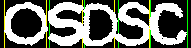

Running tally::: correct: 960 total: 983 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
GVALN
[4, 47, 82, 130, 156]
[50, 90, 132, 161, 204]
model 3: GVALN 0.471
[0, 48, 88, 128, 160]
[48, 88, 128, 160, 204]
edit distance: 0


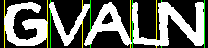

Running tally::: correct: 961 total: 984 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NBT
[4, 41, 78]
[43, 79, 115]
model 3: NBT 0.717
[0, 44, 76]
[44, 76, 116]
edit distance: 0


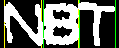

Running tally::: correct: 962 total: 985 accuracy: 0.977 avgEditDist 0.023
special window 156 172 ['I 0.99 ', 'A 0.98 ', 'T 0.08 ', 'V 0.06 ', 'Y 0.02 ']
New example, correct answers:
ODEAI
[4, 43, 83, 116, 158]
[45, 84, 119, 160, 170]
model 3: ODEAI 0.640
[0, 44, 84, 116, 156]
[44, 84, 116, 156, 172]
edit distance: 0


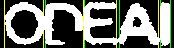

Running tally::: correct: 963 total: 986 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
NDSTHD
[4, 42, 74, 110, 154, 192]
[44, 76, 118, 156, 193, 231]
model 3: NDSTHD 0.482
[0, 44, 76, 116, 156, 192]
[44, 76, 116, 156, 192, 232]
edit distance: 0


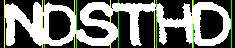

Running tally::: correct: 964 total: 987 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
DECK
[4, 46, 75, 112]
[49, 77, 114, 148]
model 3: DECK 0.627
[0, 44, 76, 112]
[44, 76, 112, 148]
edit distance: 0


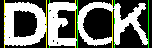

Running tally::: correct: 965 total: 988 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
APS
[4, 43, 76]
[45, 77, 114]
model 3: APS 0.709
[0, 44, 76]
[44, 76, 116]
edit distance: 0


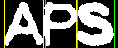

Running tally::: correct: 966 total: 989 accuracy: 0.977 avgEditDist 0.023
special window 164 172 ['I 0.98 ', 'T 0.87 ', 'L 0.85 ', 'A 0.01 ', 'H 0.01 ']
New example, correct answers:
AVALIT
[4, 39, 74, 127, 162, 170]
[48, 80, 129, 164, 172, 216]
model 3: AVALIT 0.519
[0, 40, 80, 128, 164, 172]
[40, 80, 128, 164, 172, 216]
edit distance: 0


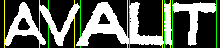

Running tally::: correct: 967 total: 990 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
LNNT
[4, 38, 74, 117]
[39, 76, 118, 156]
model 3: LNNT 0.610
[0, 36, 76, 116]
[36, 76, 116, 156]
edit distance: 0


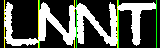

Running tally::: correct: 968 total: 991 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
OAO
[4, 37, 72]
[44, 77, 117]
model 3: OAO 0.661
[0, 40, 76]
[40, 76, 120]
edit distance: 0


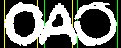

Running tally::: correct: 969 total: 992 accuracy: 0.977 avgEditDist 0.023
special window 0 16 ['I 1.00 ', 'N 0.77 ', 'V 0.20 ', 'T 0.06 ', 'M 0.05 ']
New example, correct answers:
INOLNR
[4, 14, 52, 91, 123, 160]
[16, 53, 92, 125, 162, 201]
model 3: INOLNR 0.599
[0, 16, 52, 92, 124, 160]
[16, 52, 92, 124, 160, 204]
edit distance: 0


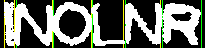

Running tally::: correct: 970 total: 993 accuracy: 0.977 avgEditDist 0.023
special window 196 208 ['I 1.00 ', 'N 0.78 ', 'V 0.36 ', 'Y 0.05 ', 'T 0.04 ']
New example, correct answers:
OVOANI
[4, 47, 84, 119, 163, 203]
[50, 86, 123, 164, 205, 215]
model 3: OVOANI 0.541
[0, 48, 84, 120, 160, 196]
[48, 84, 120, 160, 200, 208]
edit distance: 0


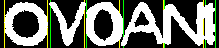

Running tally::: correct: 971 total: 994 accuracy: 0.977 avgEditDist 0.023
special window 108 116 ['N 0.99 ', 'H 0.83 ', 'F 0.04 ', 'J 0.01 ', 'V 0.01 ']
New example, correct answers:
ULNHNL
[4, 38, 76, 115, 150, 187]
[40, 78, 116, 151, 188, 220]
model 3: ULNHNL 0.551
[0, 40, 76, 116, 152, 188]
[40, 76, 112, 152, 188, 220]
edit distance: 0


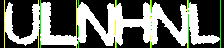

Running tally::: correct: 972 total: 995 accuracy: 0.977 avgEditDist 0.023
special window 104 112 ['L 1.00 ', 'T 0.02 ', 'V 0.02 ', 'Y 0.02 ', 'A 0.01 ']
New example, correct answers:
LELLM
[4, 37, 70, 103, 141]
[38, 71, 105, 143, 194]
model 3: LELLM 0.568
[0, 40, 72, 108, 144]
[40, 72, 104, 144, 196]
edit distance: 0


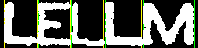

Running tally::: correct: 973 total: 996 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
SO
[4, 36]
[39, 82]
model 3: SO 0.812
[0, 36]
[36, 84]
edit distance: 0


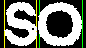

Running tally::: correct: 974 total: 997 accuracy: 0.977 avgEditDist 0.023
New example, correct answers:
URETAO
[4, 41, 78, 112, 143, 181]
[44, 80, 113, 148, 185, 222]
model 3: RRETAO 0.167
[0, 40, 80, 112, 148, 184]
[40, 80, 112, 148, 184, 224]
edit distance: 1
-----------------------------------------------------------------------------


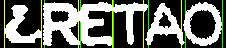

Running tally::: correct: 974 total: 998 accuracy: 0.976 avgEditDist 0.024
special window 76 84 ['H 1.00 ', 'K 0.94 ', 'V 0.04 ', 'N 0.02 ', 'F 0.01 ']
New example, correct answers:
AHKE
[4, 44, 81, 116]
[47, 82, 118, 156]
model 3: AHKE 0.640
[0, 44, 84, 116]
[44, 80, 116, 156]
edit distance: 0


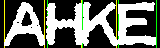

Running tally::: correct: 975 total: 999 accuracy: 0.976 avgEditDist 0.024
New example, correct answers:
SOFSE
[4, 40, 86, 120, 165]
[42, 88, 122, 167, 206]
model 3: SOFSE 0.538
[0, 40, 84, 124, 168]
[40, 84, 124, 168, 208]
edit distance: 0


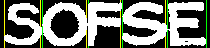

Running tally::: correct: 976 total: 1000 accuracy: 0.976 avgEditDist 0.024
(model, correct)
('R', 'R'): 350
('S', 'S'): 210
('T', 'T'): 249
('O', 'O'): 310
('C', 'C'): 123
('E', 'E'): 463
('L', 'L'): 281
('V', 'V'): 243
('P', 'P'): 115
('N', 'N'): 313
('I', 'I'): 182
('A', 'A'): 381
('W', 'W'): 81
('G', 'G'): 83
-------('I', '%'): 3
('U', 'U'): 71
('B', 'B'): 68
('K', 'K'): 72
('D', 'D'): 199
('H', 'H'): 135
('F', 'F'): 65
-------('L', '%'): 2
('M', 'M'): 86
-------('%', 'I'): 3
-------('R', '%'): 1
-------('O', 'D'): 3
-------('Z', 'U'): 1
-------('A', '%'): 1
-------('R', 'S'): 2
-------('H', 'P'): 1
-------('H', 'R'): 1
-------('H', '%'): 1
-------('B', 'R'): 1
-------('W', 'N'): 1
-------('G', '%'): 1
-------('U', 'O'): 1
-------('R', 'U'): 1


In [6]:

e = EditDistanceFinder()
cnt = Counter()
showImages = False
numCorrect = 0
runningCount = 0
sumED = 0
numPredictions = 1000

# test approaches
for i in range(numPredictions):
    img,char_list,char_starts,char_ends = generate_test_example(
                    training_images, letter_keys, character_set=character_set,
                    H=48, min_chars=2, max_chars=6)
    img = pad_image(img, img.shape[1]+8, H)
    true_word = ''.join(char_list)
    

    
    conf3, word3, pred_starts, pred_ends = dynamic(model3, img)
    
    print('New example, correct answers:')
    print(''.join(char_list))
    print([j+4 for j in char_starts])
    print([j+4 for j in char_ends])
    
    print("model 3: %s %.3f" % (word3, conf3))
    print(pred_starts)
    print(pred_ends)

    dist,alignment = e.align(word3, true_word)
    print("edit distance: %d" % dist)
    sumED += dist
    for a in alignment:
        cnt[a] += 1
    if dist == 0:
        numCorrect += 1
    else:
        print("-----------------------------------------------------------------------------")
    for j in range(len(char_starts)):
        img[0:H,char_starts[j]+4,0]=255
        img[0:H,char_starts[j]+4,1]=255
        img[0:H,char_ends[j]+4,1]=255
    showarray(img)
    runningCount += 1
 
    print("Running tally::: correct: %d total: %d accuracy: %.3f avgEditDist %.3f" % (numCorrect,
    runningCount,float(numCorrect)/runningCount,
    float(sumED)/runningCount))

    #slidingWindow(model2, img)
    #if showImages:
     #   cv2.imshow('image',img)
      #  cv2.waitKey(0)
       # cv2.destroyAllWindows()

print("(model, correct)")
for a in cnt.keys():
    if a[0] != a[1]:
        print("-------", end="")
    print("%s: %d" % (a, cnt[a]))

